In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter
import os, re
import seaborn as sns
from sys import stdout

from scipy.signal import savgol_filter
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

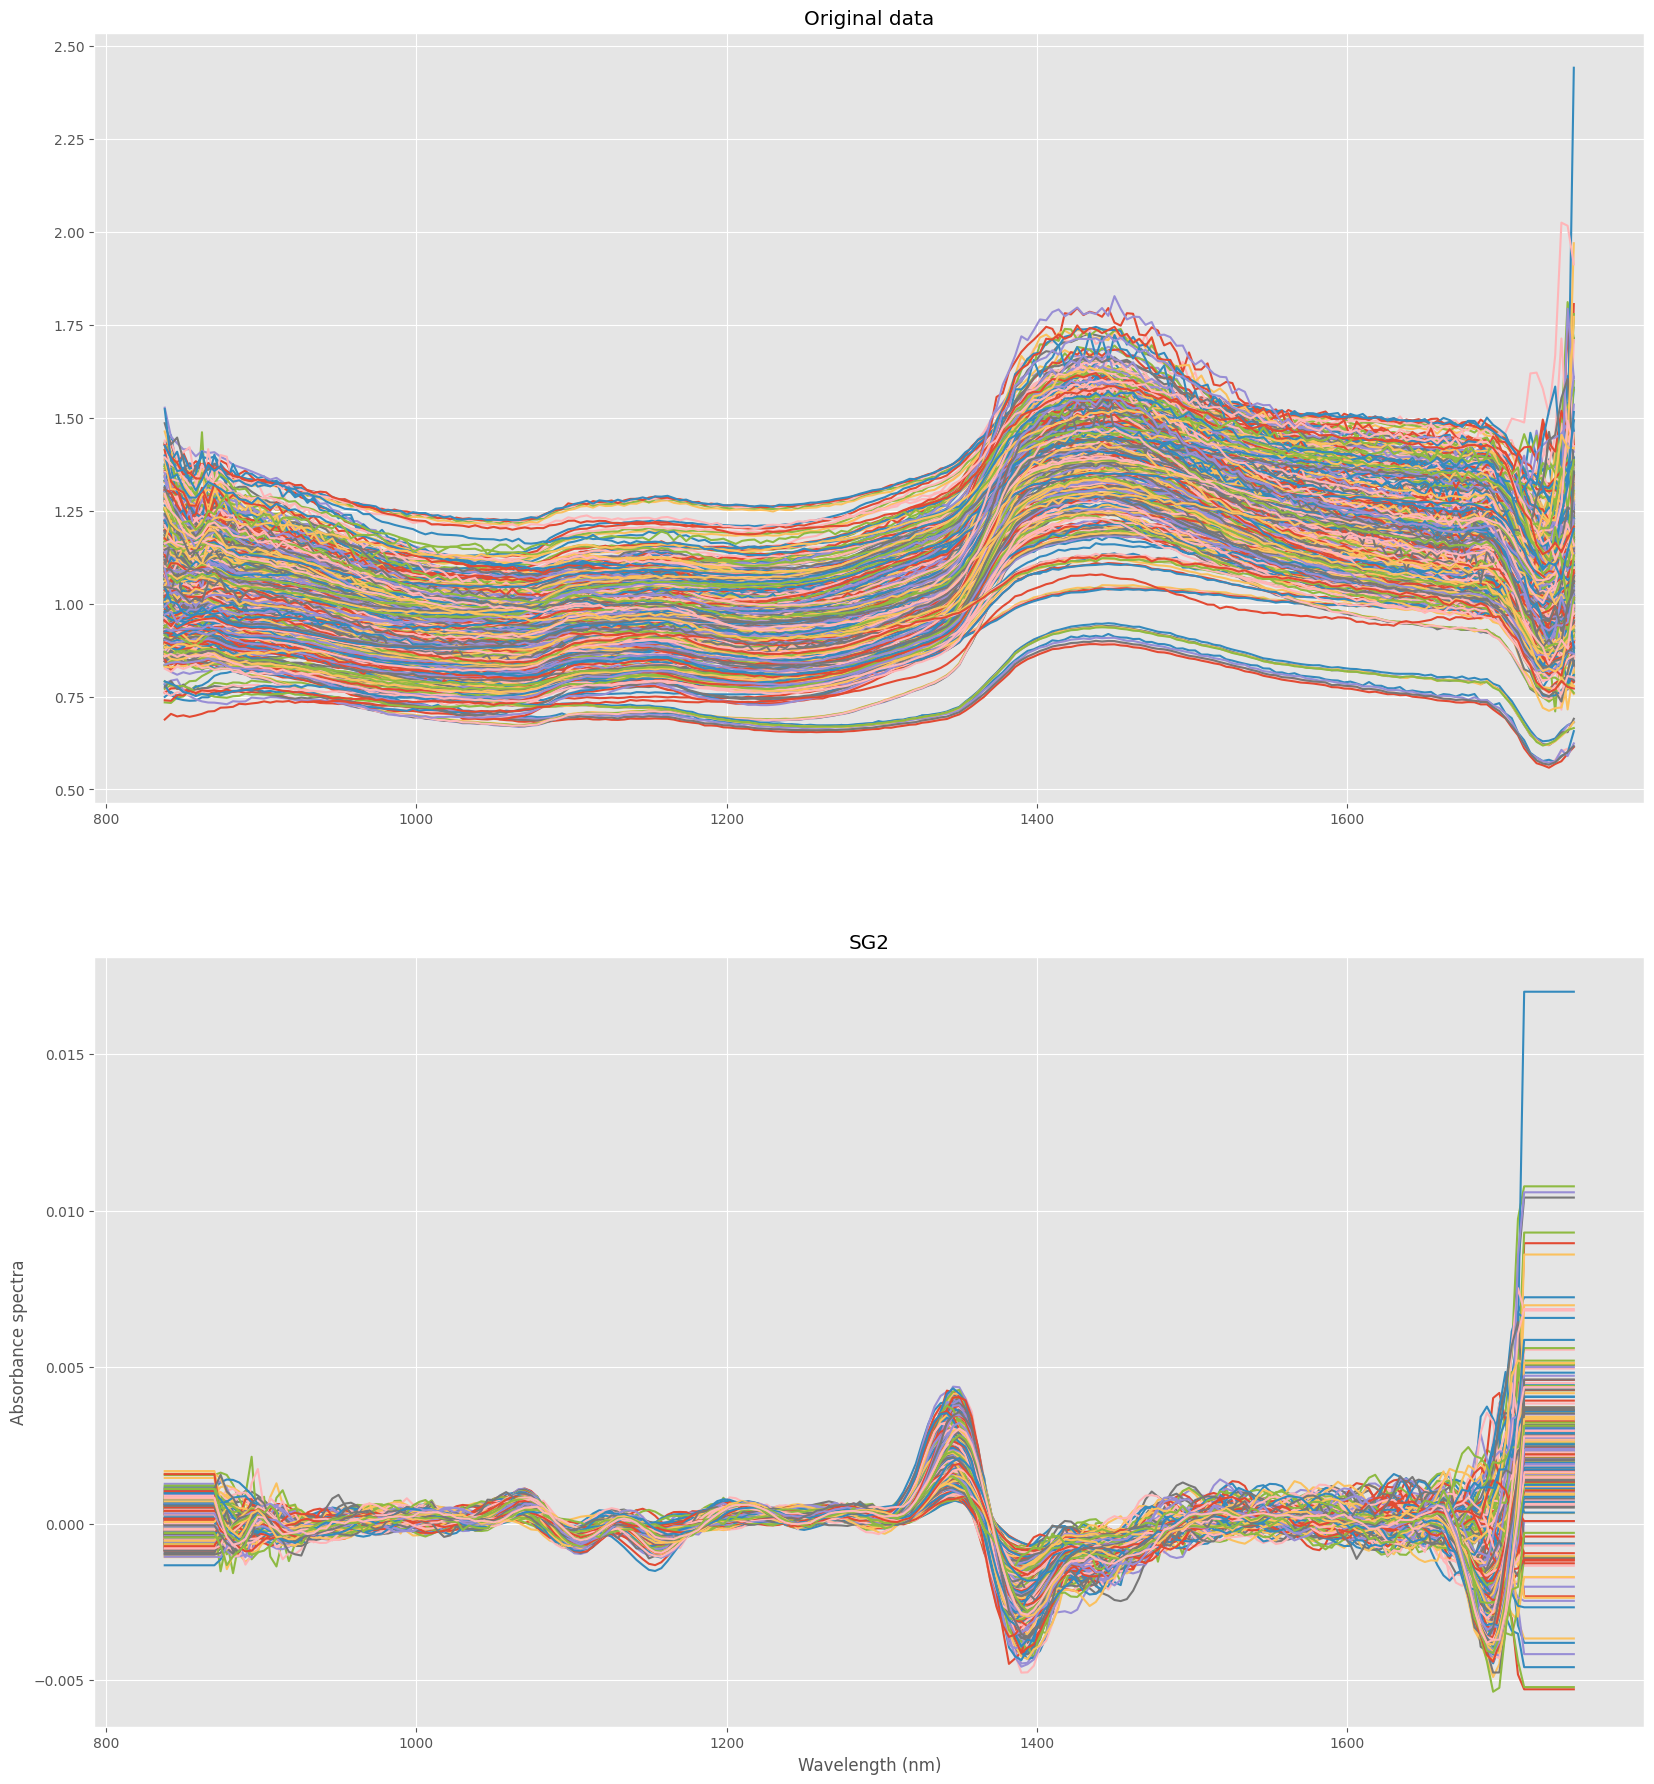

In [2]:
data = pd.read_csv("D:/NIR/11_3_2024/data_chay_so_lieu/Histamin/his_ngu_da_gay.csv")
#data = data[data['vi tri do'] == 'd']
y = np.array(data.values[:,2])
X = np.array(data.values[:, 6:])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 17, polyorder=2, deriv=2) 
#Plot absorbance spectra
# with plt.style.context('ggplot'):
#     plt.plot(w1, X.T)
#     plt.xlabel("Wavelength (nm)")
#     plt.ylabel('Absorbance')
# plt.show()
plt.figure(figsize=(20,22))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(w1, X.T)
    plt.title('Original data')
 
    ax2 = plt.subplot(212)
    plt.plot(w1, x2.T)
    plt.ylabel('Absorbance spectra')
    plt.title('SG2')
    plt.xlabel('Wavelength (nm)')

PLS components:  4
Number Wavelengths remove:  221
MSE min:  39738.78402895453

R2 calib: 0.858
R2 CV: 0.327
MSE calib: 8398.702
MSE CV: 39738.784


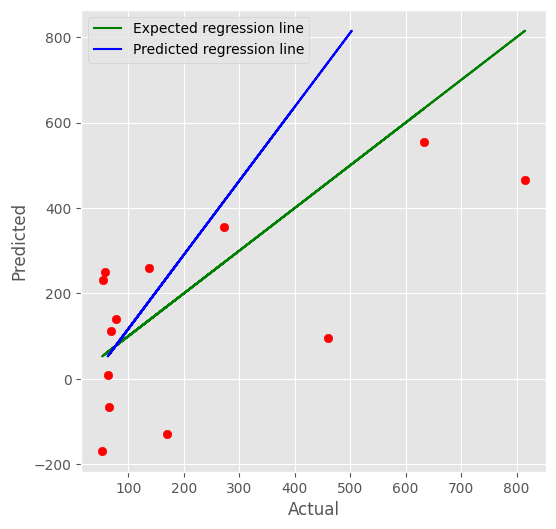

[180, 185, 97, 85, 96, 10, 201]
[224.97158029]
y = 224.972  + 216.67 * X_181 -23.449 * X_186 -1.563 * X_98 -127.475 * X_86 -9.564 * X_97  + 248.394 * X_11 -139.527 * X_202 


In [4]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/his/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print(Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)
print(intercept)

#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print(equation)


Out-of-Bag Score: -0.9318914052791027
Mean Squared Error: 16826.895704000013
R-squared: 0.7150059341231713
True
Shape of x2: (13, 228)
Some values in x2: [[-1.09752285e-03 -1.09752285e-03 -1.09752285e-03 ...  2.99899056e-03
   2.99899056e-03  2.99899056e-03]
 [-8.42746816e-04 -8.42746816e-04 -8.42746816e-04 ...  2.60055601e-03
   2.60055601e-03  2.60055601e-03]
 [-9.29822366e-04 -9.29822366e-04 -9.29822366e-04 ...  3.33731379e-03
   3.33731379e-03  3.33731379e-03]
 [-5.90161684e-05 -5.90161684e-05 -5.90161684e-05 ...  1.37666536e-03
   1.37666536e-03  1.37666536e-03]
 [-7.03695903e-04 -7.03695903e-04 -7.03695903e-04 ...  2.61913803e-03
   2.61913803e-03  2.61913803e-03]]
Information about a specific element in x2: -0.0010975228506787033


ValueError: x and y must be the same size

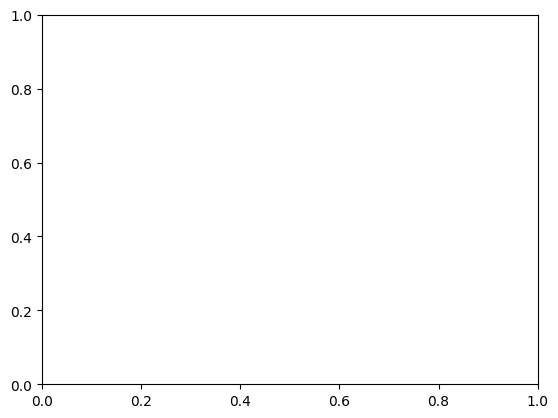

In [13]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/his/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
                      
# x_categorical = data2.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
                      
# x_numerical = data2.select_dtypes(exclude=['object']).values
                      
# X = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values


from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
regressor.fit(x2, y)
from sklearn.metrics import mean_squared_error, r2_score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
predictions = regressor.predict(x2)
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')


import numpy as np
                      
print(x2.any())
print("Shape of x2:", x2.shape)
print("Some values in x2:", x2[:5])
print("Information about a specific element in x2:", x2[0, 0])

# X_flat = X.flatten()
# X_grid = np.arange(min(X_flat), max(X_flat), 0.01)
# #X_grid = np.arange(min(X),max(X),0.01)
                      
# X_grid = X_grid.reshape(len(X_grid),1) 
                     
# plt.scatter(X,y, color='blue') #plotting real points                     
# plt.plot(X_grid, regressor.predict(X_grid),color='green') #plotting for predict points                                       

# plt.title("Random Forest Regression Results")
                      

# plt.xlabel('Position level')
                      
# plt.ylabel('Salary')                  
# plt.show()
                      
                      
plt.scatter(x2, y, color='blue')  # Plot điểm thực tế
#plt.plot(X_grid, regressor.predict(X_grid), color='green')  # Plot điểm dự đoán
plt.title("Random Forest Regression Results")
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()


PLS components:  8
Number Wavelengths remove:  191
MSE min:  13935.234086829358

R2 calib: 0.998
R2 CV: 0.764
MSE calib: 103.459
MSE CV: 13935.234


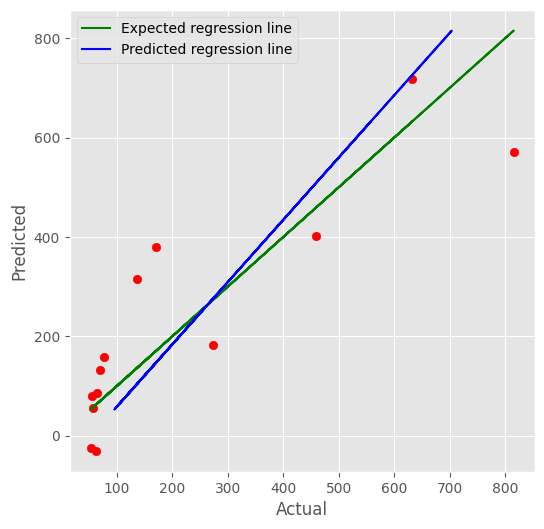

[101, 86, 204, 80, 23, 189, 25, 24, 146, 52, 142, 148, 165, 104, 143, 103, 147, 27, 102, 77, 34, 72, 51, 36, 28, 187, 17, 163, 217, 35, 89, 185, 190, 184, 158, 87, 88]
[224.75595536]
y = 224.756  + 22.963 * X_102  + 25.246 * X_87  + 7.514 * X_205 -20.967 * X_81  + 15.643 * X_24  + 9.745 * X_190  + 20.254 * X_26  + 15.078 * X_25 -16.607 * X_147  + 25.205 * X_53 -35.218 * X_143 -12.851 * X_149 -16.16 * X_166  + 15.985 * X_105 -35.787 * X_144  + 14.861 * X_104 -23.241 * X_148  + 15.959 * X_28  + 26.441 * X_103 -20.548 * X_78 -23.503 * X_35 -22.422 * X_73  + 26.755 * X_52 -22.926 * X_37  + 14.97 * X_29  + 42.612 * X_188 -18.5 * X_18  + 47.134 * X_164 -14.849 * X_218 -24.746 * X_36  + 24.093 * X_90 -28.219 * X_186  + 11.213 * X_191 -24.625 * X_185  + 27.196 * X_159  + 40.155 * X_88  + 50.736 * X_89 


In [5]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/his/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  4
Number Wavelengths remove:  223
MSE min:  51080.63211686498

R2 calib: 0.712
R2 CV: 0.198
MSE calib: 18319.715
MSE CV: 51080.632


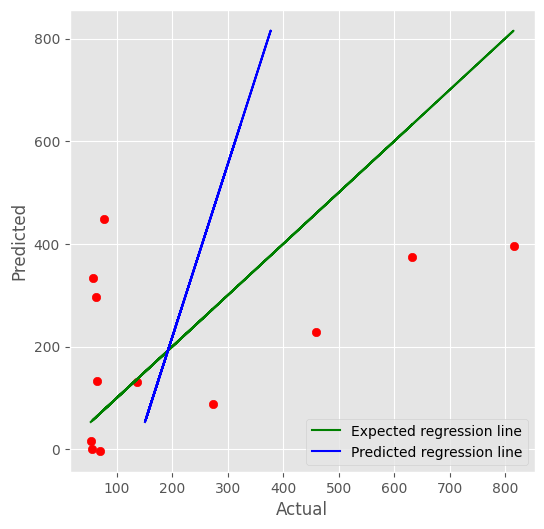

Các bước sóng giữ lại: [182, 85, 194, 166, 202]
Phương trình chính quy: y = 229.537 -75.54 * X_183 -73.185 * X_86  + 160.664 * X_195 -35.454 * X_167 -216.399 * X_203 


In [6]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-3], dtype='float')


data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  28
Number Wavelengths remove:  188
MSE min:  70.97159133300418

R2 calib: 1.000
R2 CV: 0.939
MSE calib: 0.000
MSE CV: 70.972


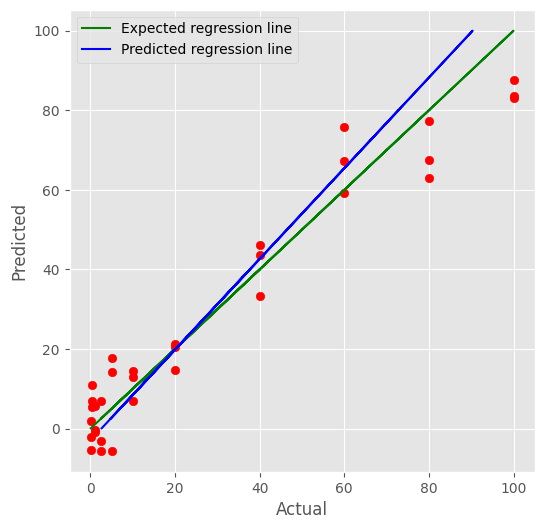

Các bước sóng giữ lại: [94, 135, 142, 33, 149, 36, 175, 80, 32, 87, 41, 165, 164, 95, 180, 130, 31, 171, 190, 85, 204, 37, 73, 219, 162, 145, 154, 25, 10, 212, 210, 11, 12, 213, 214, 211, 217, 216, 218, 215]
Phương trình chính quy: y = 28.984  + 5.511 * X_95  + 1.581 * X_136  + 4.074 * X_143 -3.545 * X_34  + 0.174 * X_150  + 3.532 * X_37 -3.888 * X_176  + 0.173 * X_81 -0.748 * X_33  + 2.69 * X_88  + 5.354 * X_42 -3.603 * X_166  + 0.197 * X_165 -0.053 * X_96 -1.873 * X_181  + 0.403 * X_131 -0.13 * X_32 -0.357 * X_172 -4.288 * X_191 -4.315 * X_86 -0.037 * X_205  + 4.472 * X_38 -1.177 * X_74 -0.663 * X_220 -1.362 * X_163  + 3.228 * X_146 -0.596 * X_155  + 3.724 * X_26 -5.828 * X_11 -1.941 * X_213 -5.212 * X_211 -3.165 * X_12 -4.151 * X_13 -2.513 * X_214 -0.499 * X_215 -4.495 * X_212 -5.906 * X_218 -1.493 * X_217 -4.022 * X_219 -2.995 * X_216 


In [10]:
data1 = pd.read_csv("D:/NIR/Data Domoic 10_1_2024/CDA/Cá thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
#data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-3], dtype='float')


##data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,0])
X = np.array(data2.values[:, 1:])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


In [7]:
data2 = pd.read_csv("D:/NIR/Data Domoic 10_1_2024/CDA/Cá ngừ.csv")
#array = data['vi tri do'].unique()
#data2 = data1[data1['vi tri do'] == 'h']
data2 = data2.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
#data2 = data2.drop(data2[data2['K%'] <10].index)
#data2 = data2.drop(data2[data2['K%'] > 80].index)



y = np.array(data2.values[:,0])
X = np.array(data2.values[:, 0:])
print(X)
x2 = savgol_filter(X, 15, polyorder=2, deriv=2) 


def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

    
    filtered_points = [(actual, predicted) for actual, predicted in zip(y, y_cv) if abs(actual - predicted) / actual * 100 < 100 and abs(actual - predicted) <100]
    filtered_y, filtered_y_cv = zip(*filtered_points)
    
    
    
    # Tìm vị trí các giá trị y đã lọc trong danh sách ban đầu
    indices = np.where(np.isin(y, filtered_y))

    # Lấy các cột tương ứng trong ma trận X
    filtered_X = Xc[indices]
    print(filtered_X.shape)
    print(Xc.shape)
    pls_filter = PLSRegression(n_components=mseminx[0]+1)
    pls_filter.fit(filtered_X, filtered_y)
    filtered_y_c = pls_opt.predict(filtered_X)
    
    
    
    score_c = r2_score(filtered_y, filtered_y_c)
    score_cv = r2_score(filtered_y, filtered_y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(filtered_y, filtered_y_c)
    mse_cv = mean_squared_error(filtered_y, filtered_y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)
  
    #new_points = [(8.86,13),(8.86,18),(130.77, 120),(130.77, 115),(128.65,116),(115.56,110),(115.56,115),(91.52,90),(91.52,95),(82,78),(65.69,70),(63.06,78),(57.26,50),(57.16,52),(57.26,50)]
    #new_y, new_y_cv = zip(*new_points)
  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        # for i, (actual, predicted) in enumerate(zip(y, y_cv)):
        #     relative_error = abs(actual - predicted) / actual * 100
        #     if relative_error < 500:
        #     #if abs(actual - predicted) < 150:
        #         plt.scatter(actual, predicted, color='red')
        # plt.plot(y, y, '-g', label='Expected regression line')
        
                #z = np.polyfit(actual, predicted, 1)
                
        
        #plt.scatter(new_y, new_y_cv, color='red')

        plt.scatter(filtered_y, filtered_y_cv, color='red')
        plt.plot(filtered_y, filtered_y, '-g', label='Expected regression line')
        
        z = np.polyfit(filtered_y, filtered_y_cv, 1)
        plt.plot(np.polyval(z, filtered_y), filtered_y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()
    
    sorted_tuple = tuple(sorted(filtered_y))
    print(sorted_tuple)
    
    # print(filtered_y)
     
    
    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print(Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_filter)

plt.show()
a, b, c, d, pls_filter = pls_variable_selection(x2, y, 40, 10)


# Lấy ra các hệ số ước lượng từ mô hình PLS

pls_coef = pls_filter.coef_

# Chuyển đổi các hệ số ước lượng thành phương trình chính quy
pls_coef_inv = np.linalg.pinv(pls_coef)
ridge_coef = pls_coef_inv

# In ra phương trình chính quy tương ứng với các hệ số chính quy
print('Phương trình chính quy:')
print('y = {:.6f}'.format(ridge_coef[0, 0]), end='')
for i in range(1, b+1):
    print(' + {:.6f}*X{}'.format(ridge_coef[0, i], i), end='')
print()


[[ 0.1       1.086966  1.07272  ...  0.662758  0.659153  0.692404]
 [ 0.1       1.089586  1.091446 ...  0.674522  0.674681  0.698046]
 [ 0.1       1.0926    1.086456 ...  0.673737  0.666102  0.701968]
 ...
 [80.        1.136982  1.13041  ...  0.653046  0.638949  0.662779]
 [80.        1.148265  1.139058 ...  0.657056  0.615778  0.661635]
 [80.        1.137401  1.150634 ...  0.636406  0.627754  0.663598]]


ValueError: illegal value in 4th argument of internal gesdd

PLS components:  10
Number Wavelengths remove:  188
MSE min:  535467.7560160179

R2 calib: 0.711
R2 CV: 0.380
MSE calib: 250135.595
MSE CV: 535467.756


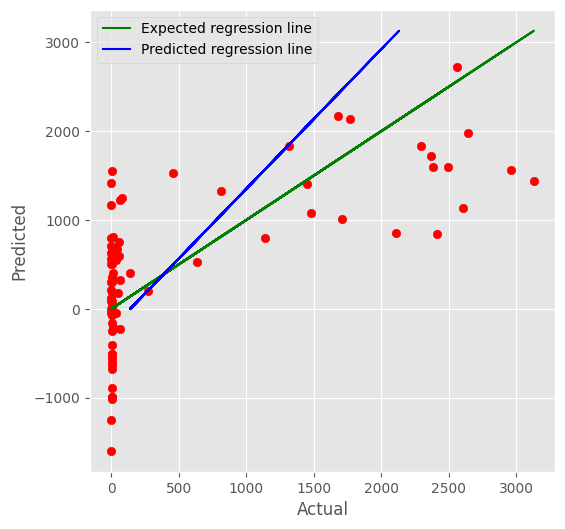

Các bước sóng giữ lại: [49, 51, 112, 92, 189, 113, 48, 31, 208, 193, 192, 93, 54, 133, 132, 167, 179, 117, 95, 218, 197, 21, 168, 190, 203, 100, 98, 32, 116, 114, 195, 35, 96, 34, 97, 33, 204, 115, 99, 194]
Phương trình chính quy: y = 533.229 -472.992 * X_50  + 358.397 * X_52 -21.191 * X_113 -206.885 * X_93  + 170.611 * X_190 -189.475 * X_114 -29.778 * X_49 -24.757 * X_32 -18.569 * X_209  + 152.185 * X_194  + 154.221 * X_193 -53.674 * X_94  + 714.234 * X_55  + 373.922 * X_134  + 163.668 * X_133 -514.851 * X_168 -234.719 * X_180  + 371.17 * X_118 -214.535 * X_96 -339.317 * X_219  + 57.303 * X_198 -461.533 * X_22 -259.563 * X_169  + 122.884 * X_191  + 21.482 * X_204 -213.807 * X_101  + 27.708 * X_99 -131.134 * X_33  + 295.354 * X_117 -25.293 * X_115  + 251.319 * X_196  + 322.27 * X_36  + 18.951 * X_97  + 334.16 * X_35 -306.792 * X_98  + 108.29 * X_34 -541.239 * X_205  + 315.1 * X_116 -162.629 * X_100  + 577.251 * X_195 


In [28]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  19
Number Wavelengths remove:  190
MSE min:  501052.05978944554

R2 calib: 0.825
R2 CV: 0.429
MSE calib: 153184.092
MSE CV: 501052.060


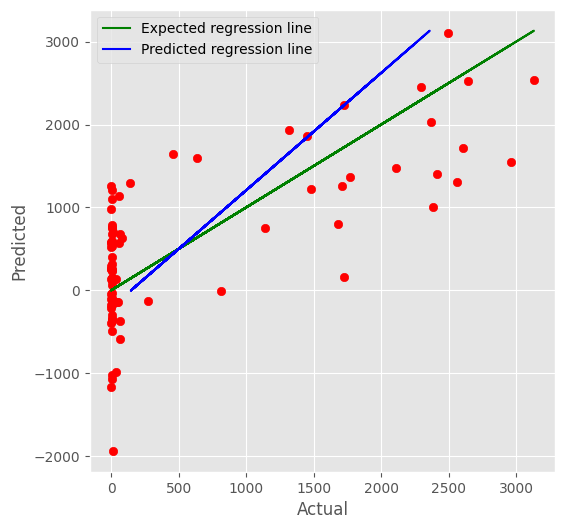

Các bước sóng giữ lại: [155, 29, 47, 49, 107, 116, 22, 28, 15, 23, 177, 20, 175, 153, 201, 182, 56, 178, 38, 189, 37, 219, 16, 92, 200, 169, 162, 185, 55, 50, 63, 41, 198, 102, 183, 85, 54, 195]
Phương trình chính quy: y = 562.717  + 962.216 * X_156  + 602.344 * X_30  + 466.85 * X_48 -508.683 * X_50 -1127.924 * X_108 -1294.573 * X_117 -47.933 * X_23 -557.237 * X_29 -448.322 * X_16 -260.916 * X_24 -258.041 * X_178  + 363.318 * X_21  + 486.413 * X_176  + 690.034 * X_154  + 458.563 * X_202 -498.122 * X_183 -210.271 * X_57  + 746.082 * X_179  + 411.76 * X_39  + 207.251 * X_190  + 153.71 * X_38  + 330.166 * X_220  + 341.39 * X_17 -43.305 * X_93  + 638.614 * X_201 -545.613 * X_170  + 286.854 * X_163 -147.218 * X_186  + 863.528 * X_56 -540.308 * X_51 -395.578 * X_64 -601.0 * X_42  + 448.368 * X_199 -309.036 * X_103  + 1021.298 * X_184 -772.266 * X_86  + 906.658 * X_55  + 1256.995 * X_196 


In [29]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'b']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  20
Number Wavelengths remove:  177
MSE min:  435867.51538243034

R2 calib: 0.895
R2 CV: 0.500
MSE calib: 91373.905
MSE CV: 435867.515


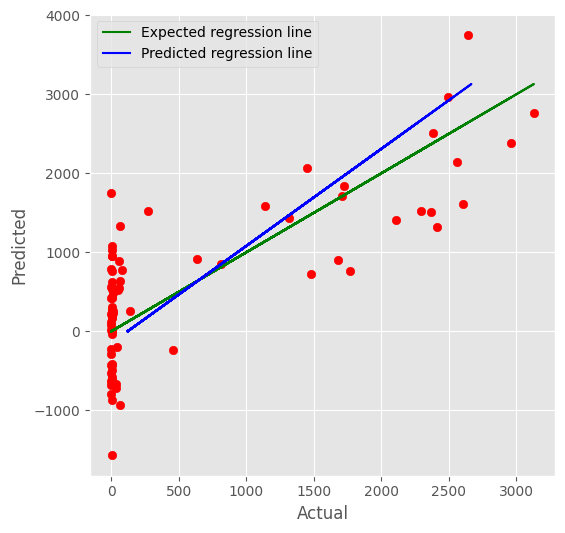

Các bước sóng giữ lại: [34, 33, 8, 177, 137, 190, 62, 172, 161, 142, 14, 77, 93, 37, 121, 36, 28, 94, 16, 135, 153, 48, 154, 40, 90, 97, 69, 134, 38, 55, 51, 164, 184, 179, 11, 218, 10, 30, 71, 192, 107, 20, 176, 54, 182, 60, 112, 219, 178, 193, 200]
Phương trình chính quy: y = 548.251 -1022.268 * X_35  + 655.085 * X_34  + 1158.47 * X_9 -362.909 * X_178  + 320.716 * X_138 -490.809 * X_191  + 426.653 * X_63 -694.357 * X_173  + 439.966 * X_162 -771.968 * X_143 -700.786 * X_15 -1044.619 * X_78 -446.949 * X_94  + 550.026 * X_38  + 1010.157 * X_122 -207.003 * X_37  + 559.019 * X_29 -756.354 * X_95  + 658.011 * X_17  + 330.887 * X_136 -719.518 * X_154 -42.154 * X_49 -305.173 * X_155 -38.707 * X_41 -1181.92 * X_91 -578.389 * X_98  + 650.414 * X_70  + 29.394 * X_135 -396.688 * X_39  + 623.891 * X_56  + 34.527 * X_52  + 243.363 * X_165 -835.275 * X_185 -647.827 * X_180 -87.014 * X_12 -255.381 * X_219 -715.902 * X_11 -418.696 * X_31 -444.515 * X_72  + 363.118 * X_193 -778.118 * X_108  + 342.224 

In [30]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'c']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  32
Number Wavelengths remove:  157
MSE min:  616607.687126834

R2 calib: 0.984
R2 CV: 0.292
MSE calib: 13929.915
MSE CV: 616607.687


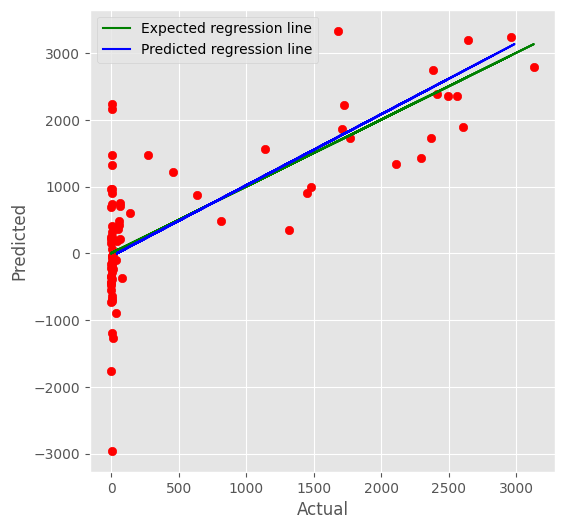

Các bước sóng giữ lại: [202, 108, 124, 199, 171, 154, 119, 143, 86, 33, 25, 150, 153, 19, 192, 67, 92, 89, 39, 55, 59, 56, 115, 160, 114, 132, 218, 38, 208, 49, 84, 102, 63, 52, 64, 166, 93, 112, 51, 190, 197, 110, 97, 26, 34, 144, 96, 46, 159, 146, 155, 69, 74, 172, 196, 71, 111, 191, 104, 13, 18, 164, 145, 165, 181, 11, 185, 58, 24, 42, 200]
Phương trình chính quy: y = 543.349  + 463.106 * X_203 -647.255 * X_109  + 2696.709 * X_125  + 584.002 * X_200 -510.631 * X_172  + 362.563 * X_155  + 302.411 * X_120 -1861.373 * X_144  + 233.19 * X_87  + 139.648 * X_34  + 812.673 * X_26 -156.516 * X_151  + 579.2 * X_154 -1269.391 * X_20  + 101.61 * X_193 -161.088 * X_68 -1759.453 * X_93  + 649.884 * X_90 -1013.166 * X_40 -1733.922 * X_56 -25.531 * X_60  + 193.789 * X_57 -217.386 * X_116  + 801.446 * X_161 -696.56 * X_115 -1268.425 * X_133  + 930.857 * X_219  + 1142.473 * X_39 -284.361 * X_209  + 1089.13 * X_50 -22.325 * X_85 -336.424 * X_103  + 805.861 * X_64  + 1147.283 * X_53 -453.547 * X_65  +

In [31]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  5
Number Wavelengths remove:  184
MSE min:  655936.2444987583

R2 calib: 0.414
R2 CV: 0.247
MSE calib: 510220.640
MSE CV: 655936.244


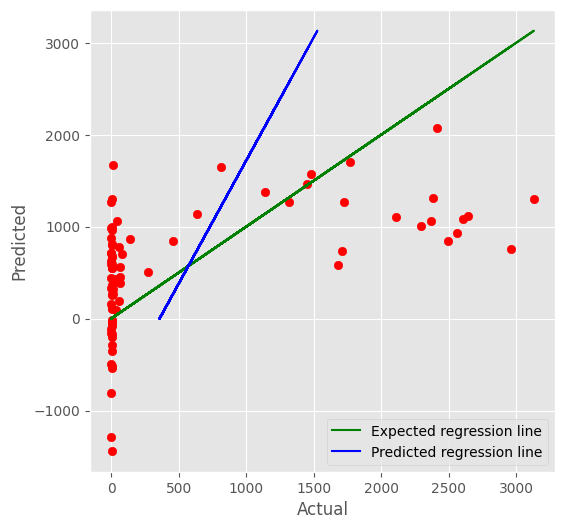

Các bước sóng giữ lại: [8, 16, 36, 204, 51, 102, 32, 175, 101, 46, 31, 37, 149, 119, 9, 128, 33, 135, 181, 122, 10, 120, 89, 28, 151, 152, 121, 145, 150, 87, 30, 141, 182, 29, 129, 143, 88, 134, 142, 144, 130, 133, 132, 131]
Phương trình chính quy: y = 548.282 -91.233 * X_9  + 22.519 * X_17  + 57.275 * X_37 -58.097 * X_205  + 156.841 * X_52 -39.664 * X_103  + 46.4 * X_33  + 0.375 * X_176 -41.903 * X_102  + 52.336 * X_47  + 47.328 * X_32  + 39.725 * X_38 -84.516 * X_150 -56.982 * X_120 -66.832 * X_10  + 19.544 * X_129  + 58.003 * X_34  + 57.106 * X_136  + 22.801 * X_182 -50.559 * X_123 -66.294 * X_11 -51.419 * X_121 -77.603 * X_90  + 73.121 * X_29 -47.21 * X_152 -69.638 * X_153 -54.694 * X_122 -49.365 * X_146 -77.099 * X_151 -34.126 * X_88  + 72.669 * X_31 -24.842 * X_142  + 46.581 * X_183  + 93.759 * X_30  + 36.5 * X_130 -54.315 * X_144 -88.222 * X_89  + 72.084 * X_135 -40.735 * X_143 -74.173 * X_145  + 61.563 * X_131  + 84.863 * X_134  + 94.239 * X_133  + 106.374 * X_132 


In [32]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'e']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  4
Number Wavelengths remove:  209
MSE min:  727441.5492357473

R2 calib: 0.330
R2 CV: 0.165
MSE calib: 583501.351
MSE CV: 727441.549


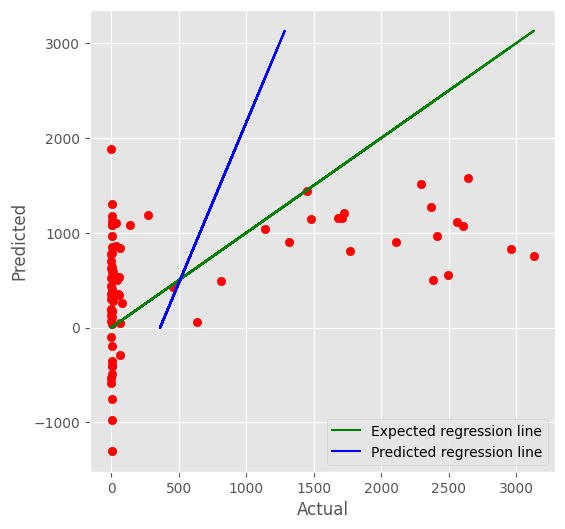

Các bước sóng giữ lại: [24, 16, 90, 26, 25, 141, 28, 27, 145, 133, 130, 30, 131, 146, 132, 134, 144, 143, 142]
Phương trình chính quy: y = 549.267  + 185.723 * X_25  + 114.475 * X_17 -45.773 * X_91  + 30.275 * X_27  + 74.23 * X_26  + 38.152 * X_142  + 97.495 * X_29  + 59.563 * X_28 -106.008 * X_146  + 145.23 * X_134 -17.001 * X_131  + 277.116 * X_31  + 31.381 * X_132 -73.526 * X_147  + 105.171 * X_133  + 271.949 * X_135 -179.756 * X_145 -107.513 * X_144 -42.232 * X_143 


In [33]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'f']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  5
Number Wavelengths remove:  156
MSE min:  656851.027089668

R2 calib: 0.461
R2 CV: 0.246
MSE calib: 469435.365
MSE CV: 656851.027


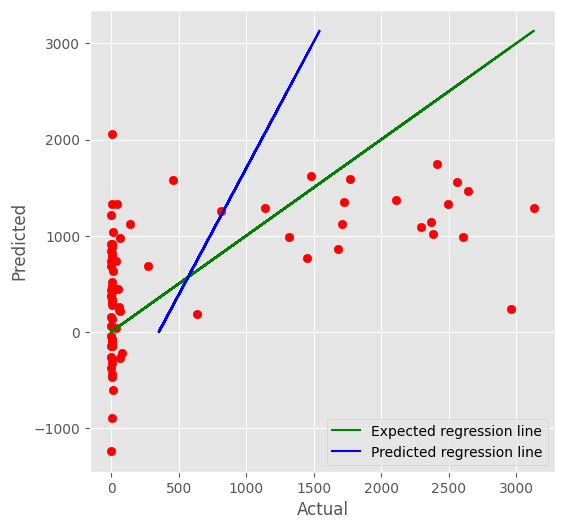

Các bước sóng giữ lại: [6, 5, 211, 25, 74, 75, 80, 35, 64, 26, 114, 40, 198, 153, 87, 180, 138, 122, 60, 107, 10, 36, 83, 70, 63, 123, 68, 152, 69, 219, 121, 27, 32, 90, 30, 47, 168, 213, 120, 92, 28, 184, 215, 182, 45, 29, 46, 183, 181, 41, 31, 214, 78, 9, 216, 72, 197, 119, 116, 115, 8, 71, 217, 218, 11, 43, 44, 42, 118, 62, 61, 117]
Phương trình chính quy: y = 548.252 -56.003 * X_7 -56.003 * X_6 -8.025 * X_212  + 8.252 * X_26  + 69.421 * X_75  + 66.924 * X_76  + 24.022 * X_81 -63.898 * X_36  + 31.65 * X_65  + 1.831 * X_27 -61.353 * X_115 -54.663 * X_41 -79.081 * X_199  + 47.654 * X_154  + 44.385 * X_88  + 30.512 * X_181  + 70.497 * X_139 -61.904 * X_123  + 18.724 * X_61  + 8.993 * X_108  + 45.778 * X_11 -85.576 * X_37  + 13.415 * X_84 -31.269 * X_71  + 24.135 * X_64 -77.145 * X_124 -37.729 * X_69  + 83.312 * X_153 -33.893 * X_70 -58.348 * X_220 -49.551 * X_122  + 31.502 * X_28  + 59.621 * X_33 -60.247 * X_91  + 60.279 * X_31 -31.427 * X_48 -70.001 * X_169 -27.802 * X_214 -34.877 * X

In [34]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'g']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  5
Number Wavelengths remove:  158
MSE min:  774898.2487213888

R2 calib: 0.370
R2 CV: 0.110
MSE calib: 548714.257
MSE CV: 774898.249


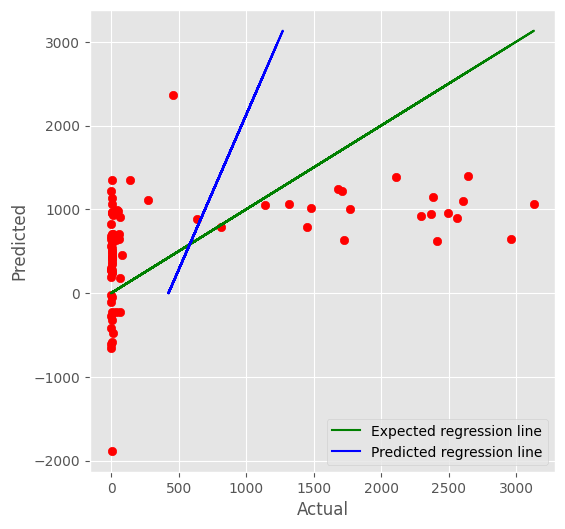

Các bước sóng giữ lại: [36, 151, 59, 114, 104, 134, 181, 140, 33, 125, 110, 84, 40, 171, 219, 198, 71, 46, 152, 124, 207, 82, 195, 106, 80, 122, 22, 160, 47, 79, 35, 123, 64, 213, 133, 182, 130, 212, 81, 83, 107, 131, 116, 132, 108, 78, 115, 193, 45, 41, 159, 72, 63, 60, 194, 121, 11, 15, 12, 120, 42, 43, 14, 13, 44, 119, 118, 117, 61, 62]
Phương trình chính quy: y = 548.794 -44.432 * X_37  + 34.553 * X_152  + 47.976 * X_60 -26.749 * X_115  + 51.075 * X_105  + 25.028 * X_135  + 17.368 * X_182 -52.889 * X_141 -14.502 * X_34 -37.762 * X_126  + 33.624 * X_111  + 58.138 * X_85 -55.77 * X_41  + 51.086 * X_172 -40.882 * X_220 -77.473 * X_199 -46.004 * X_72 -49.707 * X_47  + 28.993 * X_153 -41.4 * X_125 -28.899 * X_208  + 47.218 * X_83 -66.491 * X_196  + 46.736 * X_107  + 25.232 * X_81 -47.131 * X_123 -77.486 * X_23 -18.953 * X_161 -63.149 * X_48  + 29.669 * X_80 -50.603 * X_36 -54.665 * X_124  + 53.631 * X_65 -52.637 * X_214  + 46.534 * X_134  + 38.76 * X_183  + 58.286 * X_131 -52.404 * X_21

In [35]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


In [14]:
df_mau = pd.read_csv("D:/NIR/ure_ca_11_10_2022/data_ure_goc.csv")
columns = df_mau.columns

folder_path = "D:/NIR/ure_ca_11_10_2022/file_giai_nen"
dir_path = os.path.dirname(os.path.realpath(folder_path))
folder_names = np.array([f for f in os.listdir(folder_path)])

# for folder_name in folder_names:
#     file_names = np.array(os.listdir(folder_path+'\\'+folder_name))

for folder_name in folder_names:
    folder_names_2 = np.array(os.listdir(folder_path+'\\'+folder_name))
    
    for folder_name_2 in folder_names_2:  
        file_names = np.array(os.listdir(folder_path+'\\'+folder_name+'\\'+folder_name_2))

        for file_name in file_names:
            endfile = str(file_name[-3:])
            value = []
            if(endfile == 'csv'):
                x = np.asarray(folder_name_2).reshape(1, -1)
                y = np.asarray(file_name[8:9]).reshape(1, -1)
                z = np.asarray(file_name[7:8]).reshape(1, -1)
                file = pd.read_csv(folder_path+'\\'+folder_name+'\\'+folder_name_2+'\\'+file_name, error_bad_lines=False)
                time = file.iloc[0, 1]
                a = time.replace(' @ ', ' ')
                a = pd.to_datetime(a)
                a = np.asarray(a).reshape(1, -1)
                test = pd.read_csv(folder_path+'\\'+folder_name+'\\'+folder_name_2+'\\'+file_name,skiprows = 19)
                test = np.array(test['Absorbance (AU)']).reshape(1, -1)
                value = np.concatenate((x,z,y,test), axis = 1)
                value = pd.DataFrame(value, columns=columns)
                df_mau = df_mau.append(value, ignore_index=True)
                df_mau.to_csv (r"D:/NIR/ure_ca_11_10_2022/data_ure_goc.csv", index = None, header=True)    
df_mau.to_csv("D:/NIR/ure_ca_11_10_2022/data_ure_goc.csv", index = False, encoding='utf-8-sig')

b'Skipping line 8: expected 4 fields, saw 6\nSkipping line 9: expected 4 fields, saw 6\n'
b'Skipping line 8: expected 4 fields, saw 6\nSkipping line 9: expected 4 fields, saw 6\n'
b'Skipping line 8: expected 4 fields, saw 6\nSkipping line 9: expected 4 fields, saw 6\n'
b'Skipping line 8: expected 4 fields, saw 6\nSkipping line 9: expected 4 fields, saw 6\n'
b'Skipping line 8: expected 4 fields, saw 6\nSkipping line 9: expected 4 fields, saw 6\n'
b'Skipping line 8: expected 4 fields, saw 6\nSkipping line 9: expected 4 fields, saw 6\n'
b'Skipping line 8: expected 4 fields, saw 6\nSkipping line 9: expected 4 fields, saw 6\n'
b'Skipping line 8: expected 4 fields, saw 6\nSkipping line 9: expected 4 fields, saw 6\n'
b'Skipping line 8: expected 4 fields, saw 6\nSkipping line 9: expected 4 fields, saw 6\n'
b'Skipping line 8: expected 4 fields, saw 6\nSkipping line 9: expected 4 fields, saw 6\n'
b'Skipping line 8: expected 4 fields, saw 6\nSkipping line 9: expected 4 fields, saw 6\n'
b'Skipping

PLS components:  4
Number Wavelengths remove:  223
MSE min:  51080.63211686498

R2 calib: 0.712
R2 CV: 0.198
MSE calib: 18319.715
MSE CV: 51080.632


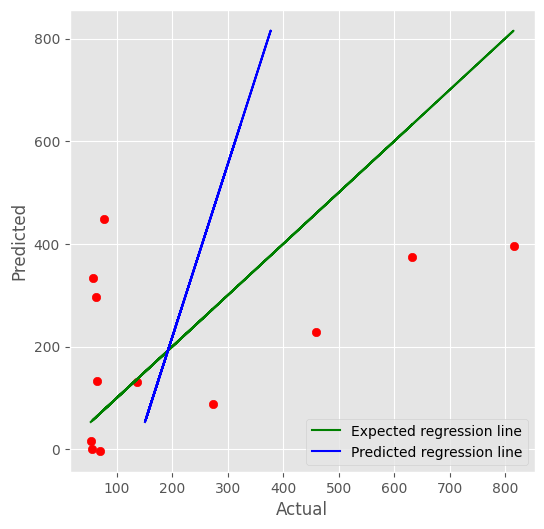

Các bước sóng giữ lại: [182, 85, 194, 166, 202]
Phương trình chính quy: y = 229.537 -75.54 * X_183 -73.185 * X_86  + 160.664 * X_195 -35.454 * X_167 -216.399 * X_203 


In [5]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-3], dtype='float')


data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  24
Number Wavelengths remove:  150
MSE min:  44440.10537387994

R2 calib: 0.998
R2 CV: 0.801
MSE calib: 449.525
MSE CV: 44440.105


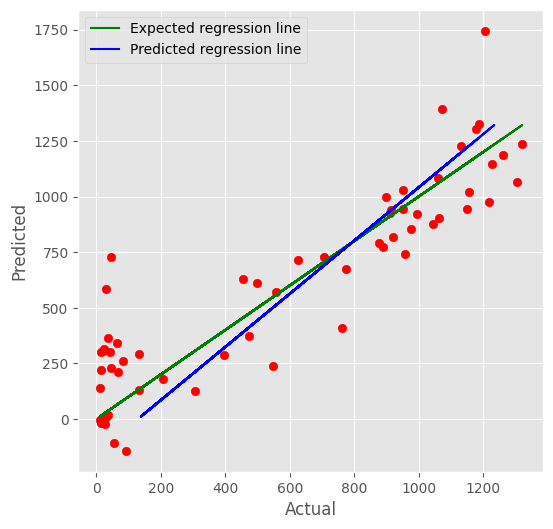

Các bước sóng giữ lại: [18, 78, 88, 170, 55, 58, 218, 159, 68, 133, 20, 202, 82, 57, 40, 94, 172, 79, 76, 203, 101, 160, 92, 217, 219, 53, 192, 23, 85, 87, 148, 213, 106, 149, 167, 80, 10, 17, 198, 8, 109, 33, 151, 95, 41, 100, 116, 179, 37, 63, 111, 91, 188, 98, 13, 45, 44, 164, 51, 59, 27, 90, 189, 178, 35, 169, 152, 112, 36, 60, 104, 110, 175, 26, 209, 190, 48, 165]
Phương trình chính quy: y = 585.482  + 182.33 * X_19 -118.29 * X_79 -59.654 * X_89 -223.021 * X_171  + 21.987 * X_56  + 209.825 * X_59  + 55.926 * X_219  + 99.326 * X_160 -131.317 * X_69  + 176.866 * X_134 -31.74 * X_21 -102.981 * X_203 -160.298 * X_83  + 7.307 * X_58 -181.516 * X_41  + 123.271 * X_95  + 132.532 * X_173 -97.939 * X_80 -25.176 * X_77 -58.334 * X_204 -102.836 * X_102  + 58.698 * X_161 -136.915 * X_93  + 96.495 * X_218 -12.154 * X_220 -60.183 * X_54 -88.385 * X_193 -113.043 * X_24 -217.178 * X_86 -172.665 * X_88 -89.898 * X_149  + 55.576 * X_214  + 70.334 * X_107 -189.924 * X_150  + 25.625 * X_168 -54.901 *

In [7]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  29
Number Wavelengths remove:  154
MSE min:  51070.85399773248

R2 calib: 0.999
R2 CV: 0.771
MSE calib: 132.316
MSE CV: 51070.854


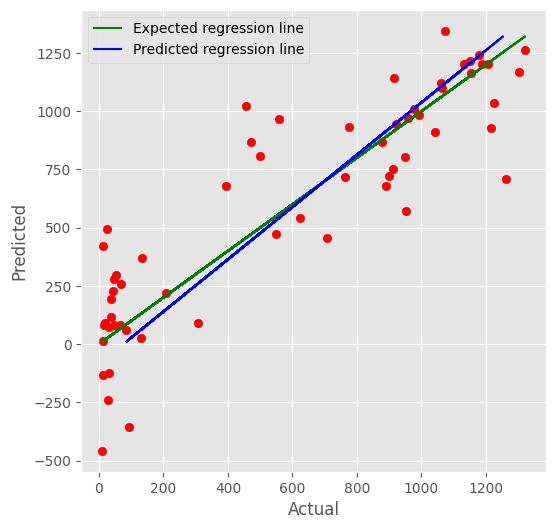

Các bước sóng giữ lại: [184, 41, 193, 85, 195, 109, 88, 54, 8, 201, 185, 165, 145, 198, 194, 97, 58, 9, 181, 48, 84, 133, 44, 32, 186, 166, 93, 108, 103, 171, 209, 39, 200, 175, 98, 107, 10, 197, 31, 187, 78, 111, 60, 72, 163, 26, 203, 43, 15, 50, 207, 177, 112, 14, 61, 160, 34, 57, 113, 114, 116, 190, 96, 115, 157, 202, 86, 161, 56, 204, 176, 188, 208, 162]
Phương trình chính quy: y = 585.991 -145.952 * X_185 -124.166 * X_42  + 76.219 * X_194 -162.676 * X_86  + 129.81 * X_196 -121.544 * X_110 -129.401 * X_89  + 88.415 * X_55  + 33.804 * X_9  + 164.405 * X_202  + 38.773 * X_186 -90.822 * X_166  + 268.424 * X_146 -46.16 * X_199 -97.056 * X_195  + 176.84 * X_98  + 49.336 * X_59 -126.556 * X_10 -147.862 * X_182  + 147.084 * X_49  + 120.911 * X_85  + 286.604 * X_134 -0.803 * X_45 -180.517 * X_33 -26.557 * X_187 -94.103 * X_167 -123.287 * X_94 -249.77 * X_109  + 108.563 * X_104 -192.903 * X_172 -18.621 * X_210  + 0.366 * X_40  + 112.131 * X_201  + 63.751 * X_176 -163.071 * X_99 -81.011 * X_

In [9]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'b']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  22
Number Wavelengths remove:  196
MSE min:  71984.6586665162

R2 calib: 0.946
R2 CV: 0.677
MSE calib: 11965.283
MSE CV: 71984.659


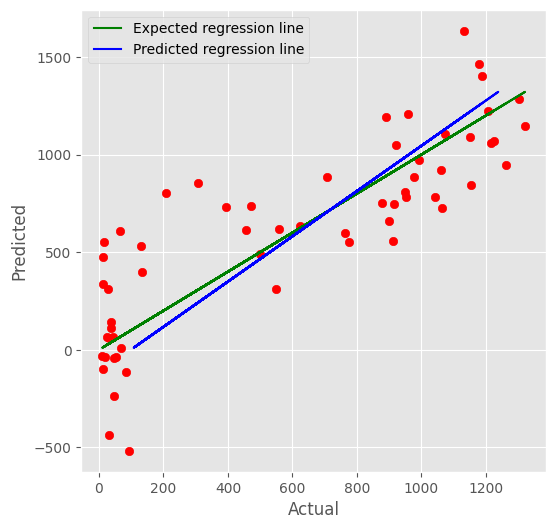

Các bước sóng giữ lại: [219, 31, 95, 192, 151, 210, 195, 34, 209, 175, 84, 169, 10, 13, 36, 72, 152, 183, 167, 43, 48, 21, 161, 179, 46, 208, 197, 8, 50, 205, 16, 165]
Phương trình chính quy: y = 585.881 -129.078 * X_220  + 76.179 * X_32 -557.295 * X_96 -879.85 * X_193  + 181.628 * X_152  + 213.605 * X_211  + 389.848 * X_196  + 100.409 * X_35  + 53.979 * X_210 -95.086 * X_176 -361.155 * X_85 -543.046 * X_170  + 101.219 * X_11 -14.62 * X_14 -402.622 * X_37 -172.157 * X_73 -834.216 * X_153 -451.732 * X_184  + 648.765 * X_168  + 390.317 * X_44  + 303.924 * X_49 -193.851 * X_22 -334.44 * X_162  + 1.993 * X_180 -443.756 * X_47 -495.426 * X_209 -137.032 * X_198 -502.918 * X_9  + 149.852 * X_51 -125.024 * X_206 -322.182 * X_17 -285.927 * X_166 


In [10]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'c']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  20
Number Wavelengths remove:  179
MSE min:  121898.34627879872

R2 calib: 0.935
R2 CV: 0.453
MSE calib: 14514.182
MSE CV: 121898.346


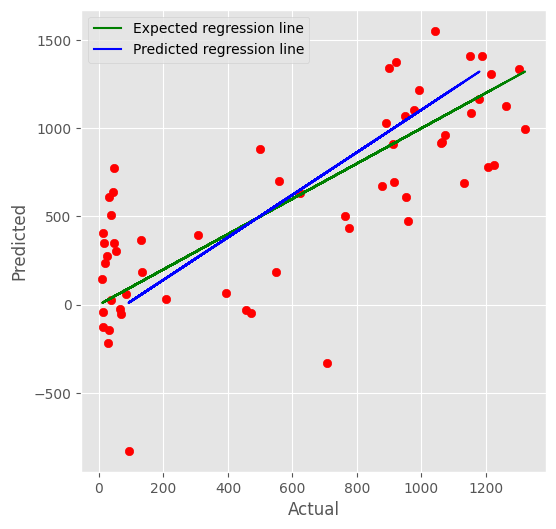

Các bước sóng giữ lại: [122, 89, 85, 36, 51, 95, 83, 29, 120, 184, 183, 23, 113, 164, 101, 15, 53, 119, 39, 166, 211, 12, 49, 104, 198, 115, 117, 206, 190, 35, 175, 30, 173, 213, 48, 212, 163, 10, 9, 179, 61, 178, 8, 25, 203, 17, 26, 16, 195]
Phương trình chính quy: y = 587.703  + 841.12 * X_123 -521.083 * X_90  + 37.168 * X_86 -334.352 * X_37 -15.074 * X_52  + 24.947 * X_96 -284.734 * X_84  + 107.034 * X_30  + 367.258 * X_121 -499.022 * X_185 -101.633 * X_184 -210.939 * X_24  + 762.297 * X_114 -343.413 * X_165 -433.713 * X_102  + 68.841 * X_16 -270.516 * X_54  + 132.777 * X_120  + 145.038 * X_40  + 36.629 * X_167  + 179.203 * X_212 -143.54 * X_13  + 519.617 * X_50  + 75.623 * X_105  + 59.402 * X_199 -327.044 * X_116 -358.012 * X_118 -287.271 * X_207  + 34.399 * X_191  + 437.851 * X_36 -569.415 * X_176  + 47.077 * X_31 -341.652 * X_174  + 492.093 * X_214 -73.612 * X_49  + 155.283 * X_213 -228.67 * X_164 -360.758 * X_11 -31.113 * X_10  + 275.005 * X_180 -363.48 * X_62  + 86.043 * X_179 

In [11]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  17
Number Wavelengths remove:  201
MSE min:  86972.20562516937

R2 calib: 0.846
R2 CV: 0.610
MSE calib: 34277.343
MSE CV: 86972.206


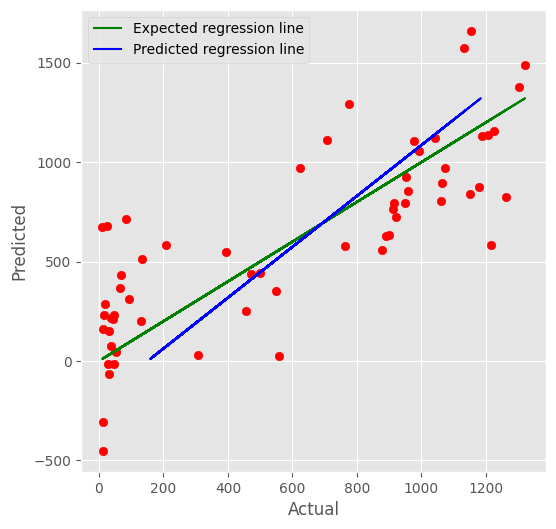

Các bước sóng giữ lại: [117, 76, 142, 26, 46, 191, 35, 218, 90, 194, 175, 182, 173, 201, 214, 211, 151, 81, 85, 200, 47, 80, 83, 14, 203, 31, 88]
Phương trình chính quy: y = 585.713 -205.082 * X_118 -450.483 * X_77  + 456.182 * X_143 -497.757 * X_27 -71.269 * X_47  + 503.205 * X_192 -540.161 * X_36  + 135.308 * X_219 -276.989 * X_91  + 25.366 * X_195 -42.728 * X_176  + 182.393 * X_183  + 71.96 * X_174 -86.134 * X_202 -168.27 * X_215  + 5.334 * X_212  + 13.012 * X_152 -174.148 * X_82 -420.741 * X_86  + 451.831 * X_201 -74.087 * X_48 -410.536 * X_81  + 421.738 * X_84  + 330.747 * X_15 -431.094 * X_204  + 577.989 * X_32 -520.147 * X_89 


In [12]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'e']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  11
Number Wavelengths remove:  150
MSE min:  162578.25869021838

R2 calib: 0.848
R2 CV: 0.270
MSE calib: 33759.454
MSE CV: 162578.259


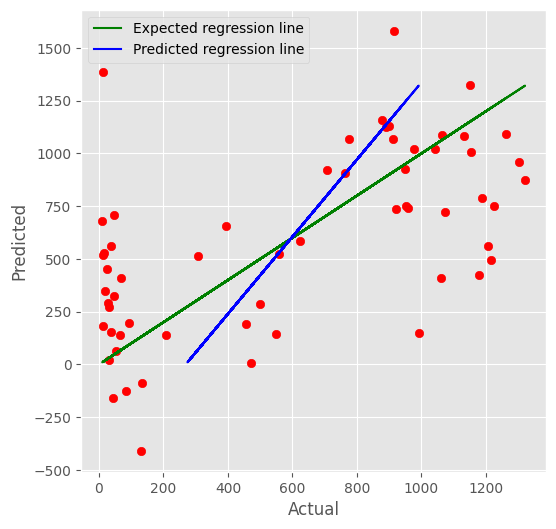

Các bước sóng giữ lại: [225, 226, 227, 111, 160, 136, 137, 97, 132, 127, 162, 183, 134, 51, 80, 28, 10, 201, 95, 122, 148, 159, 197, 47, 133, 116, 151, 177, 135, 96, 156, 31, 25, 126, 115, 209, 92, 190, 166, 124, 198, 125, 165, 155, 49, 123, 50, 205, 114, 147, 84, 145, 48, 216, 181, 199, 207, 195, 175, 26, 81, 202, 189, 217, 149, 178, 29, 179, 168, 213, 169, 218, 180, 196, 191, 172, 173, 174]
Phương trình chính quy: y = 589.212 -124.404 * X_226 -124.404 * X_227 -124.404 * X_228  + 66.844 * X_112 -10.601 * X_161  + 48.508 * X_137  + 47.911 * X_138 -26.051 * X_98  + 46.123 * X_133 -52.836 * X_128 -54.9 * X_163  + 27.177 * X_184  + 50.488 * X_135  + 67.797 * X_52  + 142.674 * X_81  + 73.162 * X_29  + 220.507 * X_11  + 77.623 * X_202 -49.891 * X_96 -58.33 * X_123  + 69.918 * X_149 -57.055 * X_160  + 33.392 * X_198  + 73.965 * X_48  + 57.725 * X_134  + 56.412 * X_117  + 73.732 * X_152  + 46.522 * X_178  + 63.444 * X_136 -42.723 * X_97 -40.05 * X_157  + 96.466 * X_32  + 57.593 * X_26 -73.003

In [13]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'f']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  7
Number Wavelengths remove:  201
MSE min:  114152.62506005741

R2 calib: 0.669
R2 CV: 0.488
MSE calib: 73796.841
MSE CV: 114152.625


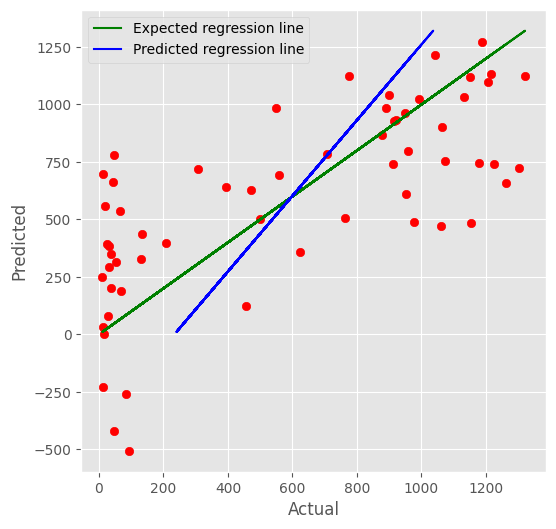

Các bước sóng giữ lại: [48, 38, 91, 60, 28, 118, 85, 186, 72, 43, 24, 25, 27, 210, 64, 71, 39, 117, 26, 211, 37, 40, 61, 42, 41, 63, 62]
Phương trình chính quy: y = 586.344  + 201.299 * X_49  + 10.956 * X_39 -260.204 * X_92  + 94.245 * X_61  + 31.224 * X_29 -54.098 * X_119 -87.422 * X_86 -329.628 * X_187  + 30.732 * X_73 -24.008 * X_44 -45.648 * X_25 -34.736 * X_26  + 24.782 * X_28 -130.678 * X_211  + 62.13 * X_65 -133.105 * X_72 -63.406 * X_40 -59.742 * X_118  + 173.338 * X_27  + 171.995 * X_212 -42.766 * X_38 -55.489 * X_41  + 95.743 * X_62 -102.044 * X_43 -49.465 * X_42  + 123.069 * X_64  + 159.554 * X_63 


In [14]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'g']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  14
Number Wavelengths remove:  198
MSE min:  122340.73008180628

R2 calib: 0.841
R2 CV: 0.451
MSE calib: 35414.854
MSE CV: 122340.730


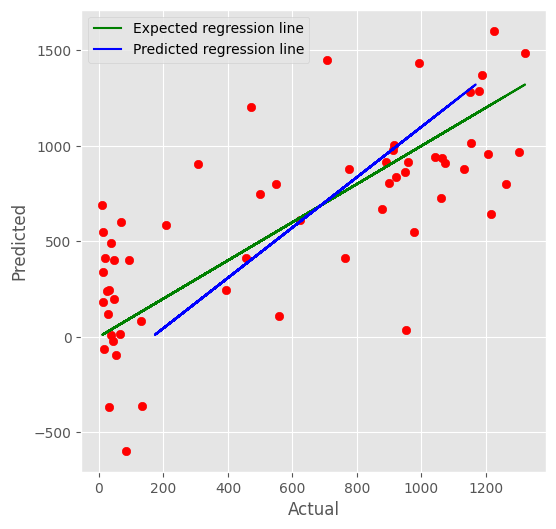

Các bước sóng giữ lại: [110, 213, 176, 86, 187, 113, 108, 136, 172, 185, 137, 166, 36, 24, 85, 71, 145, 210, 30, 35, 183, 162, 37, 60, 146, 202, 62, 61, 208, 171]
Phương trình chính quy: y = 587.743 -262.96 * X_111  + 116.878 * X_214 -517.536 * X_177 -220.461 * X_87  + 450.667 * X_188 -164.512 * X_114 -241.373 * X_109  + 267.93 * X_137 -105.885 * X_173 -193.9 * X_186  + 348.855 * X_138 -273.241 * X_167 -183.651 * X_37  + 377.811 * X_25 -60.312 * X_86 -477.749 * X_72 -56.755 * X_146 -248.255 * X_211  + 150.859 * X_31 -275.984 * X_36 -47.146 * X_184 -472.17 * X_163  + 40.762 * X_38  + 184.15 * X_61 -263.636 * X_147 -318.33 * X_203  + 252.978 * X_63  + 293.163 * X_62 -98.856 * X_209 -10.287 * X_172 


In [15]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  21
Number Wavelengths remove:  197
MSE min:  455.0407847507586

R2 calib: 1.000
R2 CV: 0.952
MSE calib: 1.324
MSE CV: 455.041


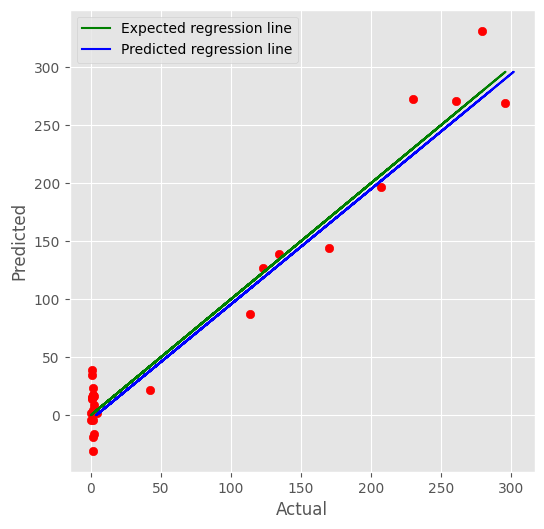

Phương trình chính quy: y = 63.013 -15.479 * X_195 -25.427 * X_105 -3.549 * X_44  + 25.035 * X_201 -18.604 * X_19 -20.26 * X_182  + 23.046 * X_196 -1.966 * X_92 -6.381 * X_197  + 1.026 * X_212 -38.158 * X_72  + 16.589 * X_174 -26.624 * X_28 -10.959 * X_211 -33.613 * X_95 -32.609 * X_21 -14.78 * X_162 -8.849 * X_48 -12.545 * X_11 -6.606 * X_46  + 28.625 * X_9  + 24.667 * X_214  + 0.097 * X_24  + 5.31 * X_86 -2.984 * X_31 -14.281 * X_164  + 34.838 * X_47 -28.561 * X_183 -18.292 * X_22 -5.468 * X_161 -42.718 * X_220 


In [16]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  17
Number Wavelengths remove:  191
MSE min:  1277.827772832207

R2 calib: 0.999
R2 CV: 0.866
MSE calib: 4.832
MSE CV: 1277.828


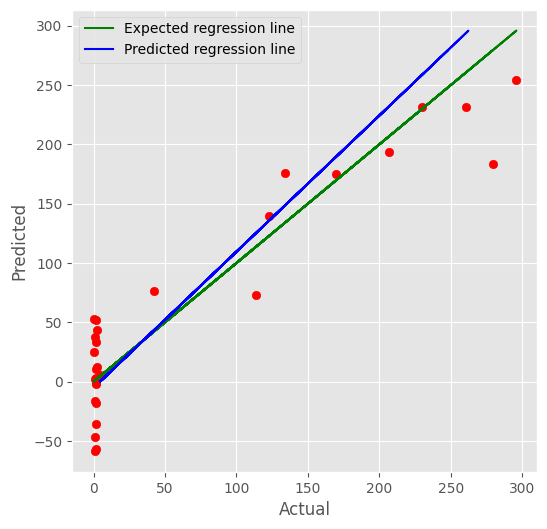

Phương trình chính quy: y = 62.982 -21.388 * X_38  + 21.594 * X_166 -42.132 * X_65  + 12.132 * X_215 -16.311 * X_35  + 14.052 * X_202  + 4.356 * X_204  + 20.379 * X_212 -11.678 * X_182  + 5.36 * X_193 -0.388 * X_77  + 2.75 * X_14 -9.161 * X_97 -16.525 * X_41 -38.992 * X_169 -7.796 * X_46  + 22.096 * X_17 -36.52 * X_49  + 2.588 * X_220  + 21.952 * X_170  + 23.391 * X_12 -29.451 * X_40  + 6.958 * X_195  + 25.62 * X_183  + 4.945 * X_48  + 20.377 * X_56 -3.263 * X_163  + 22.038 * X_13 -6.949 * X_86 -3.64 * X_219  + 3.572 * X_27 -12.337 * X_32 -25.193 * X_87 -19.213 * X_196 -37.764 * X_192 -33.774 * X_190 -16.642 * X_197 


In [17]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'b']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  15
Number Wavelengths remove:  167
MSE min:  799.6136744539913

R2 calib: 1.000
R2 CV: 0.916
MSE calib: 0.378
MSE CV: 799.614


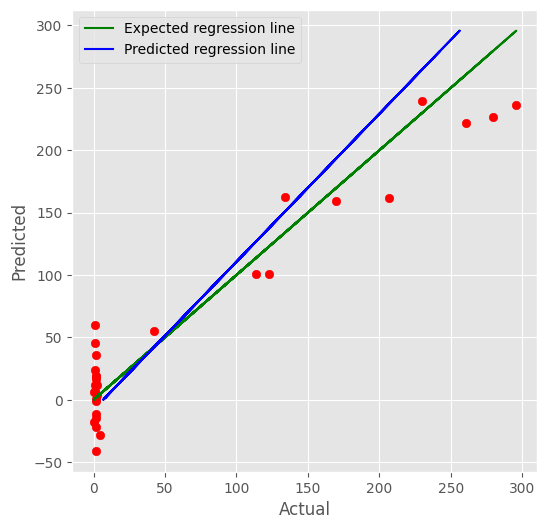

Phương trình chính quy: y = 62.844 -3.224 * X_19 -14.782 * X_199 -6.706 * X_87  + 7.722 * X_76 -4.337 * X_20 -0.346 * X_43 -6.583 * X_81 -8.195 * X_108  + 10.363 * X_135  + 9.057 * X_71  + 2.07 * X_103  + 6.102 * X_73  + 2.784 * X_159  + 5.439 * X_218 -15.096 * X_27 -7.144 * X_21 -7.284 * X_82 -11.711 * X_193 -9.844 * X_198  + 9.086 * X_36  + 4.012 * X_102 -7.756 * X_33  + 5.309 * X_188  + 5.103 * X_23  + 8.104 * X_51  + 8.877 * X_10  + 5.562 * X_24  + 10.423 * X_187 -6.7 * X_97  + 6.086 * X_134 -11.499 * X_110  + 1.437 * X_178  + 9.619 * X_72 -7.038 * X_95 -7.921 * X_113 -6.709 * X_83  + 1.801 * X_25  + 12.576 * X_46 -4.731 * X_14  + 9.586 * X_45  + 0.784 * X_133  + 10.198 * X_12  + 9.535 * X_160 -12.048 * X_114 -8.353 * X_49  + 9.478 * X_176 -7.087 * X_165  + 13.383 * X_157  + 13.418 * X_35 -8.139 * X_118 -7.655 * X_94  + 14.096 * X_54  + 3.803 * X_186 -5.994 * X_211 -13.315 * X_13  + 18.209 * X_53  + 18.54 * X_175  + 9.491 * X_11 -12.853 * X_30 -11.063 * X_96 -21.311 * X_31 


In [18]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'c']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  19
Number Wavelengths remove:  187
MSE min:  278.36295582450487

R2 calib: 1.000
R2 CV: 0.971
MSE calib: 1.067
MSE CV: 278.363


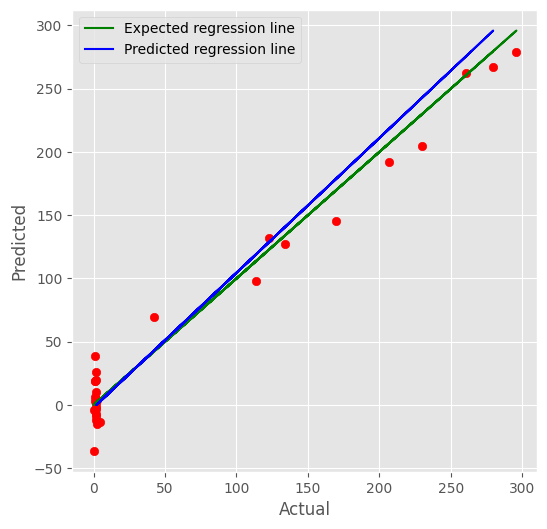

Phương trình chính quy: y = 63.285 -22.847 * X_195  + 17.58 * X_73 -19.376 * X_75 -13.367 * X_227 -13.367 * X_222 -13.367 * X_223 -13.367 * X_224 -13.367 * X_225 -13.367 * X_226 -13.367 * X_228 -13.367 * X_221 -12.739 * X_42  + 17.258 * X_45 -7.468 * X_187  + 18.182 * X_167 -23.854 * X_113  + 10.501 * X_165  + 19.162 * X_166 -27.869 * X_194  + 5.03 * X_51  + 29.492 * X_38 -34.957 * X_160 -44.71 * X_30 -4.652 * X_28  + 29.702 * X_25 -14.741 * X_79  + 10.095 * X_13 -19.165 * X_22  + 5.575 * X_86 -6.912 * X_192 -19.601 * X_189 -25.012 * X_190  + 38.445 * X_39 -14.266 * X_48 -0.736 * X_88 -22.904 * X_191 -28.472 * X_54  + 24.518 * X_37 -19.554 * X_11 -18.472 * X_193 -24.245 * X_161 


In [19]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  19
Number Wavelengths remove:  188
MSE min:  878.9230089340159

R2 calib: 1.000
R2 CV: 0.908
MSE calib: 1.325
MSE CV: 878.923


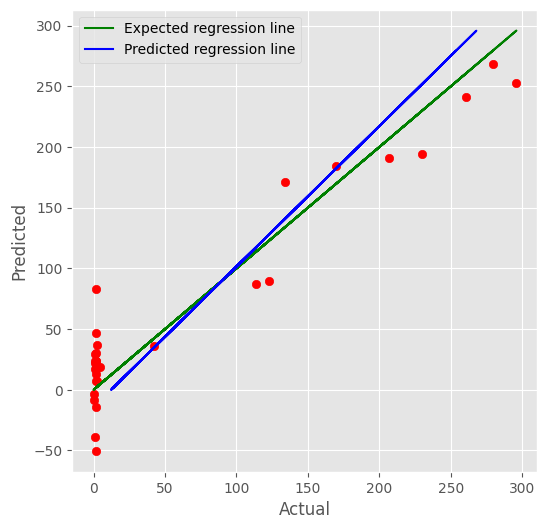

Phương trình chính quy: y = 62.909 -17.759 * X_159 -12.711 * X_178  + 15.17 * X_62  + 5.543 * X_16  + 35.821 * X_93 -6.796 * X_190 -4.925 * X_177 -27.964 * X_146  + 0.335 * X_21  + 12.594 * X_18 -9.435 * X_148 -13.741 * X_121  + 1.198 * X_173  + 8.105 * X_171 -2.624 * X_196  + 7.525 * X_154  + 20.438 * X_211 -6.226 * X_186 -18.385 * X_12  + 0.97 * X_204  + 10.272 * X_15  + 2.814 * X_162 -9.084 * X_120  + 13.989 * X_219  + 2.922 * X_19  + 9.903 * X_153 -15.949 * X_202 -37.986 * X_26  + 9.173 * X_197 -18.537 * X_118  + 7.692 * X_20 -9.364 * X_183  + 25.812 * X_217 -14.277 * X_169 -13.578 * X_182 -8.161 * X_181 -25.424 * X_119  + 10.789 * X_194  + 14.689 * X_170  + 30.979 * X_192 


In [20]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'e']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  26
Number Wavelengths remove:  188
MSE min:  526.0288354666177

R2 calib: 1.000
R2 CV: 0.945
MSE calib: 0.000
MSE CV: 526.029


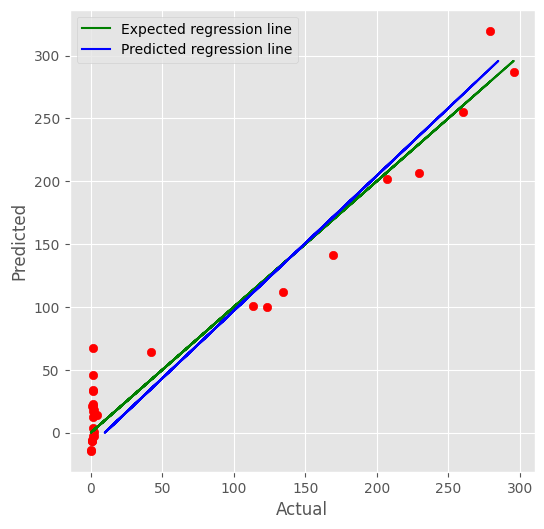

Phương trình chính quy: y = 62.992 -7.505 * X_21  + 11.982 * X_157  + 14.697 * X_18 -11.289 * X_150 -5.189 * X_51  + 14.665 * X_52  + 8.597 * X_37 -12.75 * X_120 -16.743 * X_95 -10.187 * X_75 -4.227 * X_151  + 1.691 * X_148 -22.801 * X_79 -1.699 * X_45  + 8.977 * X_9 -5.547 * X_169 -9.197 * X_23 -17.275 * X_175 -15.416 * X_183  + 4.811 * X_20 -8.645 * X_86 -1.459 * X_177  + 4.155 * X_19  + 5.101 * X_214 -21.599 * X_164 -13.561 * X_182  + 27.963 * X_101  + 14.065 * X_24 -11.11 * X_161  + 23.184 * X_215 -11.61 * X_189  + 5.438 * X_26  + 15.917 * X_25  + 25.14 * X_27 -11.047 * X_181  + 11.139 * X_10  + 23.669 * X_11  + 31.471 * X_12  + 22.673 * X_170 -26.05 * X_180 


In [21]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'f']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  6
Number Wavelengths remove:  197
MSE min:  3503.499806170311

R2 calib: 0.948
R2 CV: 0.634
MSE calib: 492.845
MSE CV: 3503.500


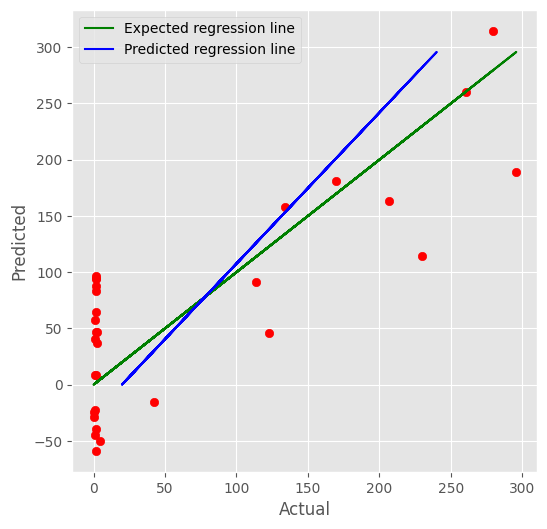

Phương trình chính quy: y = 62.827  + 23.812 * X_206 -33.572 * X_94  + 7.454 * X_199 -9.996 * X_182 -8.787 * X_192 -37.644 * X_187  + 1.811 * X_154  + 9.947 * X_207 -8.455 * X_194  + 14.992 * X_172  + 8.804 * X_86  + 16.443 * X_173  + 8.805 * X_217 -11.526 * X_159 -16.094 * X_209  + 5.863 * X_198  + 11.604 * X_201 -3.719 * X_180  + 0.896 * X_12 -18.763 * X_212 -17.404 * X_160  + 24.55 * X_14  + 33.802 * X_167  + 9.349 * X_216 -0.35 * X_202  + 30.165 * X_87 -26.052 * X_210 -17.613 * X_82  + 9.62 * X_13 -22.712 * X_81 -15.102 * X_181 


In [22]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'g']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  13
Number Wavelengths remove:  178
MSE min:  4144.398107508987

R2 calib: 0.999
R2 CV: 0.567
MSE calib: 12.005
MSE CV: 4144.398


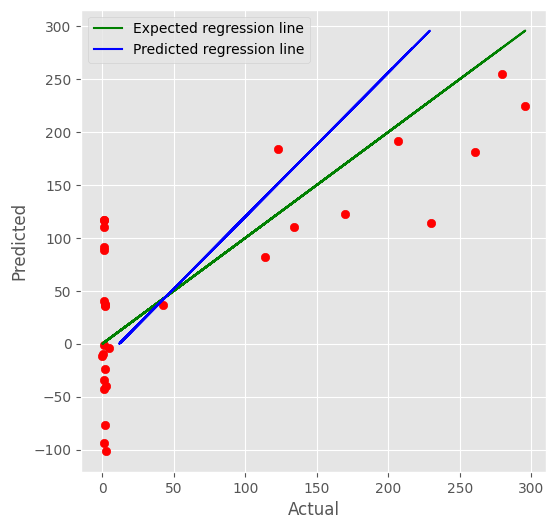

Phương trình chính quy: y = 63.219 -25.932 * X_97  + 16.029 * X_27 -29.286 * X_36  + 26.034 * X_20 -22.685 * X_110  + 10.635 * X_82  + 7.751 * X_83 -6.441 * X_176  + 25.154 * X_63 -2.342 * X_148 -27.796 * X_111  + 10.61 * X_214  + 5.982 * X_178 -5.769 * X_212  + 2.996 * X_86  + 3.743 * X_169 -7.178 * X_13  + 10.459 * X_191 -14.899 * X_209  + 21.875 * X_165  + 1.005 * X_199  + 9.478 * X_12  + 6.9 * X_211 -7.702 * X_16 -16.072 * X_197 -21.281 * X_202 -27.906 * X_15  + 1.115 * X_81  + 9.488 * X_188  + 14.958 * X_180  + 30.98 * X_23  + 6.554 * X_216  + 32.253 * X_156  + 9.7 * X_203 -26.815 * X_193 -14.422 * X_198  + 24.209 * X_219  + 18.177 * X_152  + 14.7 * X_190  + 18.247 * X_217  + 14.452 * X_215 -28.907 * X_162  + 17.736 * X_149 -8.498 * X_154  + 15.013 * X_208 -21.684 * X_85 -31.621 * X_84  + 23.949 * X_213 -29.304 * X_14  + 12.705 * X_155 


In [23]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  37
Number Wavelengths remove:  187
MSE min:  84928.33683807164

R2 calib: 0.958
R2 CV: 0.619
MSE calib: 9307.839
MSE CV: 84928.337


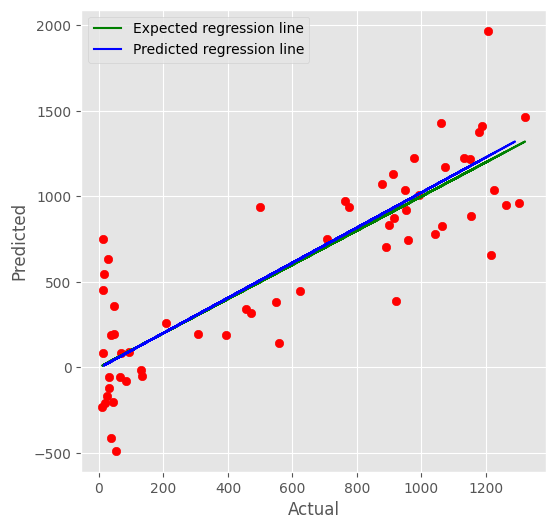

Phương trình chính quy: y = 586.898 -972.561 * X_68  + 373.174 * X_216 -501.054 * X_46 -735.855 * X_151  + 348.144 * X_193 -845.254 * X_102 -171.942 * X_210  + 1081.804 * X_146 -285.515 * X_85 -104.874 * X_47  + 508.546 * X_200  + 170.22 * X_36  + 302.695 * X_184 -547.146 * X_152 -262.035 * X_212 -222.586 * X_54  + 240.228 * X_48 -253.649 * X_202  + 777.469 * X_169 -418.579 * X_23 -268.538 * X_181  + 492.467 * X_43  + 0.747 * X_44 -37.026 * X_205 -113.171 * X_162 -545.721 * X_207  + 728.995 * X_63  + 125.854 * X_101  + 53.867 * X_150  + 173.275 * X_189 -172.287 * X_38  + 843.677 * X_219 -284.047 * X_42 -472.591 * X_203 -204.237 * X_198  + 198.849 * X_28 -863.925 * X_220  + 559.937 * X_191  + 228.856 * X_14 -1218.544 * X_170 -423.543 * X_209 


In [24]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/his/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  19
Number Wavelengths remove:  183
MSE min:  79507.47038798394

R2 calib: 0.959
R2 CV: 0.643
MSE calib: 9028.176
MSE CV: 79507.470


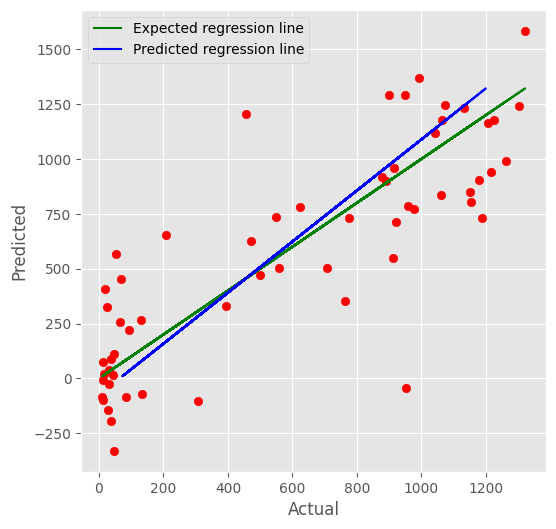

Phương trình chính quy: y = 584.639 -256.45 * X_169 -253.213 * X_147  + 456.321 * X_116  + 168.092 * X_220 -72.203 * X_170  + 188.354 * X_183  + 499.361 * X_39  + 162.524 * X_48 -19.345 * X_186  + 489.418 * X_115 -41.031 * X_171 -104.148 * X_149 -301.534 * X_86 -289.594 * X_33 -596.971 * X_120 -81.427 * X_160 -283.751 * X_208 -181.628 * X_204 -208.424 * X_155 -124.214 * X_176 -568.656 * X_119 -325.566 * X_154  + 44.418 * X_210  + 113.467 * X_85  + 375.676 * X_150 -52.135 * X_15 -294.805 * X_42 -469.741 * X_43 -317.904 * X_195  + 385.106 * X_218 -57.427 * X_159 -408.123 * X_214 -303.042 * X_199 -214.233 * X_88  + 197.769 * X_219  + 418.545 * X_146  + 165.333 * X_178  + 51.084 * X_192  + 244.803 * X_196 -437.94 * X_184  + 161.228 * X_27 -263.654 * X_207  + 248.215 * X_185  + 462.122 * X_212 -442.182 * X_215 


In [25]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/his/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  22
Number Wavelengths remove:  179
MSE min:  633.3783124570822

R2 calib: 0.969
R2 CV: 0.932
MSE calib: 283.941
MSE CV: 633.378


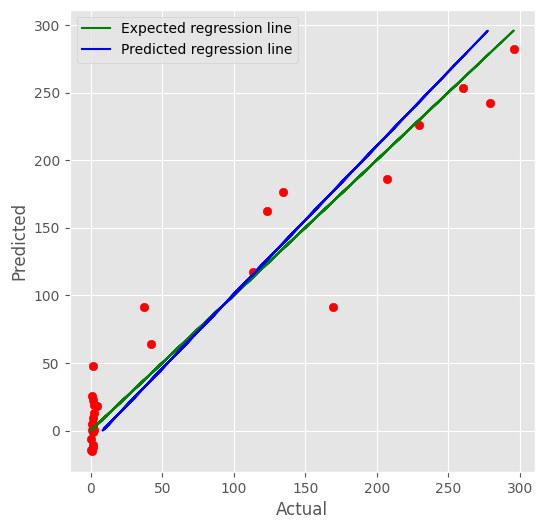

Phương trình chính quy: y = 62.005  + 10.224 * X_33 -2.504 * X_115  + 10.996 * X_121 -4.454 * X_199  + 8.012 * X_133  + 14.041 * X_62  + 11.264 * X_211 -2.299 * X_168  + 6.281 * X_16 -2.679 * X_101  + 4.078 * X_163  + 5.514 * X_15 -6.276 * X_119 -9.647 * X_19 -8.287 * X_194 -3.742 * X_198 -4.663 * X_116 -3.511 * X_88  + 1.391 * X_169  + 16.068 * X_203 -3.357 * X_27  + 11.531 * X_174 -3.934 * X_94 -4.874 * X_170 -14.721 * X_29 -7.408 * X_117 -9.398 * X_182  + 13.979 * X_185 -9.976 * X_98  + 10.748 * X_187 -7.288 * X_100 -12.71 * X_95 -11.509 * X_96 -14.796 * X_97 -7.38 * X_87  + 13.51 * X_186 -12.579 * X_165 -5.491 * X_164 -10.135 * X_118 -16.073 * X_20 -6.242 * X_192 -13.976 * X_49 -13.71 * X_21  + 22.525 * X_37 -9.651 * X_31 -10.827 * X_197 -9.187 * X_22 -16.218 * X_30 -23.544 * X_196 


In [26]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/his/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  11
Number Wavelengths remove:  150
MSE min:  2648.9474750720647

R2 calib: 0.966
R2 CV: 0.714
MSE calib: 312.868
MSE CV: 2648.947


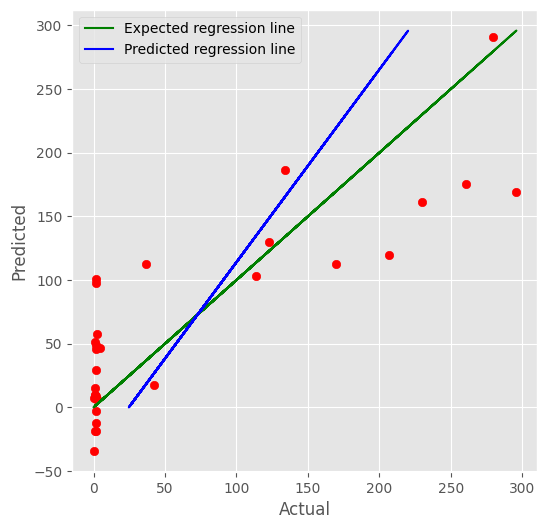

Phương trình chính quy: y = 62.055  + 4.973 * X_6  + 4.973 * X_5  + 4.973 * X_4  + 4.973 * X_3  + 4.973 * X_2  + 4.973 * X_1  + 4.973 * X_8  + 2.292 * X_203  + 4.605 * X_106  + 4.928 * X_107  + 1.232 * X_154 -4.9 * X_129 -6.916 * X_77 -5.38 * X_167 -3.539 * X_130 -5.318 * X_49  + 2.993 * X_191  + 5.403 * X_80  + 5.071 * X_105 -6.075 * X_212  + 4.992 * X_172  + 5.29 * X_139  + 7.093 * X_141  + 7.512 * X_103  + 8.447 * X_13 -6.679 * X_83 -0.853 * X_131 -5.341 * X_194 -6.203 * X_192 -4.009 * X_89  + 8.268 * X_19  + 6.931 * X_109 -10.349 * X_189  + 7.149 * X_23 -3.239 * X_178  + 5.91 * X_27 -8.898 * X_195 -5.299 * X_48  + 6.629 * X_11  + 8.955 * X_22  + 8.319 * X_165 -3.555 * X_196  + 1.189 * X_217  + 8.381 * X_10 -6.077 * X_175  + 4.504 * X_204 -8.539 * X_84  + 4.828 * X_201 -5.21 * X_182  + 9.438 * X_21  + 11.286 * X_207  + 7.683 * X_110  + 6.489 * X_166  + 9.03 * X_152 -13.116 * X_181 -9.443 * X_50 -14.124 * X_86  + 5.598 * X_25  + 9.285 * X_12 -9.461 * X_85  + 6.726 * X_197  + 11.806 *

In [27]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/his/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  8
Number Wavelengths remove:  199
MSE min:  43033.396118836354

R2 calib: 1.000
R2 CV: 0.723
MSE calib: 0.350
MSE CV: 43033.396


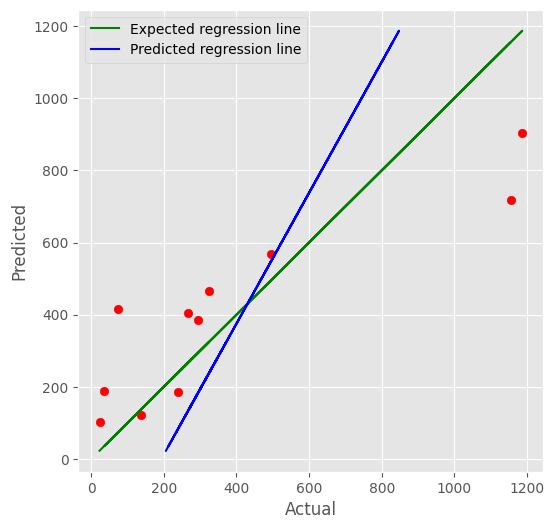

Phương trình chính quy: y = 384.638  + 56.527 * X_113  + 61.727 * X_112  + 27.308 * X_155 -56.268 * X_48  + 51.25 * X_64  + 68.5 * X_111  + 31.301 * X_177  + 47.119 * X_24 -95.035 * X_133  + 40.739 * X_70  + 35.288 * X_65  + 10.791 * X_36 -39.559 * X_50  + 17.812 * X_209 -36.902 * X_173 -34.047 * X_40  + 25.067 * X_9  + 56.287 * X_23  + 97.67 * X_190 -39.317 * X_185  + 92.24 * X_203 -90.558 * X_171  + 62.844 * X_22 -58.125 * X_186  + 58.726 * X_10  + 21.468 * X_33 -75.37 * X_172 -73.395 * X_184  + 102.72 * X_11 


In [37]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  8
Number Wavelengths remove:  199
MSE min:  43033.396118836354

R2 calib: 1.000
R2 CV: 0.723
MSE calib: 0.350
MSE CV: 43033.396


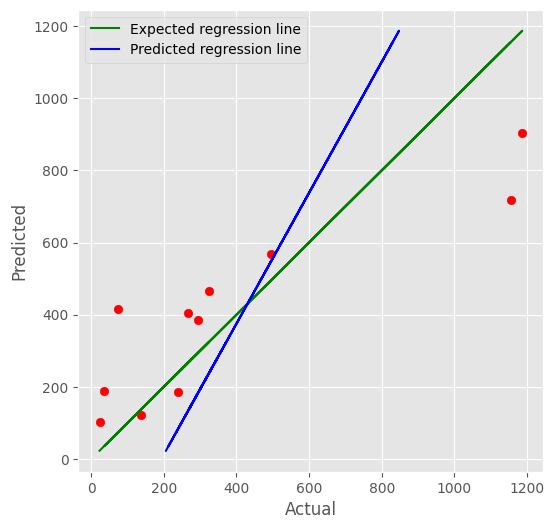

Phương trình chính quy: y = 384.638  + 56.527 * X_113  + 61.727 * X_112  + 27.308 * X_155 -56.268 * X_48  + 51.25 * X_64  + 68.5 * X_111  + 31.301 * X_177  + 47.119 * X_24 -95.035 * X_133  + 40.739 * X_70  + 35.288 * X_65  + 10.791 * X_36 -39.559 * X_50  + 17.812 * X_209 -36.902 * X_173 -34.047 * X_40  + 25.067 * X_9  + 56.287 * X_23  + 97.67 * X_190 -39.317 * X_185  + 92.24 * X_203 -90.558 * X_171  + 62.844 * X_22 -58.125 * X_186  + 58.726 * X_10  + 21.468 * X_33 -75.37 * X_172 -73.395 * X_184  + 102.72 * X_11 


In [38]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


[0.0 0.0 3.01 4.33 6.0 2.67 2.99 4.33 3.01 64.86 6.33 1.99 0.0 2.65 32.43
 6.29 3.99 11.64 9.28 4.86 1.37 4.17 4.21 2.99 9.58 2.8 9.22 1.52 4.09
 5.31 2.32 2.22 8.68 3.73 2.19 4.55 2.22 36.97 2295.69 1678.06 13.83 68.69
 632.59 1.99 54.91 1712.48 2413.85 1769.52 1447.93 1319.94 136.54 2603.52
 2.01 62.5 0.0 4.05 12.08 77.26 2.03 8.11 2642.45 2366.45 815.2 459.17
 2960.83 2107.1 2493.6 2385.66 1481.45 56.95 2.03 272.73 1139.54 40.03
 2564.88 3132.55 4.07 52.93]
[[0.00000000e+00]
 [0.00000000e+00]
 [9.60878518e-04]
 [1.38226046e-03]
 [1.91537246e-03]
 [8.52340745e-04]
 [9.54493943e-04]
 [1.38226046e-03]
 [9.60878518e-04]
 [2.07051763e-02]
 [2.02071795e-03]
 [6.35265199e-04]
 [0.00000000e+00]
 [8.45956170e-04]
 [1.03525881e-02]
 [2.00794880e-03]
 [1.27372269e-03]
 [3.71582257e-03]
 [2.96244274e-03]
 [1.55145169e-03]
 [4.37343378e-04]
 [1.33118386e-03]
 [1.34395301e-03]
 [9.54493943e-04]
 [3.05821136e-03]
 [8.93840481e-04]
 [2.94328901e-03]
 [4.85227690e-04]
 [1.30564556e-03]
 [1.69510463e

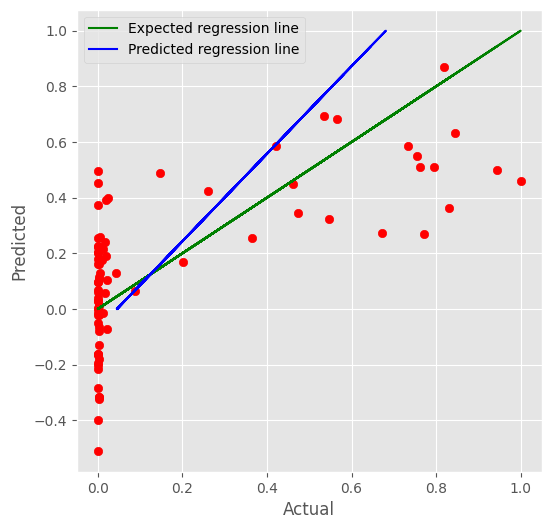

Các bước sóng giữ lại: [49, 51, 112, 92, 189, 113, 48, 31, 208, 193, 192, 93, 54, 133, 132, 167, 179, 117, 95, 218, 197, 21, 168, 190, 203, 100, 98, 32, 116, 114, 195, 35, 96, 34, 97, 33, 204, 115, 99, 194]
Phương trình chính quy: y = 0.17 -0.151 * X_50  + 0.114 * X_52 -0.007 * X_113 -0.066 * X_93  + 0.054 * X_190 -0.06 * X_114 -0.01 * X_49 -0.008 * X_32 -0.006 * X_209  + 0.049 * X_194  + 0.049 * X_193 -0.017 * X_94  + 0.228 * X_55  + 0.119 * X_134  + 0.052 * X_133 -0.164 * X_168 -0.075 * X_180  + 0.118 * X_118 -0.068 * X_96 -0.108 * X_219  + 0.018 * X_198 -0.147 * X_22 -0.083 * X_169  + 0.039 * X_191  + 0.007 * X_204 -0.068 * X_101  + 0.009 * X_99 -0.042 * X_33  + 0.094 * X_117 -0.008 * X_115  + 0.08 * X_196  + 0.103 * X_36  + 0.006 * X_97  + 0.107 * X_35 -0.098 * X_98  + 0.035 * X_34 -0.173 * X_205  + 0.101 * X_116 -0.052 * X_100  + 0.184 * X_195 


In [40]:
data1 = pd.read_csv("D:/NIR/Data/Histamin/His_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] > 1000].index)

y = np.array(data2.values[:,-3])
print(y)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape y thành một mảng 2D nếu cần
y_2d = np.array(y).reshape(-1, 1)

# Fit và transform dữ liệu y
y = scaler.fit_transform(y_2d)
print(y)



X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  7
Number Wavelengths remove:  202
MSE min:  48807.37730188141

R2 calib: 0.999
R2 CV: 0.686
MSE calib: 146.317
MSE CV: 48807.377


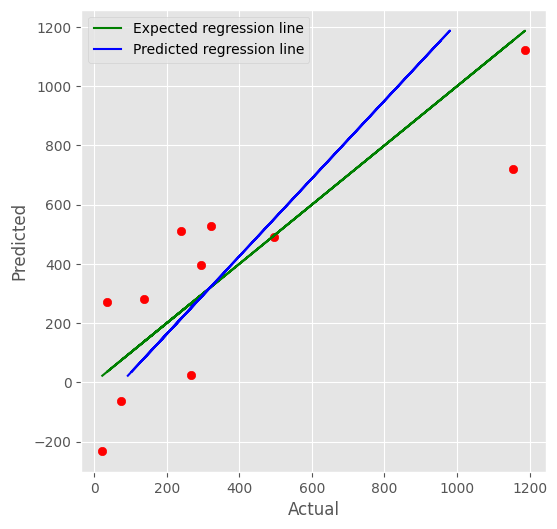

Phương trình chính quy: y = 384.833  + 60.135 * X_153  + 71.007 * X_217  + 49.817 * X_155  + 61.763 * X_215 -99.607 * X_177  + 60.628 * X_175 -75.677 * X_27  + 13.271 * X_109 -34.441 * X_134  + 39.184 * X_111 -41.874 * X_38  + 37.624 * X_110  + 60.42 * X_156  + 24.733 * X_12 -1.131 * X_98  + 25.668 * X_112 -21.185 * X_41 -42.85 * X_18 -29.032 * X_40  + 30.652 * X_113  + 28.598 * X_99 -45.609 * X_37 -82.065 * X_39 -42.135 * X_30 -109.39 * X_171  + 44.539 * X_114 


In [41]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'b']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  3
Number Wavelengths remove:  182
MSE min:  56709.79096809733

R2 calib: 0.958
R2 CV: 0.635
MSE calib: 6465.194
MSE CV: 56709.791


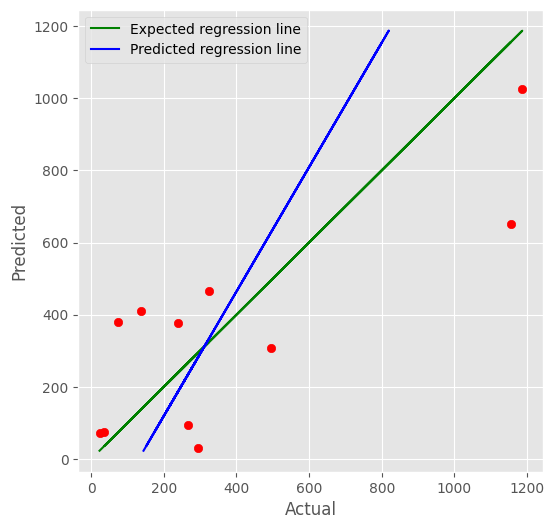

Phương trình chính quy: y = 384.407  + 27.488 * X_219 -7.07 * X_47 -26.575 * X_80 -4.021 * X_194  + 5.306 * X_190  + 0.213 * X_28  + 26.303 * X_116  + 26.884 * X_218  + 11.596 * X_38 -28.254 * X_83  + 21.542 * X_9  + 7.189 * X_15 -28.999 * X_84  + 28.27 * X_220  + 16.519 * X_42  + 25.743 * X_95  + 23.667 * X_62  + 10.939 * X_171 -0.394 * X_34 -12.833 * X_49 -19.478 * X_164 -0.302 * X_32  + 18.926 * X_201  + 7.128 * X_27  + 12.659 * X_18  + 19.097 * X_192  + 9.787 * X_189 -14.259 * X_161 -17.388 * X_162  + 3.677 * X_31  + 19.218 * X_14 -19.77 * X_163  + 13.651 * X_17 -16.146 * X_50  + 9.04 * X_35  + 23.11 * X_87  + 19.745 * X_179 -21.182 * X_183  + 16.392 * X_16  + 22.135 * X_204 -25.003 * X_174  + 38.314 * X_10  + 23.656 * X_202  + 22.317 * X_203  + 21.183 * X_30 -46.315 * X_186 


In [42]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'c']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  4
Number Wavelengths remove:  219
MSE min:  37481.503813127885

R2 calib: 0.915
R2 CV: 0.759
MSE calib: 13187.676
MSE CV: 37481.504


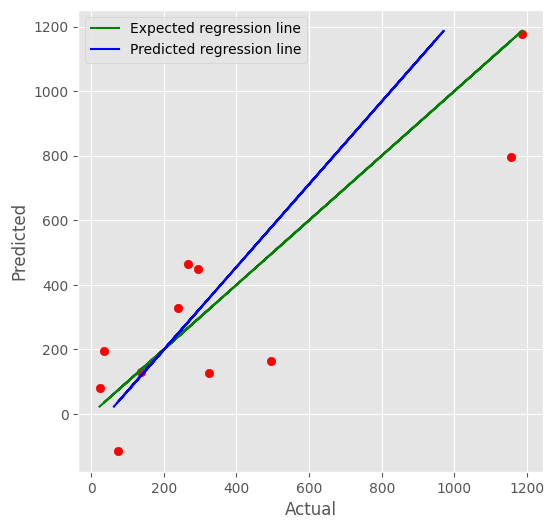

Phương trình chính quy: y = 384.582  + 18.012 * X_170 -122.937 * X_31 -242.978 * X_177  + 114.199 * X_49 -103.807 * X_166  + 14.179 * X_169 -186.0 * X_165 -50.155 * X_167  + 28.967 * X_186 


In [43]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  10
Number Wavelengths remove:  207
MSE min:  34631.631752846406

R2 calib: 1.000
R2 CV: 0.777
MSE calib: 0.000
MSE CV: 34631.632


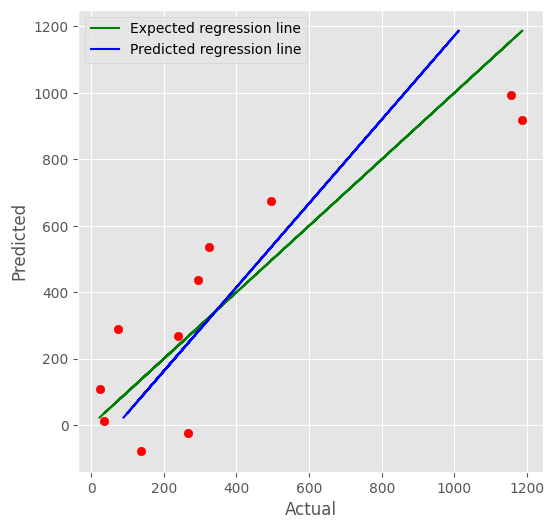

Phương trình chính quy: y = 384.639  + 60.033 * X_160  + 179.546 * X_116 -63.717 * X_203 -10.989 * X_201  + 25.159 * X_47  + 75.331 * X_48  + 86.71 * X_179 -18.112 * X_35 -43.95 * X_34  + 10.65 * X_164  + 34.522 * X_157 -38.344 * X_167  + 12.266 * X_156 -24.332 * X_28 -57.813 * X_32 -23.219 * X_202  + 136.596 * X_155 -73.705 * X_29 -53.698 * X_33 -75.761 * X_31 -73.058 * X_30 


In [44]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'e']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  6
Number Wavelengths remove:  204
MSE min:  59777.904013380765

R2 calib: 1.000
R2 CV: 0.615
MSE calib: 5.902
MSE CV: 59777.904


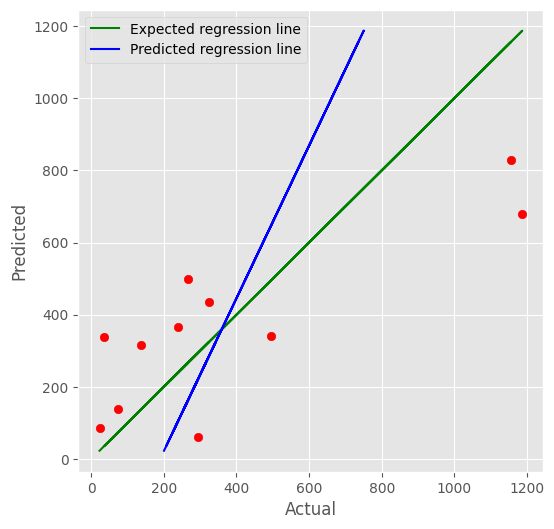

Phương trình chính quy: y = 384.737  + 101.109 * X_27  + 45.251 * X_147 -80.216 * X_33 -25.746 * X_219  + 33.073 * X_87 -43.985 * X_75 -10.514 * X_218 -70.51 * X_35  + 76.847 * X_170  + 11.958 * X_187  + 10.988 * X_94 -45.824 * X_74  + 67.871 * X_144 -70.277 * X_204  + 9.655 * X_175  + 1.865 * X_177 -105.265 * X_190  + 45.37 * X_210  + 19.42 * X_51  + 17.313 * X_85  + 73.826 * X_145  + 34.662 * X_84  + 51.512 * X_146  + 30.099 * X_86 


In [45]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'f']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  7
Number Wavelengths remove:  210
MSE min:  65174.70416170522

R2 calib: 0.999
R2 CV: 0.580
MSE calib: 163.784
MSE CV: 65174.704


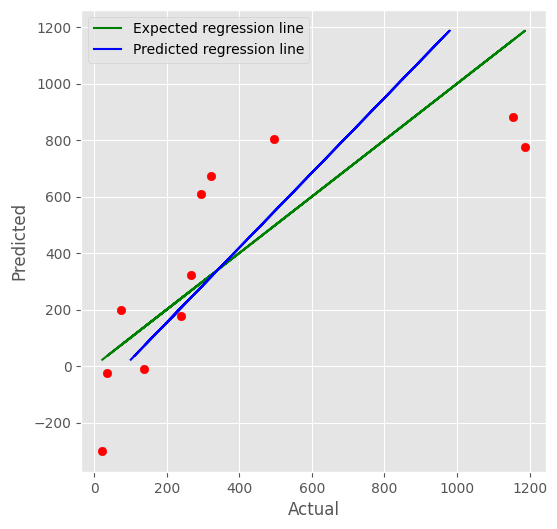

Phương trình chính quy: y = 385.595  + 52.504 * X_170 -45.046 * X_119 -29.487 * X_11  + 108.982 * X_171  + 176.497 * X_150 -5.459 * X_158  + 251.889 * X_67  + 7.719 * X_118  + 24.484 * X_172 -225.595 * X_94  + 12.095 * X_37  + 196.788 * X_217  + 16.454 * X_195  + 19.264 * X_159 -23.925 * X_36 -227.524 * X_38 -42.903 * X_191 -205.304 * X_208 


In [46]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'g']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  5
Number Wavelengths remove:  213
MSE min:  10606.63316763242

R2 calib: 0.990
R2 CV: 0.932
MSE calib: 1522.618
MSE CV: 10606.633


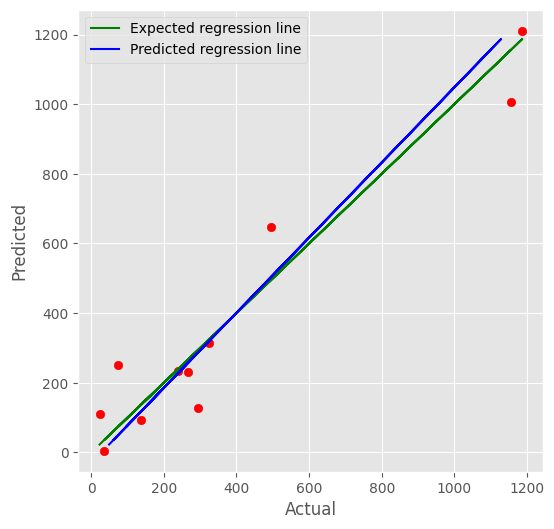

Phương trình chính quy: y = 384.783  + 129.687 * X_22 -105.751 * X_131  + 90.905 * X_144 -15.846 * X_35  + 22.007 * X_152  + 68.668 * X_25 -38.772 * X_197 -117.337 * X_146  + 104.079 * X_24 -18.769 * X_36  + 129.38 * X_23 -23.802 * X_130 -110.494 * X_196  + 33.965 * X_151 -110.48 * X_159 


In [47]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  22
Number Wavelengths remove:  198
MSE min:  265639.9944946121

R2 calib: 1.000
R2 CV: 0.898
MSE calib: 23.943
MSE CV: 265639.994


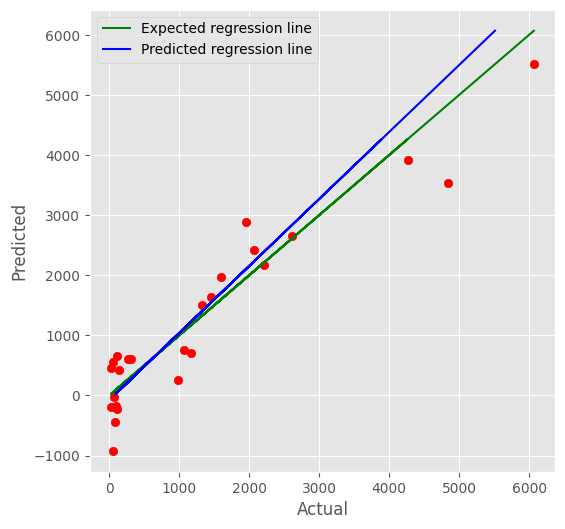

Phương trình chính quy: y = 1318.053 -375.346 * X_52 -230.702 * X_157  + 629.916 * X_30 -1639.404 * X_105  + 506.419 * X_217  + 925.562 * X_94  + 105.386 * X_44  + 451.803 * X_188  + 480.108 * X_113 -625.468 * X_155  + 716.839 * X_197  + 384.333 * X_201  + 303.852 * X_192  + 394.127 * X_218 -117.283 * X_169 -578.338 * X_87 -229.777 * X_168  + 721.245 * X_195 -518.997 * X_209 -214.906 * X_112 -374.024 * X_88 -351.127 * X_24 -624.056 * X_34 -910.5 * X_114 -168.698 * X_202 -1038.662 * X_61  + 469.567 * X_26 -295.123 * X_73  + 71.877 * X_193 -791.349 * X_72 


In [48]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  22
Number Wavelengths remove:  172
MSE min:  1448565.113116934

R2 calib: 1.000
R2 CV: 0.442
MSE calib: 0.242
MSE CV: 1448565.113


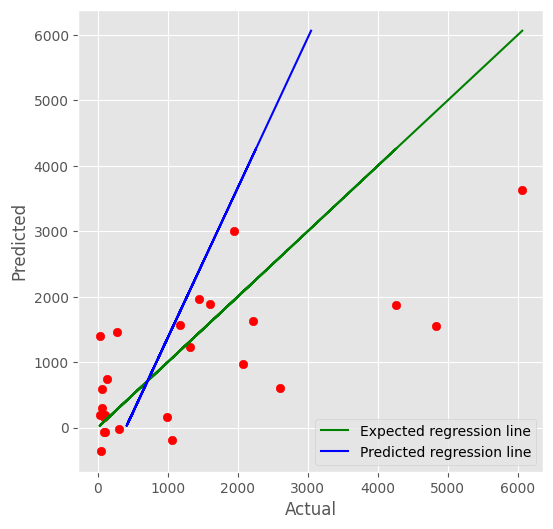

Phương trình chính quy: y = 1318.003 -756.134 * X_213  + 151.885 * X_39 -229.672 * X_112 -338.999 * X_200  + 363.873 * X_82 -78.066 * X_109  + 366.141 * X_116 -490.259 * X_199 -174.873 * X_43 -105.663 * X_197  + 448.14 * X_149 -462.666 * X_179  + 93.731 * X_204 -257.412 * X_172 -305.822 * X_160 -419.505 * X_113  + 384.928 * X_88  + 174.663 * X_118  + 532.029 * X_83 -220.705 * X_105  + 715.376 * X_100  + 331.522 * X_117  + 230.809 * X_169  + 499.911 * X_146  + 98.544 * X_50  + 547.828 * X_148 -256.152 * X_106 -344.335 * X_108  + 372.78 * X_58  + 277.02 * X_10  + 235.669 * X_89  + 892.309 * X_93  + 291.458 * X_119 -299.516 * X_107  + 545.939 * X_69  + 244.342 * X_176 -571.905 * X_65 -783.808 * X_35 -243.307 * X_166 -362.545 * X_110  + 392.74 * X_190 -453.743 * X_161  + 652.134 * X_120 -508.881 * X_62  + 574.558 * X_217 -1102.103 * X_198  + 820.223 * X_183  + 567.904 * X_185 -458.911 * X_165 -839.957 * X_163  + 680.314 * X_187 -260.684 * X_63 -900.487 * X_111 -905.468 * X_64  + 860.903 * 

In [49]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'b']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  20
Number Wavelengths remove:  202
MSE min:  385889.0315891537

R2 calib: 1.000
R2 CV: 0.851
MSE calib: 40.515
MSE CV: 385889.032


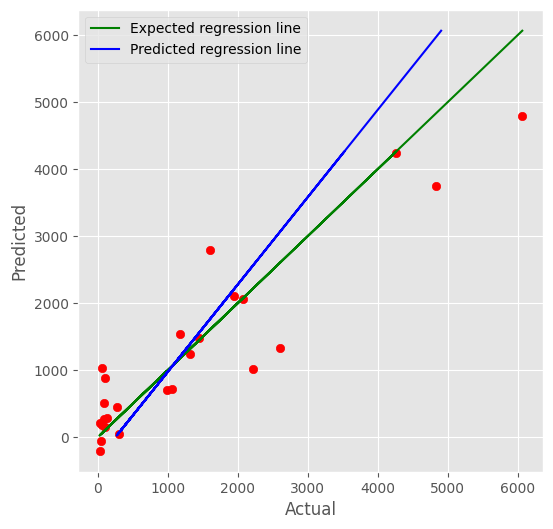

Phương trình chính quy: y = 1318.864  + 730.585 * X_115 -267.612 * X_220 -494.622 * X_183  + 160.629 * X_43 -478.054 * X_27  + 733.441 * X_45  + 391.63 * X_200  + 260.899 * X_47 -694.276 * X_87  + 474.725 * X_14  + 1241.408 * X_218  + 699.529 * X_61 -267.217 * X_39  + 328.461 * X_11  + 623.748 * X_16 -1187.152 * X_219  + 97.855 * X_185 -462.145 * X_169 -180.885 * X_180  + 483.469 * X_163 -699.496 * X_186  + 716.477 * X_175 -486.677 * X_52  + 400.339 * X_202 -478.383 * X_187  + 797.1 * X_204 


In [50]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'c']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  17
Number Wavelengths remove:  195
MSE min:  903558.2942710653

R2 calib: 0.999
R2 CV: 0.652
MSE calib: 2599.971
MSE CV: 903558.294


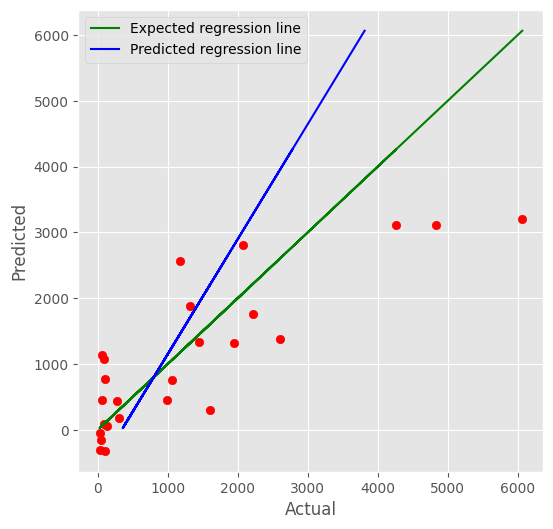

Phương trình chính quy: y = 1318.942  + 1058.976 * X_218  + 341.181 * X_100  + 741.354 * X_197  + 302.444 * X_99  + 206.638 * X_111  + 210.925 * X_101 -446.193 * X_135  + 475.323 * X_37 -755.165 * X_115 -48.176 * X_114  + 186.509 * X_74  + 1066.765 * X_137  + 400.544 * X_98  + 132.094 * X_167 -1618.755 * X_116  + 1599.024 * X_54 -1452.726 * X_16 -479.163 * X_26 -283.027 * X_27 -10.386 * X_170  + 773.628 * X_72 -165.573 * X_181 -1076.345 * X_190  + 939.733 * X_55  + 217.127 * X_136 -710.993 * X_164 -871.0 * X_10  + 243.417 * X_166  + 694.44 * X_33  + 3.023 * X_73 -672.449 * X_209  + 1156.633 * X_35 -3.767 * X_34 


In [51]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  7
Number Wavelengths remove:  208
MSE min:  2077438.0809992894

R2 calib: 0.766
R2 CV: 0.200
MSE calib: 607456.008
MSE CV: 2077438.081


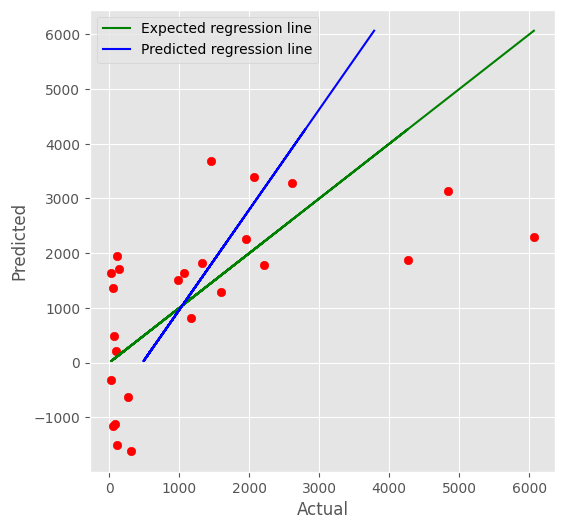

Phương trình chính quy: y = 1317.007  + 235.182 * X_219  + 673.312 * X_220  + 9.26 * X_79 -804.685 * X_187 -742.316 * X_36 -58.538 * X_215  + 1178.668 * X_26  + 246.146 * X_213 -540.3 * X_80  + 1141.37 * X_165 -899.651 * X_17 -254.671 * X_173  + 69.966 * X_216 -157.992 * X_217  + 114.055 * X_177  + 24.798 * X_179 -39.303 * X_178 -278.589 * X_205  + 199.38 * X_11  + 905.598 * X_218 


In [52]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'e']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  10
Number Wavelengths remove:  193
MSE min:  675992.1954657048

R2 calib: 0.987
R2 CV: 0.740
MSE calib: 33019.164
MSE CV: 675992.195


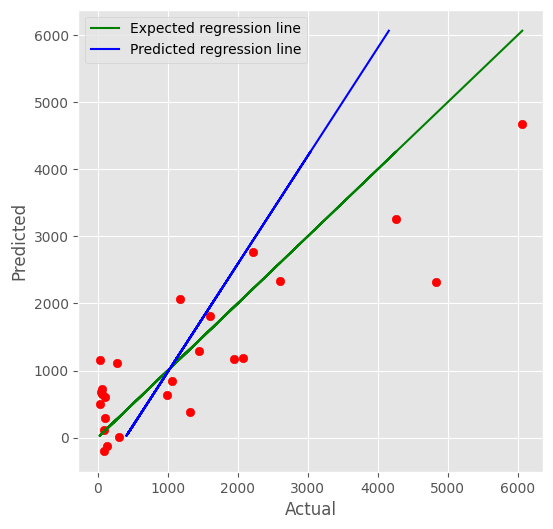

Phương trình chính quy: y = 1318.243 -462.275 * X_11 -442.147 * X_21  + 123.115 * X_148  + 515.941 * X_65 -250.942 * X_38  + 218.353 * X_213 -308.699 * X_100 -379.101 * X_166 -393.841 * X_26 -228.416 * X_117  + 157.032 * X_179  + 577.034 * X_91  + 196.353 * X_211 -256.86 * X_195 -281.988 * X_194  + 178.315 * X_47 -270.106 * X_99  + 185.345 * X_204  + 381.737 * X_197 -236.061 * X_39 -366.717 * X_36  + 322.495 * X_51 -281.742 * X_118  + 142.675 * X_205 -386.398 * X_35  + 252.769 * X_46  + 218.575 * X_164 -462.037 * X_190 -321.49 * X_10  + 82.43 * X_183 -424.578 * X_167  + 263.23 * X_184  + 150.014 * X_163  + 328.804 * X_185  + 379.277 * X_177 


In [53]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'f']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  6
Number Wavelengths remove:  200
MSE min:  2055432.7858526725

R2 calib: 0.825
R2 CV: 0.208
MSE calib: 454064.556
MSE CV: 2055432.786


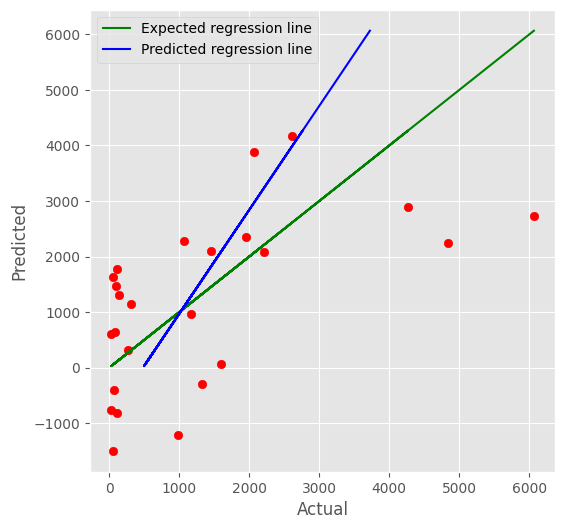

Phương trình chính quy: y = 1318.698  + 266.234 * X_141  + 699.922 * X_15  + 423.269 * X_169  + 240.664 * X_14 -481.606 * X_210 -791.411 * X_62  + 194.152 * X_189  + 156.966 * X_176 -434.313 * X_13 -406.519 * X_205  + 75.066 * X_192  + 222.647 * X_190  + 67.264 * X_179 -125.233 * X_178 -55.764 * X_162  + 405.782 * X_216 -258.977 * X_165  + 38.307 * X_174  + 139.039 * X_155  + 176.245 * X_177  + 369.669 * X_191  + 25.135 * X_159 -86.384 * X_186  + 494.056 * X_156  + 228.165 * X_157  + 99.346 * X_146  + 515.809 * X_220  + 533.71 * X_158 


In [54]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'g']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  17
Number Wavelengths remove:  179
MSE min:  586689.9755842916

R2 calib: 1.000
R2 CV: 0.774
MSE calib: 221.416
MSE CV: 586689.976


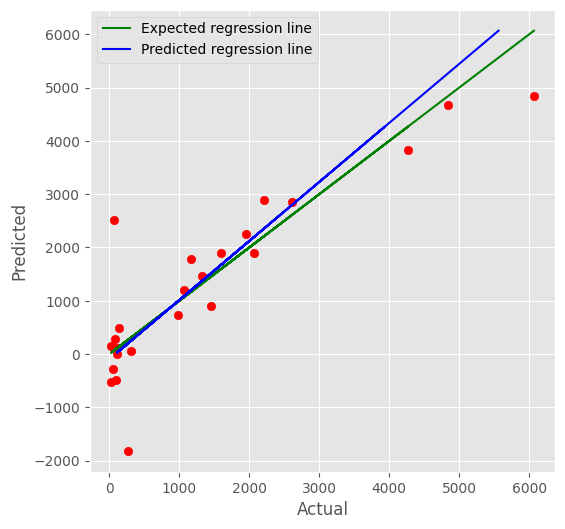

Phương trình chính quy: y = 1318.813  + 704.306 * X_12 -455.643 * X_91  + 15.82 * X_214  + 156.883 * X_221  + 156.883 * X_224  + 156.883 * X_223  + 156.883 * X_222  + 156.883 * X_226  + 156.883 * X_225  + 156.883 * X_228  + 156.883 * X_227 -342.573 * X_50 -372.093 * X_107 -396.708 * X_49  + 339.587 * X_140  + 128.157 * X_104 -32.154 * X_207 -247.088 * X_20  + 177.629 * X_106  + 453.407 * X_158 -596.519 * X_109  + 295.602 * X_105  + 129.844 * X_40  + 360.248 * X_41  + 82.937 * X_172 -518.635 * X_110  + 50.965 * X_38 -236.34 * X_45  + 63.473 * X_39  + 237.76 * X_169 -452.219 * X_34  + 403.957 * X_141 -43.424 * X_217 -213.843 * X_84 -606.579 * X_108 -155.778 * X_92  + 314.602 * X_190 -302.234 * X_184  + 143.237 * X_215  + 400.233 * X_186 -353.84 * X_46 -357.837 * X_166  + 223.335 * X_155 -314.669 * X_47  + 252.523 * X_143 -393.182 * X_48  + 384.134 * X_142  + 690.865 * X_209 -971.779 * X_170 


In [55]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  7
Number Wavelengths remove:  189
MSE min:  40130.14988638364

R2 calib: 1.000
R2 CV: 0.918
MSE calib: 7.772
MSE CV: 40130.150


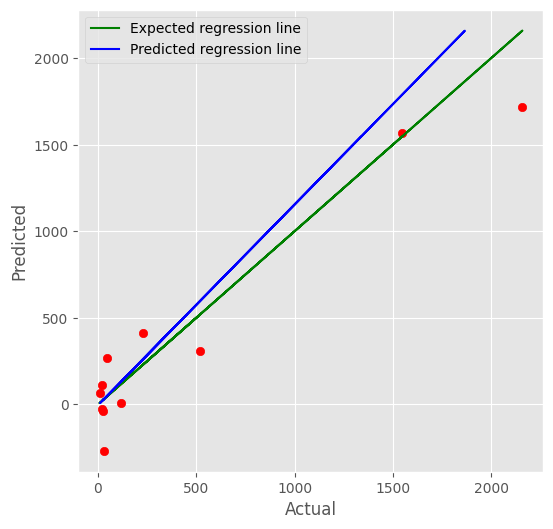

Phương trình chính quy: y = 430.439 -35.382 * X_26  + 42.128 * X_181  + 24.944 * X_193 -32.176 * X_173  + 38.463 * X_215 -32.8 * X_160 -59.528 * X_51  + 39.763 * X_214  + 38.453 * X_64  + 48.114 * X_212  + 30.975 * X_192  + 44.912 * X_183 -27.19 * X_37 -20.628 * X_161  + 23.82 * X_195  + 47.608 * X_211  + 47.23 * X_216  + 42.832 * X_191 -8.04 * X_164 -20.326 * X_165  + 44.278 * X_198 -57.962 * X_31  + 33.923 * X_197 -41.236 * X_49 -29.992 * X_48 -41.249 * X_27 -53.739 * X_204  + 55.922 * X_209 -37.139 * X_166 -37.903 * X_36 -42.373 * X_203 -21.791 * X_163 -36.007 * X_162  + 55.08 * X_210 -56.713 * X_28 -53.309 * X_39 -37.209 * X_47  + 50.516 * X_196 -89.288 * X_29 


In [56]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  3
Number Wavelengths remove:  181
MSE min:  131807.23083270912

R2 calib: 0.965
R2 CV: 0.729
MSE calib: 17241.298
MSE CV: 131807.231


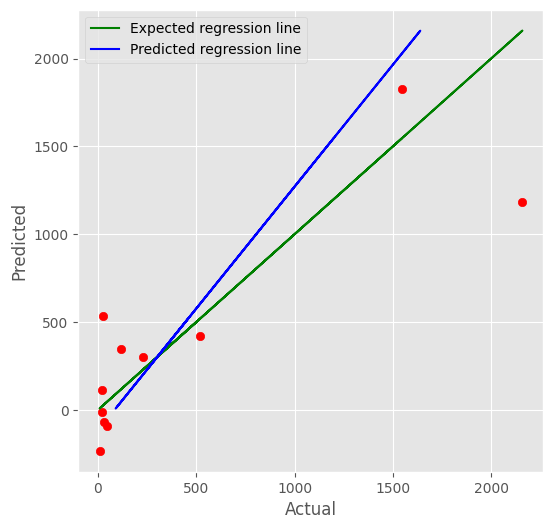

Phương trình chính quy: y = 429.646  + 33.864 * X_218  + 58.711 * X_188  + 42.618 * X_32  + 22.121 * X_212  + 24.342 * X_68  + 30.407 * X_20 -55.54 * X_159  + 30.257 * X_216  + 30.792 * X_69  + 19.694 * X_14 -45.034 * X_88 -28.201 * X_86 -39.943 * X_92  + 29.22 * X_79  + 30.606 * X_214 -19.981 * X_47  + 21.894 * X_135 -61.168 * X_161 -59.619 * X_160  + 21.297 * X_78  + 8.229 * X_77  + 47.739 * X_80  + 35.119 * X_2  + 35.119 * X_3  + 35.119 * X_4  + 35.119 * X_5  + 35.119 * X_6  + 35.119 * X_7  + 35.119 * X_1  + 35.119 * X_8  + 33.031 * X_66  + 57.139 * X_134  + 34.11 * X_16  + 53.336 * X_219  + 20.642 * X_13 -52.107 * X_54 -44.226 * X_163  + 37.885 * X_63 -49.118 * X_23 -66.827 * X_26  + 37.472 * X_15  + 33.22 * X_65 -71.935 * X_36 -45.574 * X_164 -80.966 * X_25  + 53.155 * X_64 -82.082 * X_24 


In [57]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'b']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  10
Number Wavelengths remove:  185
MSE min:  22849.075076984587

R2 calib: 1.000
R2 CV: 0.953
MSE calib: 0.000
MSE CV: 22849.075


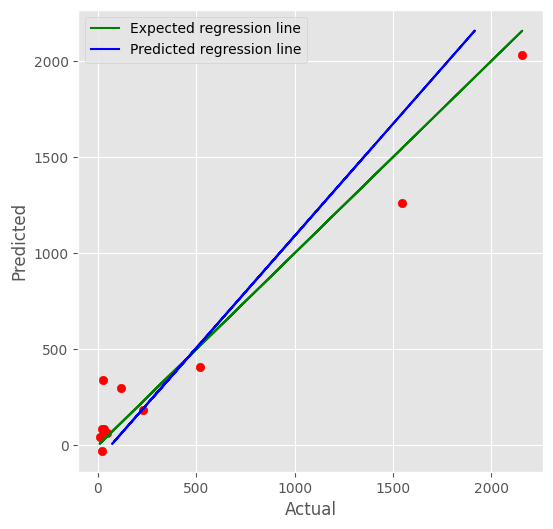

Phương trình chính quy: y = 429.681 -44.42 * X_169 -44.316 * X_34  + 42.023 * X_65 -39.31 * X_26 -37.173 * X_158 -49.879 * X_9 -25.087 * X_45  + 0.631 * X_214  + 52.32 * X_201 -42.636 * X_30  + 40.17 * X_51  + 12.314 * X_163  + 38.922 * X_54 -44.115 * X_86  + 11.388 * X_22  + 23.415 * X_178 -57.302 * X_25 -32.053 * X_160  + 49.138 * X_101  + 14.66 * X_177  + 15.849 * X_23  + 48.713 * X_203  + 27.567 * X_72  + 22.855 * X_69  + 24.03 * X_175  + 25.737 * X_36  + 26.404 * X_70  + 36.804 * X_50  + 36.83 * X_68 -49.888 * X_47  + 44.179 * X_66  + 35.005 * X_164  + 31.628 * X_204  + 37.801 * X_73 -22.226 * X_197 -31.881 * X_198  + 40.616 * X_71  + 46.89 * X_67 -60.364 * X_161  + 36.704 * X_176  + 45.239 * X_49  + 66.851 * X_74  + 61.142 * X_75 


In [58]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'c']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  7
Number Wavelengths remove:  207
MSE min:  52015.57008231734

R2 calib: 1.000
R2 CV: 0.893
MSE calib: 42.821
MSE CV: 52015.570


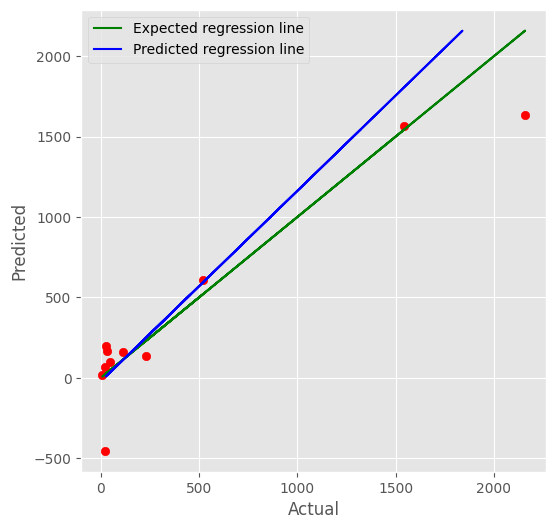

Phương trình chính quy: y = 429.678 -30.992 * X_34  + 143.415 * X_185  + 72.768 * X_187  + 140.351 * X_199 -112.614 * X_120  + 132.699 * X_183  + 68.321 * X_104 -38.784 * X_33 -69.645 * X_74 -10.964 * X_41 -87.443 * X_19 -43.164 * X_35  + 23.939 * X_118 -84.622 * X_166  + 83.476 * X_96 -91.5 * X_42 -100.845 * X_87 -106.352 * X_20  + 37.93 * X_46 -109.76 * X_165 -97.302 * X_119 


In [59]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  5
Number Wavelengths remove:  212
MSE min:  85762.63407131027

R2 calib: 0.995
R2 CV: 0.824
MSE calib: 2498.081
MSE CV: 85762.634


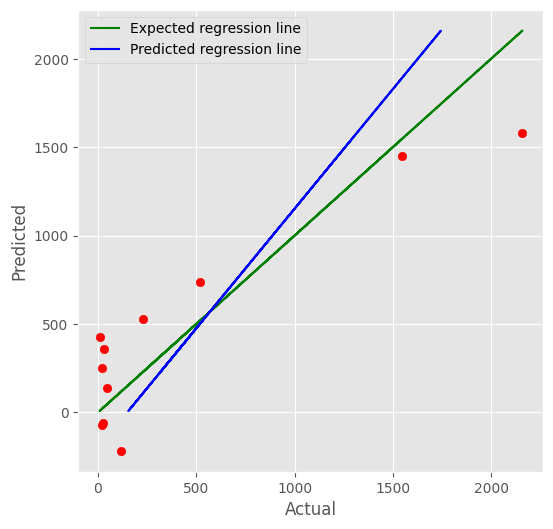

Phương trình chính quy: y = 429.729 -122.611 * X_94 -23.916 * X_170 -169.633 * X_161 -183.607 * X_160 -114.437 * X_93 -130.193 * X_169 -114.213 * X_35 -249.573 * X_178 -122.912 * X_33  + 4.897 * X_181 -152.989 * X_34  + 180.908 * X_219  + 89.705 * X_210 -64.801 * X_31 -75.725 * X_182 -141.847 * X_32 


In [60]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'e']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  8
Number Wavelengths remove:  193
MSE min:  115803.03603543034

R2 calib: 1.000
R2 CV: 0.762
MSE calib: 6.800
MSE CV: 115803.036


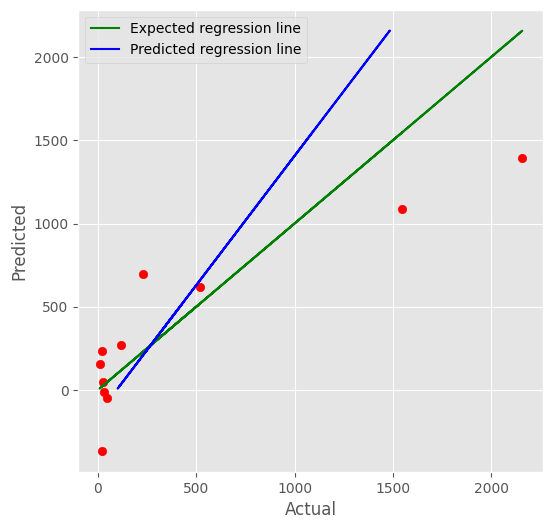

Phương trình chính quy: y = 429.755  + 50.846 * X_215  + 80.248 * X_193 -93.831 * X_13  + 81.817 * X_197 -45.737 * X_85 -37.382 * X_163  + 47.993 * X_62  + 33.262 * X_65 -66.102 * X_149  + 60.651 * X_192  + 59.657 * X_45 -25.449 * X_74 -48.785 * X_203  + 42.379 * X_64  + 44.213 * X_63  + 0.567 * X_30 -20.862 * X_170 -56.749 * X_122 -82.126 * X_150 -46.05 * X_120 -79.19 * X_201  + 51.391 * X_211  + 53.51 * X_188 -41.289 * X_119 -59.207 * X_160  + 64.492 * X_210 -57.356 * X_86 -36.36 * X_87 -43.407 * X_174 -76.036 * X_121 -19.097 * X_173 -76.443 * X_161  + 85.136 * X_190 -49.212 * X_172 -60.458 * X_171 


In [61]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'f']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  8
Number Wavelengths remove:  219
MSE min:  180257.58953682633

R2 calib: 0.998
R2 CV: 0.630
MSE calib: 1031.904
MSE CV: 180257.590


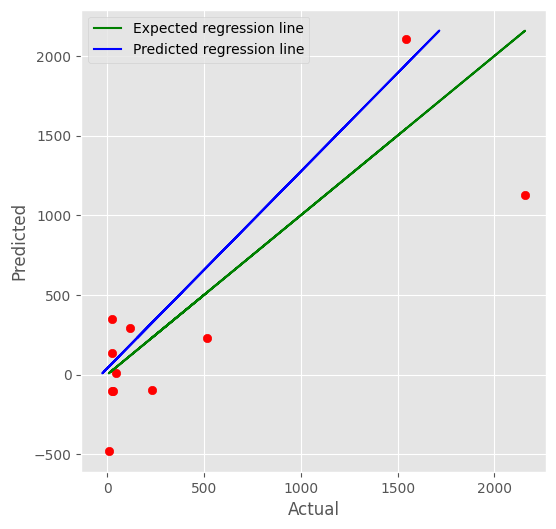

Phương trình chính quy: y = 429.754  + 439.288 * X_81  + 269.318 * X_79 -679.597 * X_82  + 277.611 * X_217 -416.693 * X_142 -57.872 * X_88 -32.634 * X_220 -728.452 * X_80  + 115.459 * X_200 


In [62]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'g']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  8
Number Wavelengths remove:  195
MSE min:  154807.10808371214

R2 calib: 1.000
R2 CV: 0.682
MSE calib: 158.001
MSE CV: 154807.108


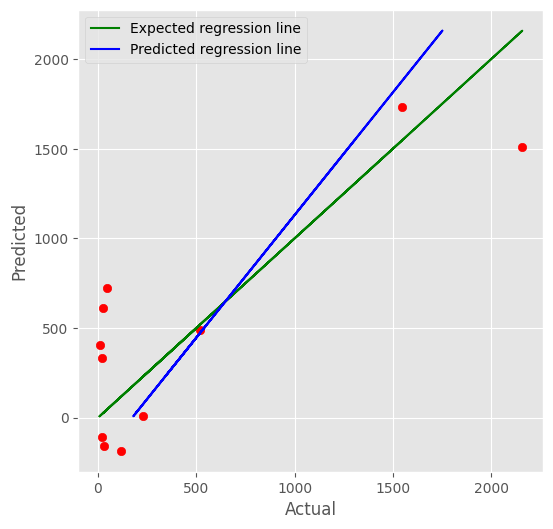

Phương trình chính quy: y = 429.64 -75.949 * X_148 -77.72 * X_31 -71.002 * X_108  + 63.208 * X_145  + 44.019 * X_172  + 30.691 * X_219  + 68.041 * X_144  + 48.851 * X_215  + 96.293 * X_15  + 63.269 * X_130  + 59.582 * X_132 -69.708 * X_107 -37.318 * X_195 -60.364 * X_204  + 69.813 * X_131  + 110.837 * X_63  + 92.801 * X_220  + 34.828 * X_171 -94.289 * X_184  + 19.258 * X_157  + 109.56 * X_189  + 32.884 * X_192  + 59.088 * X_193 -68.71 * X_180 -65.949 * X_178 -93.925 * X_168 -93.82 * X_175 -41.911 * X_179 -76.676 * X_176  + 83.984 * X_158  + 128.425 * X_14  + 70.111 * X_13  + 135.608 * X_191 


In [63]:
data1 = pd.read_csv("D:/NIR/ure_ca_11_10_2022/Ure_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-4], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-4])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  23
Number Wavelengths remove:  158
MSE min:  74154.74208250588

R2 calib: 0.961
R2 CV: 0.539
MSE calib: 6221.350
MSE CV: 74154.742


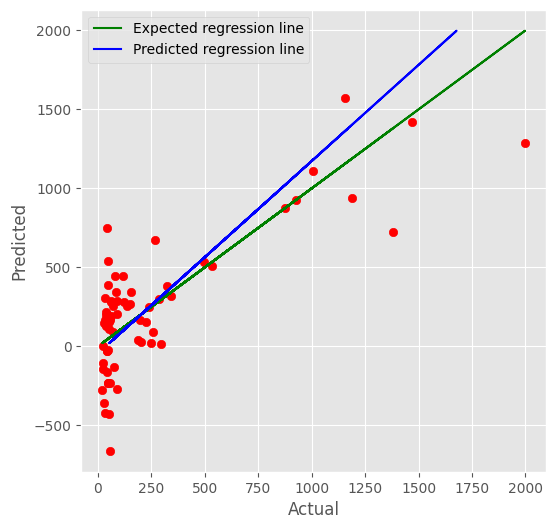

Phương trình chính quy: y = 251.842 -351.071 * X_201  + 5.125 * X_175  + 295.43 * X_217  + 143.081 * X_199 -25.272 * X_26  + 518.3 * X_79 -138.765 * X_214  + 481.594 * X_59 -140.624 * X_96 -242.621 * X_211 -207.945 * X_220  + 490.853 * X_92 -54.984 * X_219  + 417.954 * X_209 -216.961 * X_168 -284.072 * X_34  + 162.633 * X_49 -339.562 * X_56 -236.421 * X_193  + 100.343 * X_153  + 237.079 * X_22 -224.524 * X_191  + 343.881 * X_33 -25.461 * X_50  + 375.99 * X_24 -299.113 * X_200 -191.322 * X_212  + 189.343 * X_23 -76.365 * X_187 -302.958 * X_179 -66.433 * X_111  + 352.466 * X_95  + 265.169 * X_18 -160.753 * X_205 -225.357 * X_114  + 70.351 * X_67  + 230.946 * X_1  + 230.946 * X_2  + 230.946 * X_3  + 230.946 * X_4  + 230.946 * X_5  + 230.946 * X_7  + 230.946 * X_6  + 230.946 * X_8  + 422.975 * X_82  + 40.294 * X_51  + 95.669 * X_17  + 191.343 * X_12 -95.91 * X_40  + 179.48 * X_27  + 111.577 * X_36  + 503.078 * X_203 -166.525 * X_30 -262.303 * X_43 -13.981 * X_207 -202.077 * X_44  + 179.393

In [64]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/ure/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  4
Number Wavelengths remove:  211
MSE min:  136004.12053000147

R2 calib: 0.310
R2 CV: 0.154
MSE calib: 110910.831
MSE CV: 136004.121


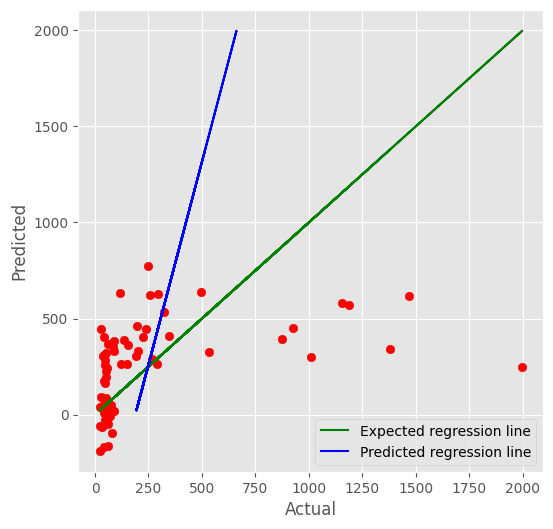

Phương trình chính quy: y = 251.553 -82.671 * X_43  + 61.481 * X_24 -59.723 * X_130  + 12.183 * X_64  + 36.456 * X_63  + 44.954 * X_220  + 8.123 * X_77  + 31.239 * X_15 -12.667 * X_76 -46.216 * X_82  + 43.505 * X_14 -43.685 * X_81  + 34.315 * X_12  + 35.908 * X_13 -18.725 * X_80 -9.672 * X_78 -7.998 * X_79 


In [65]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/ure/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  37
Number Wavelengths remove:  151
MSE min:  469807.0254826409

R2 calib: 0.980
R2 CV: 0.796
MSE calib: 46365.532
MSE CV: 469807.025


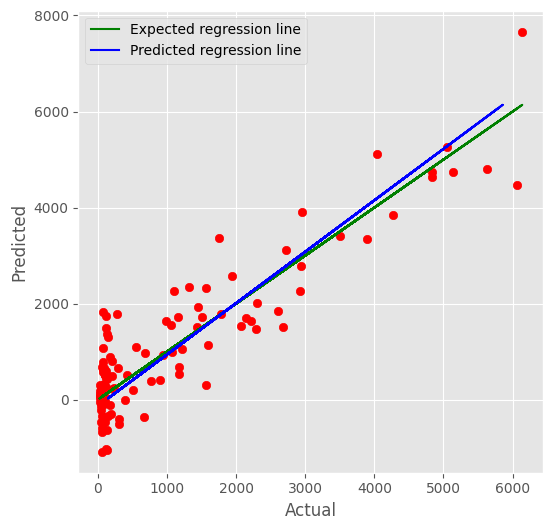

Phương trình chính quy: y = 1095.572 -1790.727 * X_105  + 1909.664 * X_97  + 515.038 * X_136  + 1839.497 * X_200  + 1133.269 * X_101 -960.393 * X_66  + 501.44 * X_13  + 283.553 * X_86  + 106.184 * X_72 -595.937 * X_108 -76.718 * X_191  + 2103.995 * X_143  + 1038.365 * X_46 -1664.712 * X_212  + 1319.8 * X_84  + 1093.435 * X_209  + 632.803 * X_151  + 340.645 * X_163  + 1643.987 * X_175 -1237.237 * X_179  + 975.006 * X_41 -1999.438 * X_95  + 1341.719 * X_49  + 1052.446 * X_28  + 1560.606 * X_122 -1101.148 * X_35 -120.746 * X_51  + 3304.632 * X_131 -551.914 * X_34  + 566.294 * X_185  + 1729.582 * X_123  + 559.011 * X_195  + 1233.218 * X_134 -267.166 * X_166  + 1009.725 * X_25  + 2083.254 * X_152  + 816.013 * X_178  + 822.947 * X_32  + 1400.841 * X_42  + 883.295 * X_47 -1931.934 * X_100 -573.443 * X_19 -997.564 * X_37 -1143.28 * X_147  + 1275.554 * X_70  + 231.888 * X_146 -1570.34 * X_114 -232.846 * X_201 -1510.413 * X_80 -2016.78 * X_91  + 444.352 * X_54 -506.634 * X_67  + 2376.246 * X_113

In [71]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/ure/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
data2 = data2.drop(data2[data2['Ure'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  29
Number Wavelengths remove:  150
MSE min:  853105.4359027371

R2 calib: 0.964
R2 CV: 0.630
MSE calib: 82480.162
MSE CV: 853105.436


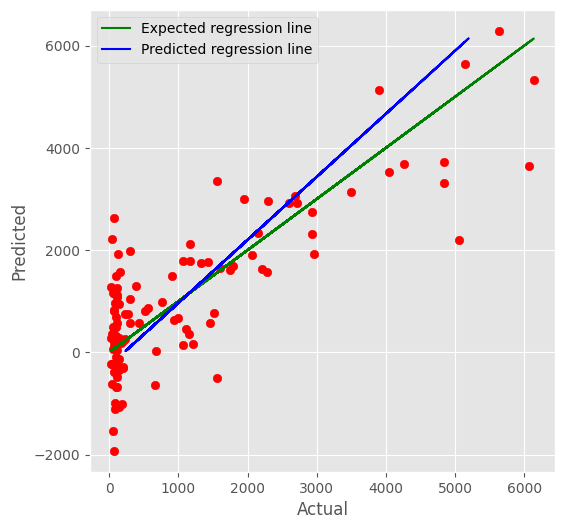

Phương trình chính quy: y = 1096.872 -619.955 * X_190  + 594.579 * X_53 -504.538 * X_133 -1343.461 * X_9 -476.652 * X_22 -84.435 * X_41 -444.432 * X_10 -802.247 * X_18  + 50.8 * X_101 -790.182 * X_218 -75.475 * X_64  + 682.021 * X_148  + 1249.687 * X_122  + 160.485 * X_195 -249.41 * X_39 -84.487 * X_78  + 264.66 * X_84 -1211.122 * X_140  + 10.004 * X_107 -345.215 * X_88 -733.494 * X_73 -53.285 * X_106 -551.449 * X_36  + 140.613 * X_42  + 1007.664 * X_99  + 620.863 * X_189 -676.719 * X_15  + 473.09 * X_12  + 225.443 * X_178 -718.381 * X_150 -404.439 * X_13 -108.516 * X_175  + 648.396 * X_186  + 431.201 * X_220  + 939.197 * X_24  + 156.723 * X_40  + 427.152 * X_208 -760.091 * X_104 -554.817 * X_25  + 972.991 * X_176  + 450.448 * X_32  + 56.015 * X_207  + 31.847 * X_109 -706.446 * X_183 -1130.606 * X_210  + 950.182 * X_192  + 400.718 * X_197 -120.409 * X_91 -430.717 * X_82 -772.594 * X_31  + 284.734 * X_194  + 705.273 * X_38 -1052.021 * X_47  + 102.807 * X_92 -460.288 * X_206  + 964.546 *

In [72]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/ure/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
data2 = data2.drop(data2[data2['Ure'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  13
Number Wavelengths remove:  168
MSE min:  211903.26901349743

R2 calib: 0.972
R2 CV: 0.644
MSE calib: 16701.136
MSE CV: 211903.269


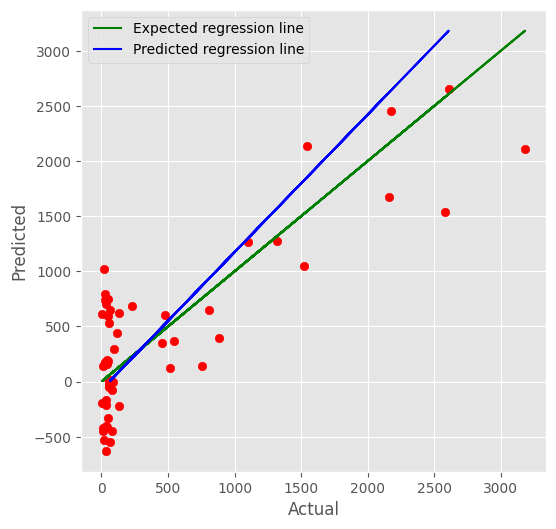

Phương trình chính quy: y = 450.596  + 115.312 * X_27 -180.609 * X_35  + 247.847 * X_30 -160.645 * X_179 -54.582 * X_99 -182.643 * X_58 -175.472 * X_33 -156.111 * X_41 -37.535 * X_76 -69.778 * X_204  + 19.321 * X_25  + 222.953 * X_18 -119.556 * X_196  + 85.933 * X_162  + 242.205 * X_24 -96.117 * X_60 -163.211 * X_203 -147.726 * X_200 -91.396 * X_40  + 88.903 * X_211 -287.697 * X_87 -58.878 * X_54 -274.557 * X_161 -95.336 * X_201  + 53.052 * X_214  + 70.991 * X_176  + 122.62 * X_19  + 195.764 * X_180 -69.825 * X_39  + 340.132 * X_95  + 296.323 * X_53 -241.808 * X_169 -222.596 * X_209  + 366.402 * X_186  + 180.356 * X_181 -200.818 * X_47 -153.071 * X_75 -8.262 * X_89 -240.63 * X_207 -219.753 * X_103  + 173.521 * X_49 -177.402 * X_170 -220.912 * X_13  + 165.661 * X_43  + 247.995 * X_45 -232.979 * X_198  + 399.747 * X_118 -275.191 * X_208  + 149.313 * X_213  + 209.05 * X_191 -92.427 * X_202  + 189.655 * X_187 -134.164 * X_20  + 194.548 * X_212 -162.458 * X_100 -177.178 * X_165 -209.831 * X

In [68]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/ure/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  11
Number Wavelengths remove:  179
MSE min:  287094.9060768821

R2 calib: 0.940
R2 CV: 0.517
MSE calib: 35838.770
MSE CV: 287094.906


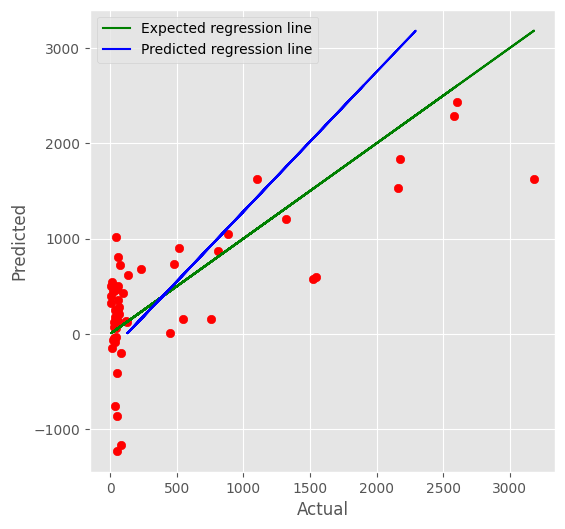

Phương trình chính quy: y = 449.836  + 198.194 * X_144  + 280.708 * X_89  + 145.808 * X_25 -246.69 * X_174 -371.222 * X_87  + 214.862 * X_40 -76.953 * X_197 -182.822 * X_161 -263.829 * X_166  + 150.507 * X_143  + 178.512 * X_205  + 57.998 * X_219  + 396.609 * X_38  + 95.511 * X_117 -92.583 * X_150  + 59.858 * X_184 -326.822 * X_122 -337.381 * X_9  + 4.863 * X_98  + 134.977 * X_153  + 306.389 * X_171  + 150.546 * X_172  + 149.208 * X_202  + 110.367 * X_208 -79.916 * X_149  + 92.817 * X_118  + 253.068 * X_86  + 238.294 * X_185  + 136.928 * X_115  + 243.228 * X_196 -179.588 * X_188  + 224.59 * X_42  + 21.251 * X_23 -391.04 * X_183 -86.52 * X_24 -219.76 * X_148  + 193.372 * X_201 -368.77 * X_121 -112.978 * X_186 -273.354 * X_35  + 118.313 * X_26  + 163.917 * X_177  + 212.168 * X_28 -418.778 * X_93  + 320.818 * X_203 -192.262 * X_187 -524.75 * X_170 -342.927 * X_200 -192.089 * X_178 


In [69]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/ure/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  6
Number Wavelengths remove:  212
MSE min:  164.8788174684044

R2 calib: 0.873
R2 CV: 0.822
MSE calib: 117.829
MSE CV: 164.879


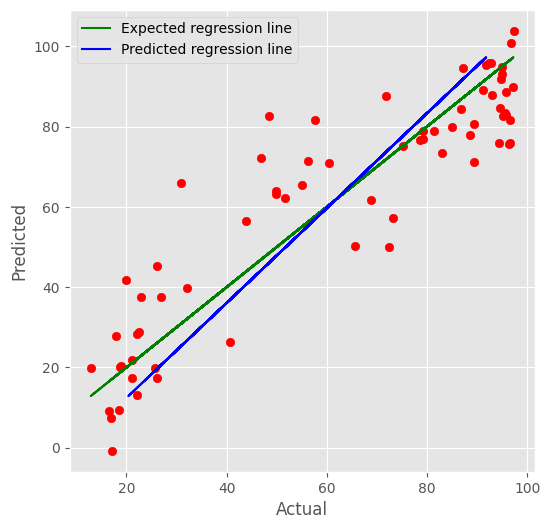

Phương trình chính quy: y = 61.881  + 7.826 * X_29  + 1.436 * X_183 -2.738 * X_69  + 5.179 * X_163  + 2.801 * X_37  + 5.613 * X_134 -3.904 * X_169 -2.684 * X_71 -4.446 * X_170 -1.282 * X_73 -1.432 * X_70 -6.437 * X_176 -8.891 * X_171  + 5.502 * X_196  + 6.31 * X_195 -0.325 * X_189 


In [73]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  38
Number Wavelengths remove:  155
MSE min:  112.82130501817515

R2 calib: 0.999
R2 CV: 0.879
MSE calib: 0.562
MSE CV: 112.821


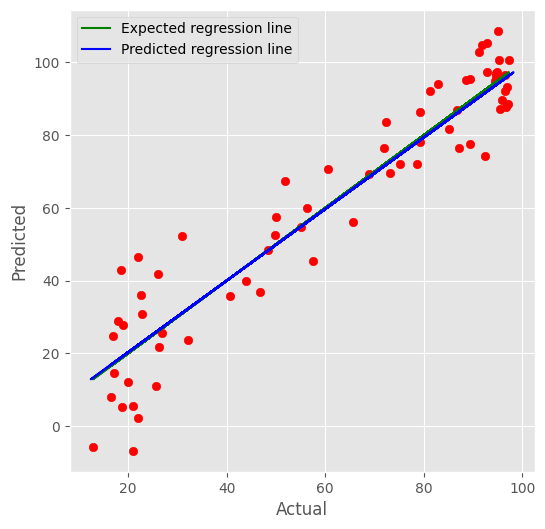

Phương trình chính quy: y = 61.984 -12.027 * X_9 -10.149 * X_37 -11.139 * X_10  + 29.604 * X_14  + 6.354 * X_63 -0.85 * X_42 -7.688 * X_122 -6.395 * X_118  + 2.267 * X_157  + 3.915 * X_75 -26.677 * X_67 -8.441 * X_131 -12.262 * X_27 -10.864 * X_56 -4.858 * X_132  + 12.321 * X_66 -2.844 * X_94 -1.254 * X_116 -0.537 * X_96 -6.906 * X_109 -10.845 * X_169  + 15.691 * X_104  + 3.729 * X_48  + 20.281 * X_111  + 1.441 * X_50  + 0.544 * X_190 -2.852 * X_219  + 22.623 * X_64  + 9.521 * X_36  + 3.567 * X_53  + 11.18 * X_194  + 3.868 * X_196 -11.471 * X_123  + 27.913 * X_135 -1.774 * X_98 -1.875 * X_161 -7.762 * X_107  + 30.398 * X_213 -17.926 * X_197 -11.961 * X_17 -1.369 * X_117 -10.103 * X_39  + 1.788 * X_149 -12.532 * X_60  + 16.861 * X_170 -14.924 * X_202 -2.787 * X_192 -25.363 * X_106 -7.98 * X_86  + 11.407 * X_112  + 13.102 * X_61  + 4.711 * X_159 -9.978 * X_187  + 15.02 * X_40 -12.254 * X_165  + 8.095 * X_102  + 14.711 * X_31 -17.52 * X_72  + 25.016 * X_175 -15.028 * X_218  + 13.521 * X_1

In [74]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'b']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  14
Number Wavelengths remove:  176
MSE min:  140.50201605062884

R2 calib: 0.963
R2 CV: 0.849
MSE calib: 34.071
MSE CV: 140.502


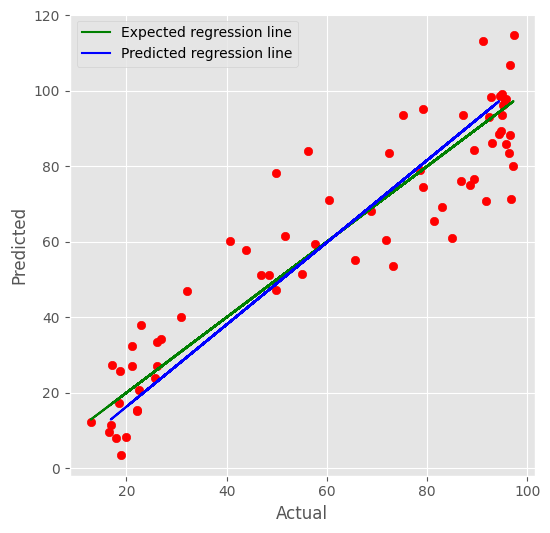

Phương trình chính quy: y = 61.886  + 2.896 * X_160 -16.196 * X_194 -5.894 * X_183  + 2.98 * X_159  + 0.856 * X_67 -8.849 * X_45  + 8.897 * X_196  + 1.447 * X_169 -4.364 * X_54 -7.719 * X_73 -16.309 * X_102  + 8.51 * X_38 -4.549 * X_96  + 8.414 * X_28 -1.189 * X_90 -7.51 * X_31  + 2.808 * X_189 -1.145 * X_19  + 3.413 * X_190 -6.845 * X_168  + 7.905 * X_193 -15.457 * X_101 -7.242 * X_74  + 5.307 * X_182 -7.514 * X_86 -4.509 * X_44 -5.02 * X_91 -3.779 * X_98 -6.852 * X_53  + 4.918 * X_58  + 11.078 * X_56  + 3.876 * X_177  + 3.055 * X_59 -7.143 * X_201 -7.284 * X_219  + 0.645 * X_72  + 6.104 * X_32  + 6.092 * X_22  + 13.117 * X_185 -2.703 * X_88 -10.633 * X_93  + 8.445 * X_57  + 12.196 * X_62  + 6.102 * X_60  + 2.597 * X_39  + 2.881 * X_209 -5.73 * X_49  + 9.26 * X_61  + 2.315 * X_18 -2.468 * X_187  + 10.329 * X_210 -9.583 * X_202 


In [75]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'c']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  17
Number Wavelengths remove:  172
MSE min:  185.5959058245982

R2 calib: 0.967
R2 CV: 0.797
MSE calib: 30.343
MSE CV: 185.596


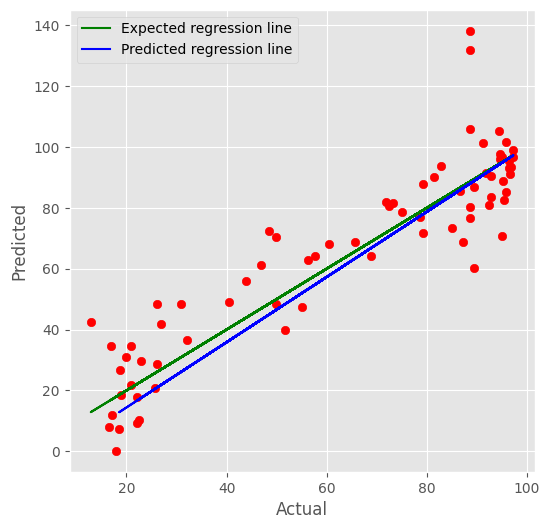

Phương trình chính quy: y = 63.311 -17.949 * X_17 -7.403 * X_92 -13.351 * X_110 -6.033 * X_87 -3.44 * X_73 -3.265 * X_69  + 18.525 * X_134  + 19.538 * X_135 -13.913 * X_94 -11.201 * X_82 -14.016 * X_37 -5.672 * X_31 -14.529 * X_45 -17.275 * X_198 -5.327 * X_141  + 5.848 * X_47  + 14.153 * X_156 -27.477 * X_54 -18.469 * X_44  + 0.967 * X_27  + 3.832 * X_169 -10.233 * X_209  + 4.356 * X_203  + 14.413 * X_85 -9.018 * X_145 -7.808 * X_68 -10.158 * X_113 -23.839 * X_79  + 5.371 * X_208 -21.303 * X_171 -11.025 * X_142  + 12.799 * X_36  + 11.424 * X_205 -5.075 * X_163  + 5.881 * X_29 -7.848 * X_71 -7.994 * X_35  + 0.755 * X_174 -16.135 * X_111 -16.212 * X_146 -15.159 * X_144  + 8.766 * X_161 -20.772 * X_80 -6.848 * X_193 -27.473 * X_25 -9.62 * X_70 -15.762 * X_115  + 14.41 * X_50 -15.307 * X_143 -18.887 * X_204  + 10.891 * X_48 -5.388 * X_184 -20.378 * X_186 -26.006 * X_182 -18.863 * X_179 -15.107 * X_185 


In [76]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  6
Number Wavelengths remove:  179
MSE min:  226.17403831465754

R2 calib: 0.883
R2 CV: 0.757
MSE calib: 108.975
MSE CV: 226.174


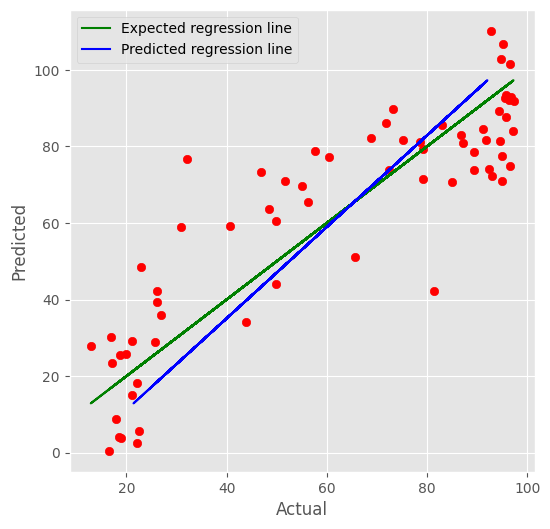

Phương trình chính quy: y = 61.487  + 1.757 * X_168 -0.951 * X_217  + 2.854 * X_13  + 2.892 * X_54  + 1.995 * X_29  + 2.039 * X_52 -2.811 * X_185  + 0.975 * X_20 -3.023 * X_9  + 1.503 * X_23  + 1.734 * X_30 -2.019 * X_75  + 2.41 * X_14  + 0.237 * X_190  + 1.641 * X_50  + 1.356 * X_16  + 1.477 * X_166 -1.774 * X_148  + 2.682 * X_63 -0.591 * X_100  + 2.034 * X_81  + 0.043 * X_180  + 0.293 * X_86  + 1.462 * X_19  + 0.756 * X_209  + 2.402 * X_170 -0.997 * X_204 -2.964 * X_94 -1.378 * X_208 -1.507 * X_149 -1.786 * X_88 -2.623 * X_73 -1.898 * X_150  + 3.511 * X_202  + 1.43 * X_21  + 2.645 * X_196  + 1.961 * X_22  + 2.32 * X_158 -2.566 * X_74 -1.441 * X_99  + 2.624 * X_157 -2.894 * X_10 -0.704 * X_189 -3.38 * X_218  + 3.654 * X_156  + 1.21 * X_174  + 3.713 * X_195  + 3.052 * X_193 -2.249 * X_87 


In [77]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'e']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  12
Number Wavelengths remove:  160
MSE min:  179.75309893645704

R2 calib: 0.940
R2 CV: 0.807
MSE calib: 55.615
MSE CV: 179.753


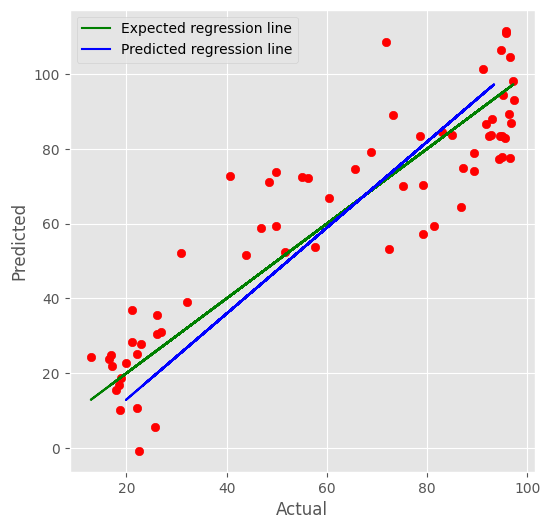

Phương trình chính quy: y = 61.468 -5.011 * X_172  + 0.191 * X_173 -1.835 * X_8 -1.835 * X_7 -1.835 * X_6 -1.835 * X_5 -1.835 * X_4 -1.835 * X_3 -1.835 * X_2 -1.835 * X_1  + 3.087 * X_57  + 0.416 * X_151  + 3.609 * X_56  + 0.327 * X_24  + 0.27 * X_201  + 3.798 * X_60 -2.488 * X_84  + 0.175 * X_176  + 4.86 * X_122  + 2.957 * X_90  + 4.097 * X_61  + 1.176 * X_183 -1.484 * X_200 -2.532 * X_87  + 3.753 * X_20 -2.587 * X_190 -1.574 * X_199 -2.973 * X_27 -3.004 * X_144 -1.754 * X_98  + 1.194 * X_166 -3.35 * X_142 -2.269 * X_95 -6.075 * X_85  + 2.378 * X_18  + 4.576 * X_59 -2.747 * X_25  + 1.739 * X_177 -3.363 * X_92  + 1.593 * X_220  + 2.275 * X_104  + 1.956 * X_117  + 3.575 * X_175  + 3.707 * X_167 -1.404 * X_97  + 3.888 * X_30  + 3.949 * X_77  + 2.121 * X_16  + 1.544 * X_116  + 4.85 * X_119  + 3.159 * X_209  + 1.149 * X_169 -3.694 * X_26  + 3.733 * X_78  + 3.072 * X_17 -3.148 * X_94 -4.455 * X_202  + 5.38 * X_164 -4.947 * X_185 -2.86 * X_191  + 4.219 * X_170 -3.171 * X_205 -4.956 * X_93  +

In [78]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'f']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  26
Number Wavelengths remove:  150
MSE min:  202.26477940018708

R2 calib: 0.997
R2 CV: 0.783
MSE calib: 2.768
MSE CV: 202.265


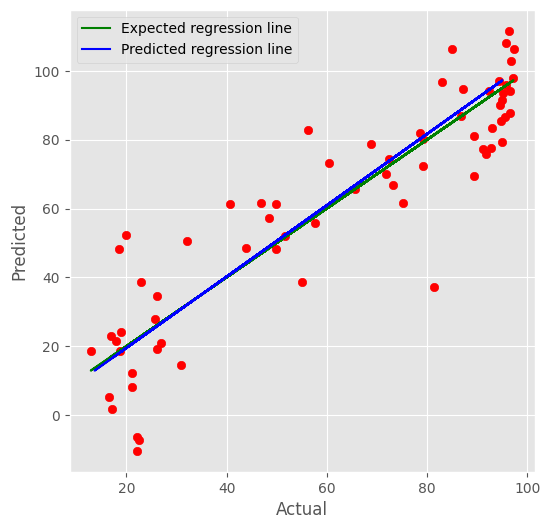

Phương trình chính quy: y = 61.367 -21.36 * X_8  + 9.998 * X_89  + 6.581 * X_182  + 1.857 * X_104 -2.827 * X_212  + 6.995 * X_50  + 5.752 * X_106  + 8.549 * X_75  + 6.32 * X_126 -1.138 * X_17  + 8.843 * X_37 -16.56 * X_141 -2.965 * X_200  + 8.057 * X_105  + 8.469 * X_120  + 7.022 * X_129  + 5.398 * X_30  + 8.913 * X_22  + 8.901 * X_127 -1.375 * X_210  + 3.543 * X_24  + 3.177 * X_79  + 1.28 * X_52 -4.748 * X_181  + 8.002 * X_172 -11.561 * X_184 -4.942 * X_201 -17.426 * X_142 -8.128 * X_112 -8.217 * X_193  + 5.668 * X_23 -4.486 * X_16  + 1.545 * X_211 -4.382 * X_71 -0.49 * X_153  + 1.251 * X_36 -0.115 * X_38 -1.357 * X_119 -5.45 * X_203 -10.299 * X_62 -6.415 * X_196  + 13.637 * X_53 -9.099 * X_87 -3.522 * X_169  + 5.252 * X_165  + 9.359 * X_84 -1.423 * X_82  + 2.892 * X_40  + 2.54 * X_144 -11.862 * X_18 -3.558 * X_46 -5.348 * X_92 -6.564 * X_32 -1.093 * X_204  + 3.961 * X_171 -16.628 * X_48  + 12.414 * X_155  + 8.252 * X_152 -11.707 * X_34 -4.062 * X_91 -3.806 * X_100  + 11.146 * X_14 -8

In [79]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'g']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


In [80]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


ValueError: illegal value in 4th argument of internal gesdd

PLS components:  30
Number Wavelengths remove:  155
MSE min:  221.24464330256066

R2 calib: 0.995
R2 CV: 0.733
MSE calib: 3.974
MSE CV: 221.245


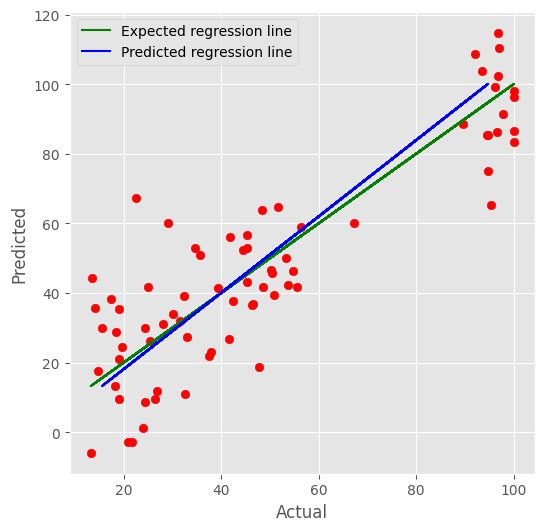

Phương trình chính quy: y = 48.906  + 32.594 * X_175 -5.859 * X_220 -17.49 * X_76  + 10.993 * X_147  + 3.382 * X_192  + 13.606 * X_179  + 13.194 * X_146 -10.721 * X_200 -8.054 * X_119  + 15.354 * X_62  + 3.524 * X_105  + 6.482 * X_52  + 2.317 * X_18 -3.89 * X_9 -3.941 * X_82  + 1.959 * X_111 -16.062 * X_194  + 5.245 * X_170  + 0.455 * X_169 -2.825 * X_23  + 17.265 * X_57  + 3.662 * X_165 -13.038 * X_166 -7.391 * X_13  + 4.978 * X_29 -22.012 * X_176 -21.977 * X_110 -14.233 * X_189  + 0.844 * X_20 -2.397 * X_163  + 17.821 * X_145  + 9.212 * X_10  + 11.561 * X_33 -1.052 * X_58 -6.587 * X_35  + 15.748 * X_191  + 4.671 * X_60 -4.326 * X_47 -13.767 * X_160  + 12.855 * X_44 -7.372 * X_116  + 16.909 * X_97 -5.252 * X_195 -10.489 * X_210 -20.795 * X_81  + 1.502 * X_174 -21.804 * X_46 -12.596 * X_199  + 20.304 * X_197  + 17.874 * X_183  + 21.091 * X_190 -20.322 * X_93 -22.008 * X_158 -7.004 * X_198  + 9.472 * X_34  + 3.734 * X_15  + 10.374 * X_32  + 7.246 * X_31 -15.089 * X_92 -3.977 * X_184  + 

In [3]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  39
Number Wavelengths remove:  150
MSE min:  219.0963441184219

R2 calib: 0.999
R2 CV: 0.736
MSE calib: 0.752
MSE CV: 219.096


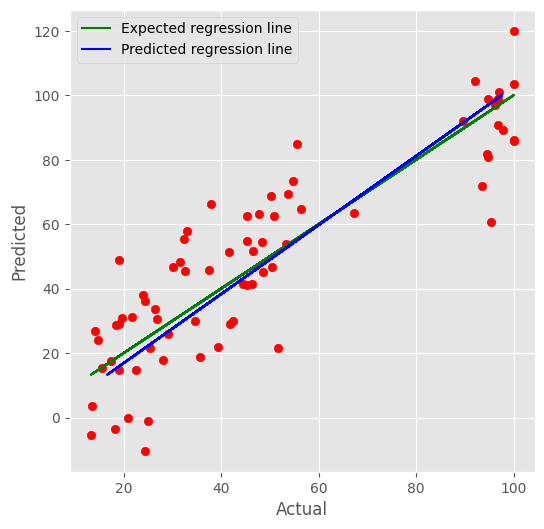

Phương trình chính quy: y = 48.896 -27.823 * X_193  + 58.899 * X_140  + 38.114 * X_122 -20.266 * X_189 -10.699 * X_196 -10.57 * X_153 -5.381 * X_74 -4.378 * X_174  + 4.735 * X_214  + 22.661 * X_152 -3.3 * X_159  + 8.527 * X_90 -6.385 * X_64 -0.667 * X_108  + 15.909 * X_116  + 24.587 * X_55  + 13.899 * X_157  + 9.495 * X_148 -16.374 * X_56 -16.663 * X_17  + 34.043 * X_125  + 5.749 * X_52  + 2.439 * X_220 -10.488 * X_51  + 13.968 * X_70 -12.06 * X_149 -14.42 * X_118  + 7.911 * X_208  + 9.852 * X_107  + 15.529 * X_59  + 24.893 * X_126  + 6.625 * X_154 -13.518 * X_213  + 7.969 * X_86  + 14.464 * X_16  + 14.697 * X_178 -21.69 * X_175 -4.762 * X_160  + 21.792 * X_215 -17.679 * X_106 -16.621 * X_75 -24.929 * X_151 -9.599 * X_158 -16.714 * X_200 -3.704 * X_25  + 5.909 * X_113  + 29.053 * X_192 -33.941 * X_119  + 8.102 * X_167 -2.706 * X_168 -4.004 * X_194  + 2.361 * X_76  + 8.325 * X_199 -35.209 * X_150  + 5.564 * X_42  + 10.518 * X_35  + 14.768 * X_36  + 10.601 * X_26  + 8.131 * X_11  + 3.186

In [4]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'b']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  21
Number Wavelengths remove:  162
MSE min:  252.04086253824525

R2 calib: 0.979
R2 CV: 0.696
MSE calib: 17.585
MSE CV: 252.041


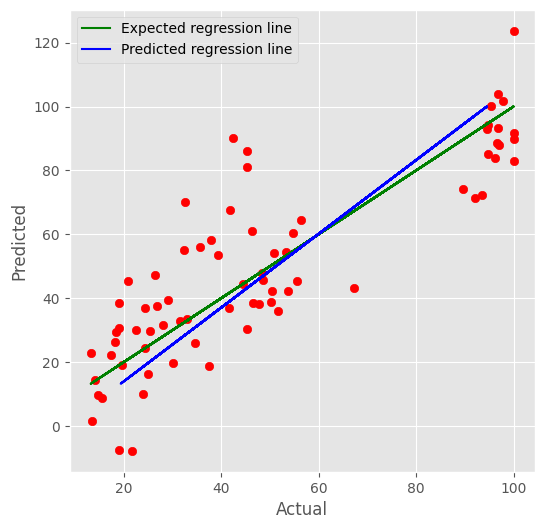

Phương trình chính quy: y = 48.892 -13.26 * X_167  + 8.493 * X_34  + 8.387 * X_156 -10.842 * X_194  + 2.694 * X_212 -17.765 * X_197 -1.319 * X_184 -6.234 * X_56  + 10.788 * X_87 -18.486 * X_116 -7.771 * X_150  + 7.46 * X_43  + 19.958 * X_22 -0.563 * X_216 -14.164 * X_47  + 13.958 * X_186  + 11.389 * X_60  + 21.383 * X_61  + 11.193 * X_177 -10.575 * X_76 -9.232 * X_103  + 9.172 * X_59 -9.853 * X_23 -14.249 * X_95 -8.232 * X_97 -26.262 * X_9  + 10.187 * X_13 -5.31 * X_166  + 2.297 * X_158  + 0.688 * X_21 -11.599 * X_180  + 13.538 * X_218 -4.671 * X_210  + 18.296 * X_159  + 7.258 * X_18  + 12.799 * X_199 -18.238 * X_149 -1.897 * X_101  + 6.04 * X_14  + 12.253 * X_182 -9.866 * X_185 -17.284 * X_41 -6.523 * X_206 -3.565 * X_16 -4.885 * X_117 -3.162 * X_29  + 17.0 * X_200  + 11.368 * X_30 -10.058 * X_162  + 1.402 * X_38  + 14.85 * X_211 -17.099 * X_102 -1.554 * X_208  + 31.173 * X_112  + 5.46 * X_93 -12.801 * X_189 -8.897 * X_120  + 6.136 * X_174  + 10.193 * X_32  + 16.782 * X_49  + 14.856 *

In [5]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'c']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  21
Number Wavelengths remove:  205
MSE min:  500.34340883547384

R2 calib: 0.771
R2 CV: 0.397
MSE calib: 189.533
MSE CV: 500.343


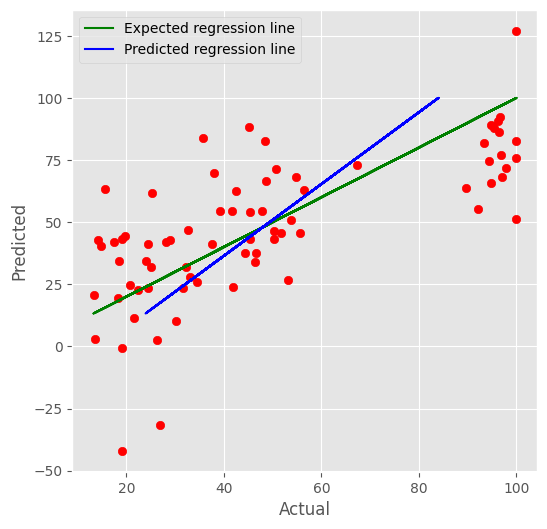

Phương trình chính quy: y = 48.919  + 32.074 * X_37  + 14.98 * X_9  + 3.887 * X_161  + 26.404 * X_65  + 10.124 * X_163  + 3.403 * X_182  + 16.859 * X_203  + 7.012 * X_193  + 8.773 * X_60  + 3.241 * X_50 -41.201 * X_32  + 15.61 * X_36  + 83.544 * X_29 -66.433 * X_27 -11.422 * X_202 -32.955 * X_170 -10.29 * X_13 -23.797 * X_184 -17.285 * X_199 -11.592 * X_176 -1.014 * X_43  + 34.822 * X_183 -9.642 * X_162 


In [6]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  12
Number Wavelengths remove:  177
MSE min:  665.9852464042826

R2 calib: 0.673
R2 CV: 0.186
MSE calib: 267.310
MSE CV: 665.985


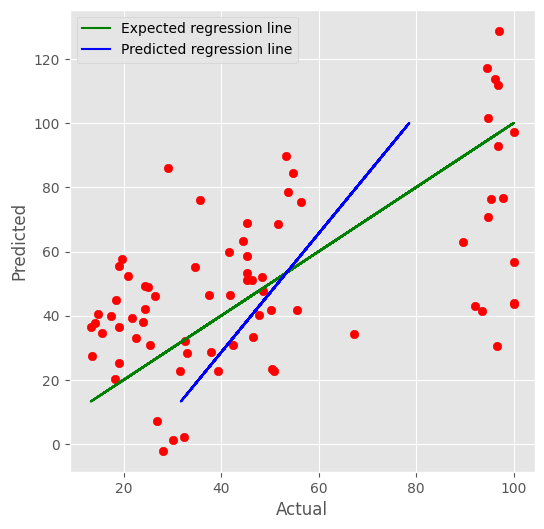

Phương trình chính quy: y = 48.911 -0.093 * X_118  + 2.416 * X_108  + 8.181 * X_194  + 0.295 * X_198  + 0.452 * X_10  + 1.173 * X_164 -7.424 * X_14  + 3.619 * X_131  + 8.05 * X_49  + 20.323 * X_91  + 8.341 * X_201 -3.166 * X_171  + 4.148 * X_21 -5.811 * X_121 -10.359 * X_172 -13.203 * X_146 -8.851 * X_123 -0.891 * X_82  + 9.57 * X_32 -8.428 * X_122  + 5.588 * X_48 -5.098 * X_184  + 8.685 * X_104  + 6.703 * X_84  + 8.129 * X_161 -2.141 * X_119 -8.452 * X_204  + 5.855 * X_20  + 6.536 * X_206 -2.901 * X_162 -8.386 * X_170  + 0.258 * X_179  + 6.756 * X_217 -5.787 * X_120 -9.33 * X_168 -4.289 * X_40  + 5.264 * X_44 -11.97 * X_193  + 4.525 * X_45  + 7.388 * X_46  + 11.158 * X_216  + 14.99 * X_31  + 9.615 * X_83  + 9.408 * X_47 -1.145 * X_39  + 19.231 * X_15 -16.316 * X_186 -15.441 * X_35 -7.61 * X_37 -15.016 * X_36 -15.236 * X_38 


In [7]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'e']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  18
Number Wavelengths remove:  177
MSE min:  573.5898819902814

R2 calib: 0.832
R2 CV: 0.318
MSE calib: 140.918
MSE CV: 573.590


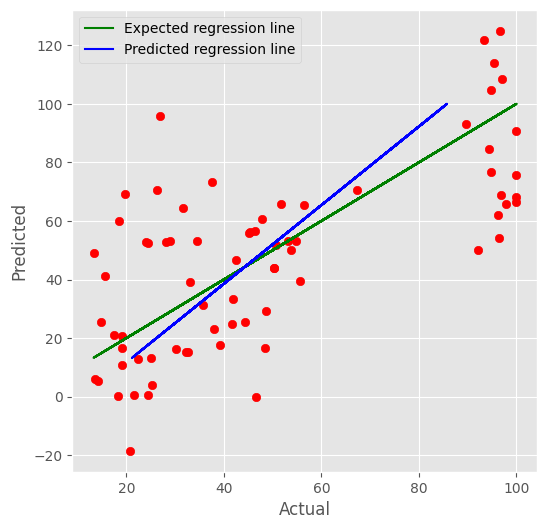

Phương trình chính quy: y = 48.875  + 33.717 * X_115  + 8.244 * X_149 -31.711 * X_107  + 7.113 * X_131  + 6.905 * X_25 -9.22 * X_139  + 3.282 * X_193  + 10.045 * X_129 -9.278 * X_13 -9.856 * X_138  + 5.326 * X_92  + 24.355 * X_113  + 9.204 * X_130  + 50.06 * X_173  + 25.065 * X_199 -14.929 * X_73 -23.927 * X_175 -14.855 * X_26 -16.863 * X_151  + 23.564 * X_157  + 55.658 * X_11  + 18.475 * X_187  + 20.026 * X_205  + 3.144 * X_189  + 27.128 * X_200  + 19.553 * X_22 -5.758 * X_183 -22.725 * X_215 -3.704 * X_208  + 10.616 * X_179  + 15.215 * X_150  + 0.037 * X_220  + 19.679 * X_86  + 34.416 * X_181 -26.507 * X_176 -41.454 * X_74  + 7.602 * X_197 -17.363 * X_15  + 23.765 * X_164 -12.055 * X_182  + 18.003 * X_24  + 26.608 * X_23  + 2.054 * X_186  + 19.676 * X_145 -21.49 * X_93 -21.988 * X_192  + 27.38 * X_165  + 3.077 * X_206 -9.173 * X_185 -27.399 * X_196  + 24.518 * X_174 


In [8]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'f']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  5
Number Wavelengths remove:  221
MSE min:  445.05117855655044

R2 calib: 0.541
R2 CV: 0.463
MSE calib: 380.678
MSE CV: 445.051


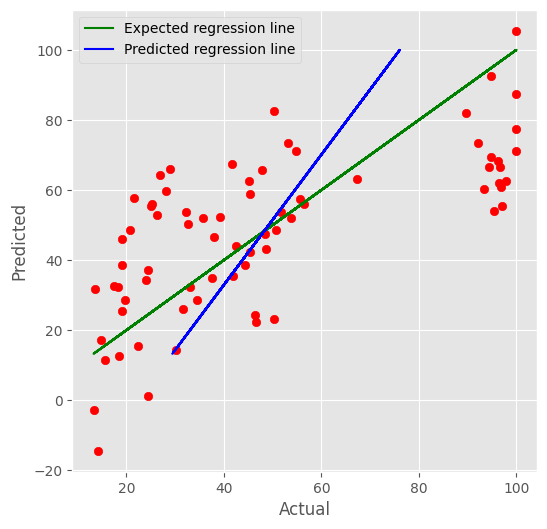

Phương trình chính quy: y = 48.932 -12.333 * X_73  + 1.697 * X_83 -7.486 * X_193 -0.534 * X_74  + 39.791 * X_64  + 5.87 * X_84 -18.642 * X_63 


In [9]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'g']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  4
Number Wavelengths remove:  190
MSE min:  553.4964461584439

R2 calib: 0.484
R2 CV: 0.333
MSE calib: 428.202
MSE CV: 553.496


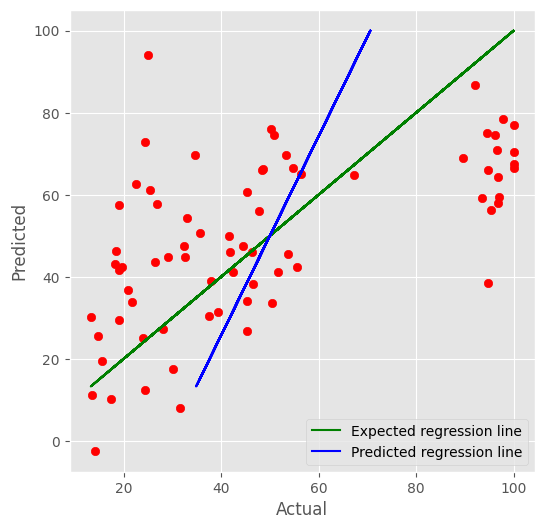

Phương trình chính quy: y = 48.957 -1.667 * X_221 -1.667 * X_225 -1.667 * X_226 -1.667 * X_223 -1.667 * X_222 -1.667 * X_224 -1.667 * X_228 -1.667 * X_227  + 1.422 * X_84 -1.413 * X_73 -0.107 * X_12  + 3.999 * X_156  + 0.111 * X_62 -1.589 * X_49 -1.313 * X_41  + 0.411 * X_87  + 2.691 * X_15 -2.95 * X_195 -0.986 * X_42 -2.344 * X_191  + 2.558 * X_66  + 2.615 * X_171  + 3.188 * X_159  + 1.269 * X_14 -1.721 * X_47 -2.051 * X_48 -1.766 * X_43 -1.914 * X_44  + 2.812 * X_65  + 1.329 * X_85  + 2.709 * X_170 -2.042 * X_46  + 2.787 * X_158 -2.187 * X_45  + 1.666 * X_86  + 2.931 * X_64  + 0.881 * X_13  + 2.976 * X_63 


In [10]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  15
Number Wavelengths remove:  169
MSE min:  32.462463703786014

R2 calib: 1.000
R2 CV: 0.967
MSE calib: 0.171
MSE CV: 32.462


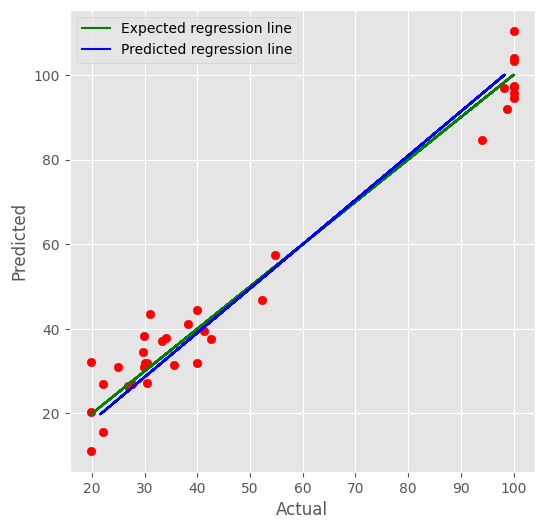

Phương trình chính quy: y = 51.333  + 2.362 * X_202 -2.434 * X_183  + 3.607 * X_27 -1.769 * X_101 -0.016 * X_77  + 3.199 * X_16 -2.804 * X_100 -1.698 * X_20 -4.45 * X_159 -0.76 * X_91 -4.407 * X_79 -0.347 * X_103 -0.279 * X_22 -3.405 * X_23 -0.01 * X_195 -0.523 * X_11 -0.649 * X_105 -2.63 * X_120 -5.436 * X_68  + 4.023 * X_167 -2.956 * X_160 -4.331 * X_72 -2.436 * X_97 -6.511 * X_62 -4.618 * X_70 -2.641 * X_193 -1.961 * X_187 -2.566 * X_182 -1.209 * X_109  + 5.055 * X_9  + 3.65 * X_178 -3.157 * X_106  + 2.265 * X_48  + 2.902 * X_40 -3.239 * X_92 -1.865 * X_114 -3.854 * X_85 -2.748 * X_200 -3.316 * X_107 -2.128 * X_108 -3.691 * X_86 -3.865 * X_99 -1.958 * X_112 -2.061 * X_104  + 2.285 * X_54 -2.905 * X_219 -4.307 * X_69  + 4.818 * X_53  + 1.864 * X_203  + 3.551 * X_43 -5.788 * X_98 -3.508 * X_95 -3.155 * X_119 -5.402 * X_21 -2.722 * X_96  + 5.755 * X_44 -4.714 * X_161 -3.8 * X_31  + 6.884 * X_47 


In [11]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  9
Number Wavelengths remove:  167
MSE min:  127.09083009646653

R2 calib: 0.991
R2 CV: 0.869
MSE calib: 8.922
MSE CV: 127.091


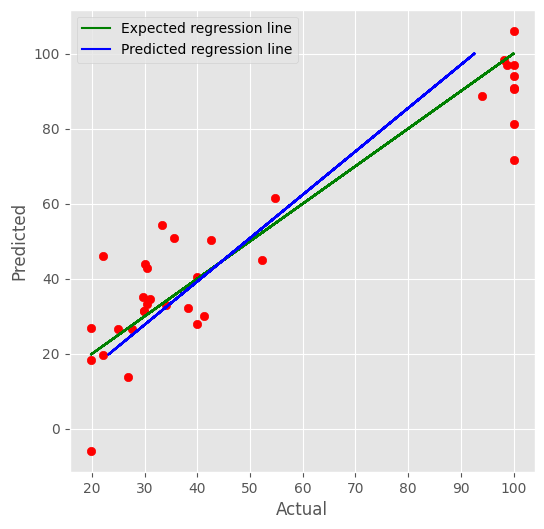

Phương trình chính quy: y = 51.336  + 1.622 * X_179 -0.681 * X_97 -2.912 * X_196 -1.191 * X_189 -3.244 * X_49  + 1.498 * X_18 -2.82 * X_40 -2.674 * X_206 -1.913 * X_80 -3.463 * X_66 -2.794 * X_93 -1.483 * X_82  + 0.455 * X_175  + 1.261 * X_29 -2.788 * X_109 -2.616 * X_117  + 3.231 * X_28  + 1.657 * X_157  + 1.053 * X_44 -0.285 * X_84 -2.096 * X_191 -5.56 * X_15  + 2.273 * X_12 -2.944 * X_113 -1.462 * X_96 -2.98 * X_169  + 2.933 * X_202  + 3.402 * X_166 -2.717 * X_98 -1.248 * X_37 -4.587 * X_65  + 3.505 * X_53  + 2.867 * X_134 -2.131 * X_114  + 2.515 * X_158 -0.876 * X_38  + 3.103 * X_195 -0.95 * X_41  + 2.627 * X_30 -3.836 * X_204 -1.708 * X_194 -3.866 * X_211  + 2.99 * X_181 -1.741 * X_89 -3.609 * X_21 -4.067 * X_208  + 2.358 * X_46 -2.262 * X_197  + 2.277 * X_120 -3.738 * X_110 -2.967 * X_94  + 3.103 * X_45 -1.294 * X_87 -3.648 * X_20 -5.253 * X_47 -3.634 * X_85  + 3.315 * X_178 -5.187 * X_163 -1.515 * X_86 -5.129 * X_190 -6.043 * X_192 


In [12]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'b']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  19
Number Wavelengths remove:  208
MSE min:  155.57924788483905

R2 calib: 0.980
R2 CV: 0.840
MSE calib: 19.888
MSE CV: 155.579


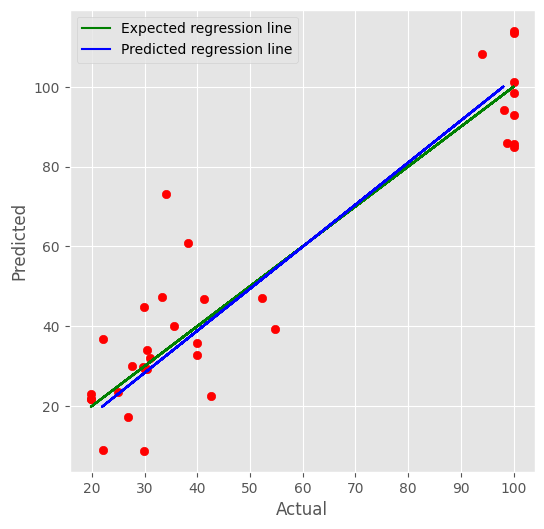

Phương trình chính quy: y = 51.337 -8.318 * X_83  + 4.295 * X_181  + 8.94 * X_16  + 16.339 * X_160  + 3.426 * X_51 -2.981 * X_193  + 5.908 * X_113  + 8.238 * X_157 -5.884 * X_21 -11.364 * X_159  + 10.173 * X_46  + 2.744 * X_97 -6.391 * X_211  + 5.192 * X_178  + 6.376 * X_53 -21.286 * X_114  + 8.693 * X_12 -10.32 * X_49 -3.257 * X_31 -20.425 * X_96 


In [13]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'c']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  11
Number Wavelengths remove:  190
MSE min:  467.8671866809573

R2 calib: 0.961
R2 CV: 0.519
MSE calib: 37.896
MSE CV: 467.867


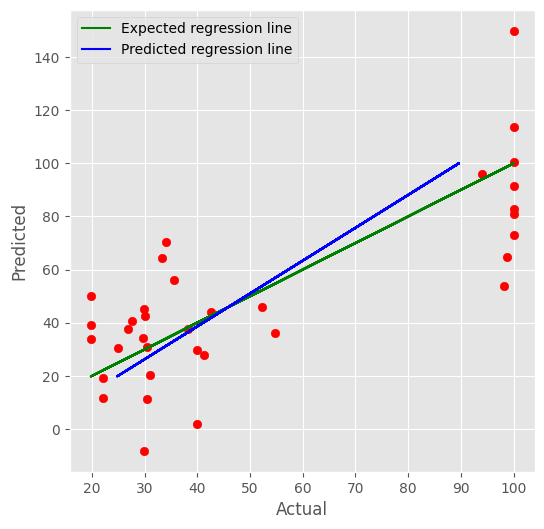

Phương trình chính quy: y = 51.329 -6.58 * X_179  + 7.855 * X_53  + 0.708 * X_165 -10.464 * X_195 -11.886 * X_90 -7.384 * X_94  + 1.814 * X_166  + 6.799 * X_181 -4.069 * X_160 -7.288 * X_210 -7.012 * X_56 -3.361 * X_28 -2.835 * X_190 -8.119 * X_22 -5.555 * X_95  + 1.113 * X_35 -3.965 * X_88  + 8.234 * X_117  + 5.429 * X_43  + 1.36 * X_200 -11.84 * X_189 -1.377 * X_41  + 3.852 * X_201 -8.097 * X_30  + 6.401 * X_44 -5.563 * X_192  + 12.293 * X_202 -11.143 * X_161 -6.75 * X_79  + 14.399 * X_45 -10.86 * X_48 -9.452 * X_54 -6.858 * X_50 -2.891 * X_36  + 12.785 * X_86  + 3.475 * X_12  + 9.422 * X_25 -3.562 * X_193 


In [14]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  13
Number Wavelengths remove:  161
MSE min:  102.37879684172111

R2 calib: 0.999
R2 CV: 0.895
MSE calib: 0.572
MSE CV: 102.379


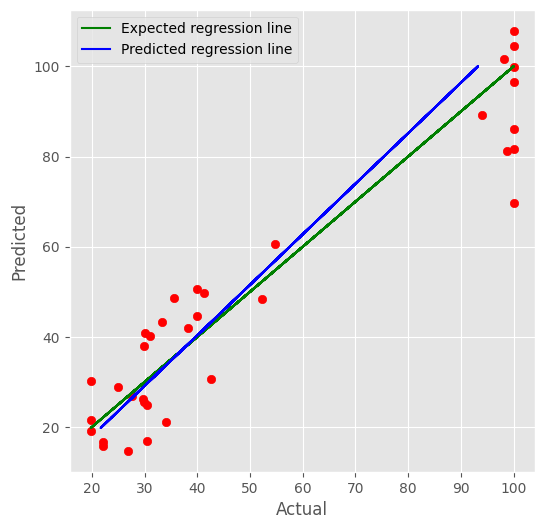

Phương trình chính quy: y = 51.327  + 1.191 * X_2  + 1.191 * X_7  + 1.191 * X_4  + 1.191 * X_3  + 1.191 * X_5  + 1.191 * X_6  + 1.191 * X_1  + 3.46 * X_58 -3.84 * X_134 -2.649 * X_78  + 3.044 * X_219  + 3.398 * X_17  + 2.523 * X_99  + 2.03 * X_106  + 3.104 * X_57 -2.992 * X_210  + 1.147 * X_28 -3.022 * X_118  + 3.123 * X_184 -1.396 * X_42  + 0.211 * X_27  + 1.232 * X_150  + 2.442 * X_172 -4.704 * X_14 -1.437 * X_25 -1.693 * X_37  + 2.081 * X_62 -0.185 * X_183  + 5.272 * X_18  + 1.475 * X_21  + 1.45 * X_199 -3.465 * X_36 -3.047 * X_182 -3.846 * X_177  + 2.413 * X_179  + 3.736 * X_98  + 3.884 * X_56 -4.145 * X_40 -5.462 * X_39  + 1.724 * X_204  + 2.824 * X_93 -3.195 * X_186 -1.743 * X_175 -1.937 * X_120  + 3.972 * X_101  + 4.1 * X_100  + 2.361 * X_173  + 2.736 * X_194 -5.204 * X_43 -3.532 * X_35 -1.892 * X_121  + 0.074 * X_153  + 3.063 * X_217  + 4.385 * X_19 -4.617 * X_119 -5.23 * X_26  + 5.022 * X_154  + 3.292 * X_20  + 3.57 * X_170 -2.16 * X_202  + 5.619 * X_196 -4.237 * X_12 -4.928 *

In [15]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'e']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  17
Number Wavelengths remove:  178
MSE min:  155.44822463780346

R2 calib: 0.999
R2 CV: 0.840
MSE calib: 0.839
MSE CV: 155.448


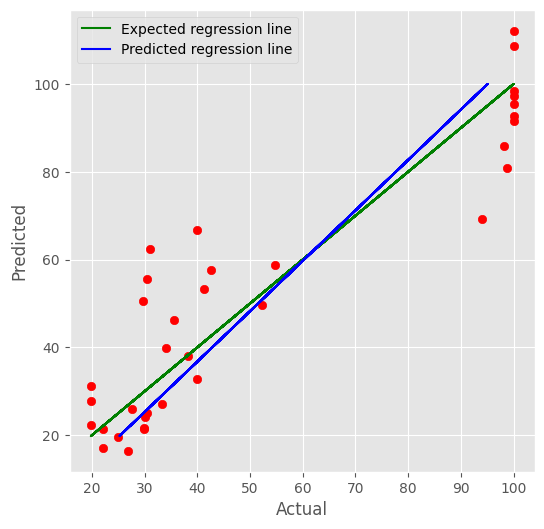

Phương trình chính quy: y = 51.366 -9.631 * X_34  + 2.328 * X_75  + 6.026 * X_23  + 0.487 * X_220 -1.52 * X_161 -0.164 * X_87  + 0.147 * X_115  + 1.899 * X_28  + 3.362 * X_22 -2.193 * X_116  + 5.97 * X_51 -0.442 * X_84 -2.352 * X_169  + 2.466 * X_208 -4.903 * X_165  + 3.686 * X_21  + 1.013 * X_107  + 5.245 * X_170  + 6.157 * X_98  + 1.586 * X_103  + 2.304 * X_25 -5.296 * X_43 -8.289 * X_29 -5.76 * X_93 -4.342 * X_201 -5.698 * X_203 -0.904 * X_159  + 2.083 * X_19  + 2.29 * X_215  + 2.27 * X_52  + 2.941 * X_20  + 5.115 * X_26 -3.11 * X_181  + 1.104 * X_210 -4.982 * X_183  + 6.241 * X_100 -10.722 * X_163 -5.503 * X_42  + 5.128 * X_27  + 12.823 * X_45 -9.994 * X_148 -6.044 * X_95  + 8.149 * X_10 -9.279 * X_47  + 5.938 * X_12  + 8.987 * X_101 -5.183 * X_164 -3.861 * X_180  + 7.253 * X_11 -8.641 * X_189 


In [16]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'f']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  10
Number Wavelengths remove:  156
MSE min:  385.48662003970605

R2 calib: 0.990
R2 CV: 0.604
MSE calib: 10.055
MSE CV: 385.487


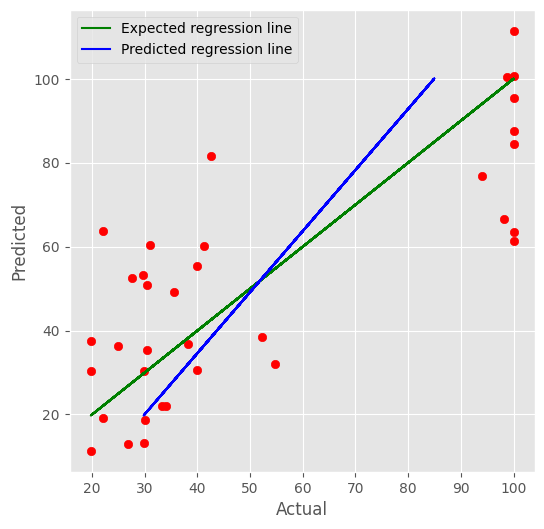

Phương trình chính quy: y = 51.4 -3.503 * X_228 -3.503 * X_227 -3.503 * X_221  + 0.309 * X_197  + 1.44 * X_136  + 4.649 * X_109  + 0.385 * X_195  + 1.298 * X_137 -1.891 * X_127 -1.756 * X_128 -1.719 * X_79 -0.736 * X_11  + 3.443 * X_21  + 2.387 * X_202 -2.025 * X_126 -4.851 * X_208  + 3.89 * X_110 -1.558 * X_29 -3.082 * X_88  + 3.452 * X_216 -3.798 * X_95  + 2.522 * X_133  + 3.768 * X_17  + 1.879 * X_135 -1.896 * X_77 -5.133 * X_38  + 4.155 * X_19 -3.308 * X_34 -5.549 * X_39 -4.202 * X_94  + 5.288 * X_31 -3.004 * X_181 -6.122 * X_37  + 2.863 * X_134 -1.703 * X_211  + 0.373 * X_162  + 2.34 * X_1  + 2.34 * X_2  + 2.34 * X_3  + 2.34 * X_4  + 2.34 * X_5  + 2.34 * X_6  + 2.34 * X_7  + 2.34 * X_8 -1.704 * X_218 -5.497 * X_40  + 4.937 * X_20 -2.018 * X_212  + 3.31 * X_199  + 3.401 * X_191 -2.593 * X_149  + 3.946 * X_189 -4.318 * X_28  + 4.853 * X_167 -3.748 * X_209  + 4.395 * X_175  + 1.91 * X_161 -3.751 * X_214  + 2.797 * X_206 -6.604 * X_83 -3.789 * X_182 -2.34 * X_183 -4.834 * X_194  + 4.6

In [17]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'g']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  17
Number Wavelengths remove:  210
MSE min:  422.5838597438061

R2 calib: 0.913
R2 CV: 0.565
MSE calib: 84.911
MSE CV: 422.584


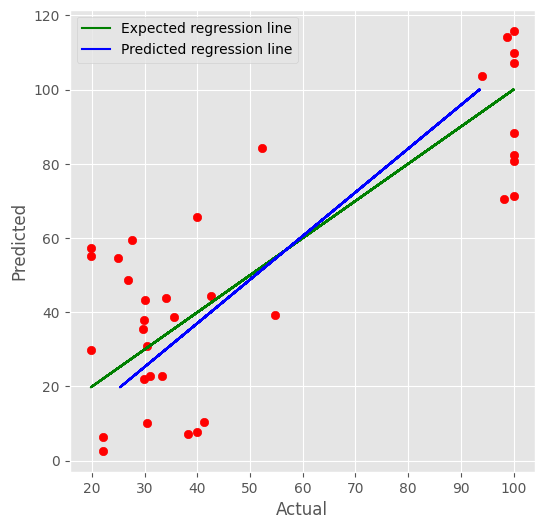

Phương trình chính quy: y = 51.437  + 12.69 * X_171  + 10.186 * X_160  + 8.532 * X_82 -38.603 * X_15 -8.26 * X_84 -12.483 * X_198 -8.121 * X_36  + 2.508 * X_182 -29.861 * X_157  + 29.525 * X_16  + 0.953 * X_149  + 13.416 * X_191  + 6.166 * X_208  + 12.829 * X_175  + 18.045 * X_203  + 20.617 * X_213 -7.171 * X_14  + 31.855 * X_155 


In [18]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/TVB/TVB_N_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-2], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-2])
X = np.array(data2.values[:, 3:-2])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  14
Number Wavelengths remove:  196
MSE min:  53.25075326675051

R2 calib: 0.874
R2 CV: 0.646
MSE calib: 18.937
MSE CV: 53.251


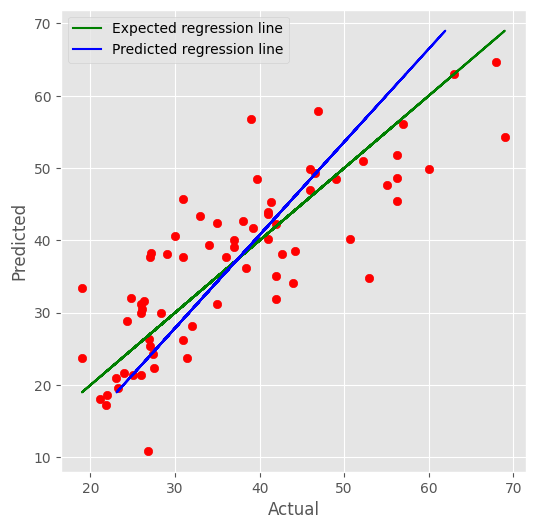

Phương trình chính quy: y = 37.215 -2.329 * X_191 -15.48 * X_72 -5.365 * X_170 -10.065 * X_99  + 8.328 * X_219 -5.731 * X_25  + 10.814 * X_180  + 1.433 * X_32  + 0.437 * X_207 -0.075 * X_33  + 4.401 * X_166  + 5.659 * X_163 -12.414 * X_91 -5.366 * X_171 -7.714 * X_161  + 2.438 * X_193 -5.819 * X_189 -1.983 * X_23  + 4.431 * X_48 -2.511 * X_198  + 5.827 * X_167 -10.271 * X_34 -5.218 * X_24  + 0.123 * X_203  + 9.366 * X_63 -5.707 * X_183 -3.442 * X_184  + 12.761 * X_18  + 7.653 * X_190 -3.465 * X_175  + 10.83 * X_195 -11.65 * X_182 


In [19]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/do_tuoi/TVB_N/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  20
Number Wavelengths remove:  173
MSE min:  40.1938216850352

R2 calib: 0.972
R2 CV: 0.720
MSE calib: 3.970
MSE CV: 40.194


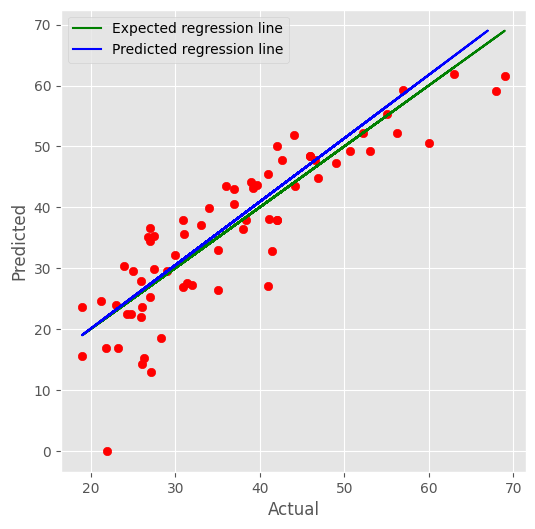

Phương trình chính quy: y = 36.672  + 2.363 * X_204  + 2.089 * X_150  + 8.002 * X_9  + 2.841 * X_172  + 0.523 * X_117 -0.765 * X_27  + 7.404 * X_19  + 3.443 * X_71  + 6.637 * X_142  + 0.839 * X_47 -3.027 * X_211  + 4.403 * X_92  + 4.192 * X_199  + 2.664 * X_31 -1.199 * X_100  + 0.667 * X_166  + 3.286 * X_168  + 5.745 * X_15 -5.506 * X_97 -2.061 * X_217  + 7.129 * X_112 -0.41 * X_82 -0.294 * X_198  + 7.229 * X_111 -1.278 * X_183  + 2.492 * X_190  + 1.119 * X_181  + 1.82 * X_17  + 5.567 * X_162  + 3.25 * X_171  + 5.931 * X_52  + 1.887 * X_88  + 2.326 * X_152 -4.733 * X_74 -0.948 * X_23  + 5.661 * X_50  + 8.894 * X_63 -1.765 * X_26 -0.037 * X_49 -0.201 * X_187  + 6.114 * X_77  + 0.296 * X_178 -6.697 * X_145  + 7.771 * X_51  + 1.151 * X_207  + 7.581 * X_216 -2.115 * X_72  + 4.765 * X_170  + 3.706 * X_185  + 4.155 * X_175  + 2.275 * X_189  + 1.525 * X_176  + 6.384 * X_194 -8.09 * X_73  + 6.259 * X_219 


In [20]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/do_tuoi/TVB_N/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  37
Number Wavelengths remove:  163
MSE min:  596.19107736404

R2 calib: 0.995
R2 CV: 0.849
MSE calib: 18.820
MSE CV: 596.191


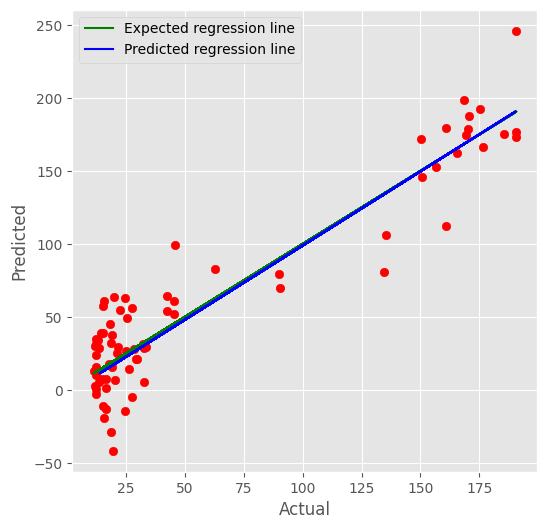

Phương trình chính quy: y = 58.961 -47.683 * X_41 -32.861 * X_198  + 10.564 * X_72 -28.991 * X_193  + 29.43 * X_29 -67.413 * X_90 -137.947 * X_126 -46.008 * X_83 -9.411 * X_19  + 1.938 * X_159  + 82.549 * X_32  + 92.061 * X_27  + 13.605 * X_71 -6.18 * X_59 -26.545 * X_183 -42.935 * X_162  + 38.688 * X_87  + 3.977 * X_175 -14.207 * X_103  + 35.416 * X_21  + 142.068 * X_122 -22.981 * X_178 -12.252 * X_148  + 8.341 * X_189 -79.769 * X_76  + 34.232 * X_14 -47.006 * X_26  + 37.915 * X_105  + 2.021 * X_197 -40.284 * X_118  + 88.13 * X_57  + 25.846 * X_25 -26.093 * X_168 -46.619 * X_31  + 29.416 * X_22  + 43.458 * X_184 -42.301 * X_64 -15.973 * X_15  + 46.43 * X_206 -19.939 * X_47 -77.926 * X_39  + 70.19 * X_58 -71.734 * X_9 -50.087 * X_16 -8.07 * X_51  + 86.078 * X_36 -115.639 * X_106  + 96.84 * X_112 -44.734 * X_117  + 15.05 * X_77 -55.732 * X_149 -146.946 * X_104  + 45.568 * X_200  + 68.356 * X_165 -83.091 * X_150 -25.736 * X_167  + 46.627 * X_43 -33.234 * X_194 -61.179 * X_186 -55.477 * X

In [21]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/do_tuoi/TVB_N/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  10
Number Wavelengths remove:  191
MSE min:  1760.2169557043728

R2 calib: 0.752
R2 CV: 0.553
MSE calib: 977.456
MSE CV: 1760.217


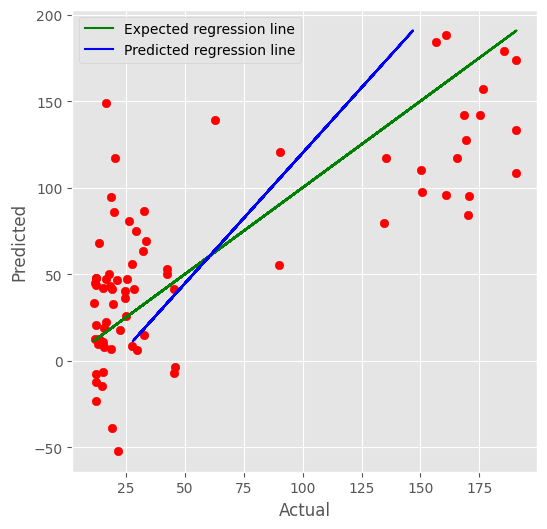

Phương trình chính quy: y = 59.003 -21.881 * X_122 -4.099 * X_100 -29.285 * X_105  + 19.516 * X_116  + 20.039 * X_35 -10.073 * X_204 -8.516 * X_118  + 6.951 * X_199 -15.813 * X_143  + 20.621 * X_148  + 2.778 * X_190 -18.474 * X_196 -24.299 * X_121  + 11.302 * X_111  + 12.913 * X_112  + 13.534 * X_156  + 17.061 * X_113 -6.273 * X_99  + 6.675 * X_49 -12.228 * X_47  + 13.349 * X_115 -10.78 * X_119 -1.064 * X_96  + 0.167 * X_157 -15.604 * X_98  + 14.867 * X_114 -23.446 * X_120 -18.943 * X_189 -8.21 * X_147 -1.384 * X_97  + 12.142 * X_48 -30.776 * X_145 -15.84 * X_146 -8.897 * X_176  + 24.883 * X_206  + 14.096 * X_13  + 28.125 * X_158 


In [22]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/do_tuoi/TVB_N/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  23
Number Wavelengths remove:  185
MSE min:  297.0630701472197

R2 calib: 1.000
R2 CV: 0.871
MSE calib: 0.001
MSE CV: 297.063


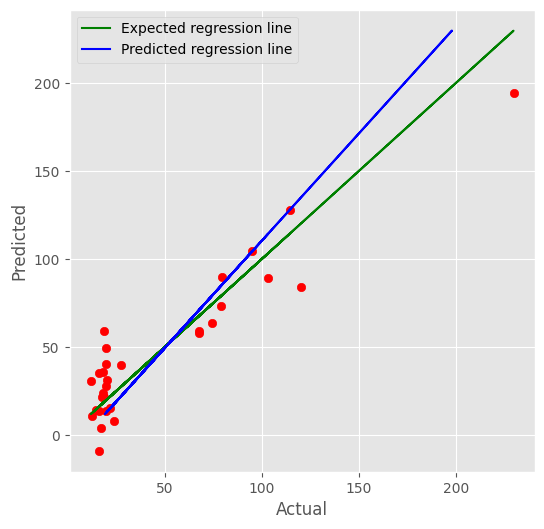

Phương trình chính quy: y = 46.69  + 10.27 * X_17  + 7.616 * X_36  + 11.04 * X_167 -3.355 * X_72  + 6.958 * X_13 -7.166 * X_37 -11.623 * X_157  + 2.258 * X_71  + 6.362 * X_41 -6.536 * X_195 -1.409 * X_200 -6.759 * X_99  + 6.509 * X_11 -8.695 * X_186 -5.772 * X_115 -1.097 * X_113 -2.625 * X_158 -10.588 * X_182  + 2.868 * X_188  + 10.573 * X_189  + 5.831 * X_14  + 7.365 * X_47 -0.533 * X_25  + 7.164 * X_16 -11.73 * X_94 -8.681 * X_70 -7.873 * X_84  + 10.742 * X_30 -9.247 * X_20 -3.557 * X_114  + 7.219 * X_46 -6.478 * X_199 -15.326 * X_161 -13.097 * X_29 -8.572 * X_183 -11.146 * X_21  + 1.958 * X_33 -4.252 * X_95 -9.43 * X_98  + 4.609 * X_51 -2.785 * X_22 -19.071 * X_96 -0.324 * X_97 


In [23]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/do_tuoi/TVB_N/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  12
Number Wavelengths remove:  209
MSE min:  662.0526732083101

R2 calib: 0.962
R2 CV: 0.711
MSE calib: 88.278
MSE CV: 662.053


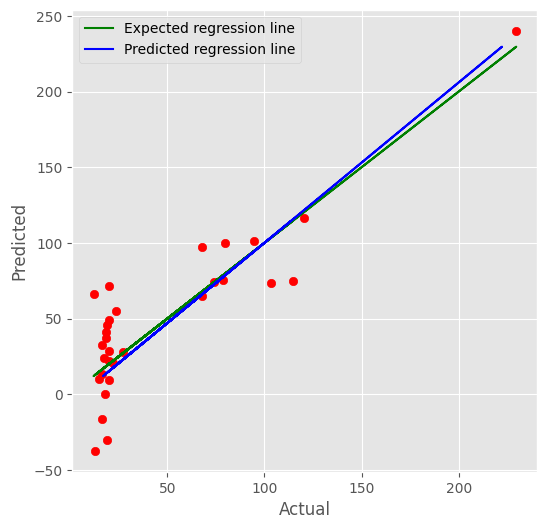

Phương trình chính quy: y = 46.605  + 29.919 * X_84  + 6.13 * X_12  + 15.69 * X_25 -14.703 * X_82 -14.926 * X_83 -29.321 * X_162 -7.296 * X_191 -10.566 * X_176  + 9.257 * X_170 -1.79 * X_29  + 2.974 * X_198  + 10.117 * X_174 -35.217 * X_86 -31.737 * X_212  + 18.243 * X_168 -19.395 * X_178  + 3.097 * X_210 -18.382 * X_85  + 2.545 * X_197 


In [24]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/do_tuoi/TVB_N/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


In [ ]:
df= pd.read_csv("D:/NIR/10_9_2022/Histamin_gop_file.csv")

df_histamin = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/So_lieu_do_tuoi.csv",encoding='utf-8-sig')
# #print(df,df_histamin)

# #df.merge(df_histamin, on='Mã mẫu').drop(['STT','Khối lượng \n(g)','Chiều dài\n(cm)','Độ ẩm\n(%)','Protein\n(%)','Lipid\n(%)','Tro\n(%)'],axis=1)

# ctv3 = pd.merge(df, df_histamin, on='Mã mẫu').drop(['STT','Khối lượng \n(g)','Chiều dài\n(cm)','Độ ẩm\n(%)','Protein\n(%)','Lipid\n(%)','Tro\n(%)'],axis=1)

# ctv3.to_csv("D:/VSC Code/Histamin cá/Book1.csv", index = False, encoding='utf-8-sig')        
         

PLS components:  21
Number Wavelengths remove:  175
MSE min:  0.4457064282890727

R2 calib: 0.983
R2 CV: 0.739
MSE calib: 0.029
MSE CV: 0.446


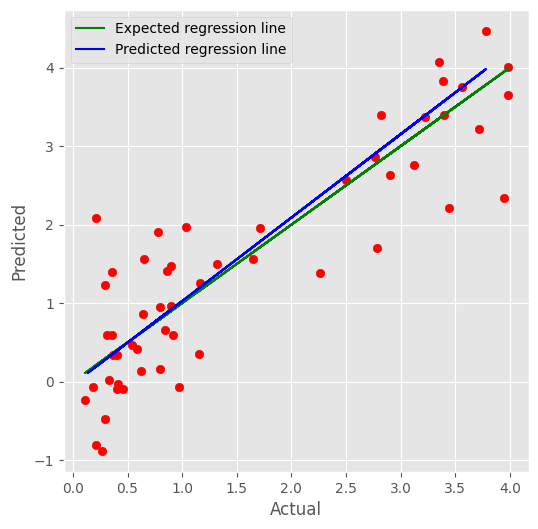

Phương trình chính quy: y = 1.527  + 0.364 * X_24 -0.29 * X_85  + 0.312 * X_31 -0.189 * X_175 -0.558 * X_65 -0.059 * X_34 -0.037 * X_99  + 0.362 * X_206  + 0.556 * X_41  + 0.63 * X_130  + 0.271 * X_203  + 0.566 * X_131  + 0.516 * X_199 -1.157 * X_119  + 0.261 * X_132 -0.018 * X_73  + 0.494 * X_205  + 0.322 * X_116  + 0.17 * X_186  + 0.395 * X_197 -0.255 * X_172  + 0.082 * X_133  + 0.346 * X_10 -0.259 * X_166 -0.524 * X_178 -0.009 * X_49  + 0.443 * X_184 -0.24 * X_216 -0.389 * X_174  + 0.436 * X_46  + 0.314 * X_198  + 0.43 * X_209 -0.523 * X_40  + 0.234 * X_187 -0.516 * X_214 -0.473 * X_100  + 0.7 * X_196 -0.42 * X_33  + 0.751 * X_18  + 0.604 * X_218 -0.702 * X_176  + 0.254 * X_189 -0.425 * X_215  + 0.463 * X_161 -0.585 * X_20  + 0.493 * X_47  + 0.678 * X_48 -0.505 * X_165 -1.184 * X_120 -0.029 * X_188 -0.919 * X_101  + 0.997 * X_163  + 0.633 * X_17 


In [25]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  31
Number Wavelengths remove:  157
MSE min:  0.2937671182126342

R2 calib: 1.000
R2 CV: 0.828
MSE calib: 0.001
MSE CV: 0.294


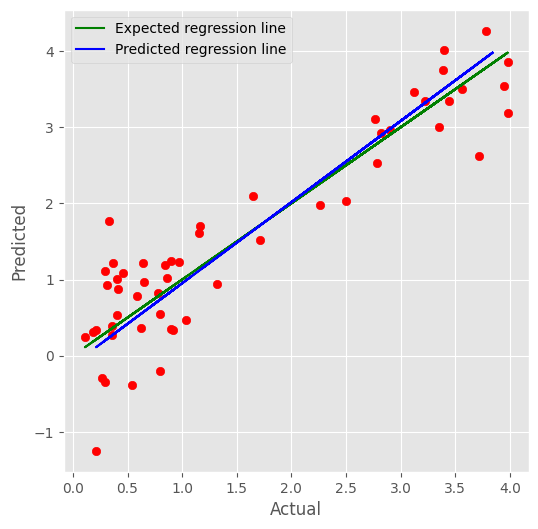

Phương trình chính quy: y = 1.526  + 0.541 * X_148 -0.631 * X_213  + 0.424 * X_131 -0.076 * X_31 -0.235 * X_193 -0.12 * X_156  + 0.473 * X_132  + 0.517 * X_133  + 0.776 * X_63  + 0.46 * X_60  + 0.735 * X_74 -0.086 * X_202 -0.804 * X_142 -0.202 * X_115 -0.397 * X_171  + 0.319 * X_178  + 0.56 * X_88 -0.051 * X_113  + 0.459 * X_42 -0.05 * X_23  + 0.356 * X_49 -0.531 * X_180 -0.358 * X_106 -0.474 * X_26 -0.43 * X_162  + 0.054 * X_55  + 0.009 * X_120 -0.662 * X_119 -0.571 * X_215 -0.614 * X_52 -0.426 * X_99  + 0.16 * X_16  + 0.264 * X_87 -0.205 * X_38 -0.177 * X_85  + 0.65 * X_207 -0.603 * X_141  + 0.182 * X_102  + 0.398 * X_183 -0.602 * X_45 -0.716 * X_116 -0.582 * X_201 -0.19 * X_194  + 0.028 * X_174  + 0.21 * X_134  + 0.394 * X_19 -0.17 * X_54  + 0.478 * X_10 -0.542 * X_117  + 0.577 * X_206  + 0.122 * X_14 -0.576 * X_218 -0.468 * X_43  + 0.412 * X_50 -1.055 * X_76  + 0.002 * X_27 -0.59 * X_86 -0.143 * X_118  + 0.43 * X_135 -0.441 * X_105  + 0.29 * X_191 -0.681 * X_71  + 0.598 * X_28  + 0

In [26]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'b']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  15
Number Wavelengths remove:  166
MSE min:  0.775486204877189

R2 calib: 0.966
R2 CV: 0.545
MSE calib: 0.057
MSE CV: 0.775


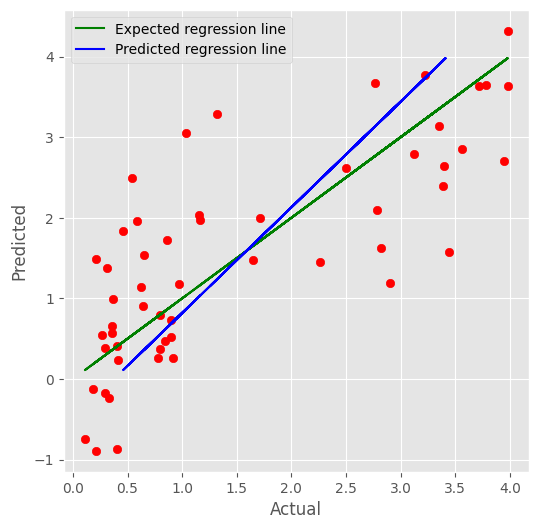

Phương trình chính quy: y = 1.533  + 0.576 * X_189  + 0.852 * X_13  + 0.458 * X_138 -0.56 * X_46 -0.273 * X_204  + 0.44 * X_113  + 0.243 * X_55  + 0.074 * X_16  + 0.222 * X_29 -0.527 * X_103 -0.506 * X_88 -0.332 * X_15  + 0.468 * X_136  + 0.685 * X_152 -0.609 * X_105 -0.084 * X_144 -0.467 * X_120 -0.287 * X_157  + 0.078 * X_218 -0.116 * X_72  + 0.47 * X_48  + 0.69 * X_181 -0.045 * X_184 -0.13 * X_91 -0.935 * X_79  + 0.287 * X_165 -0.429 * X_169  + 0.063 * X_57  + 0.68 * X_190  + 0.255 * X_97  + 0.236 * X_32  + 0.301 * X_39  + 0.371 * X_164 -0.522 * X_206  + 0.061 * X_47 -0.258 * X_156  + 0.473 * X_116 -0.479 * X_209 -0.481 * X_188  + 0.387 * X_56 -0.411 * X_199 -0.368 * X_163  + 0.264 * X_192  + 0.318 * X_172  + 0.738 * X_70 -0.522 * X_35  + 0.259 * X_178  + 0.598 * X_100 -0.4 * X_208  + 0.392 * X_34 -0.66 * X_177 -0.423 * X_202  + 0.021 * X_51 -0.596 * X_24 -0.513 * X_170  + 0.463 * X_193 -0.727 * X_203 -0.601 * X_49 -0.598 * X_76 -0.75 * X_219  + 1.033 * X_174 -0.877 * X_77 


In [27]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'c']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  22
Number Wavelengths remove:  186
MSE min:  0.942755604163736

R2 calib: 0.968
R2 CV: 0.447
MSE calib: 0.054
MSE CV: 0.943


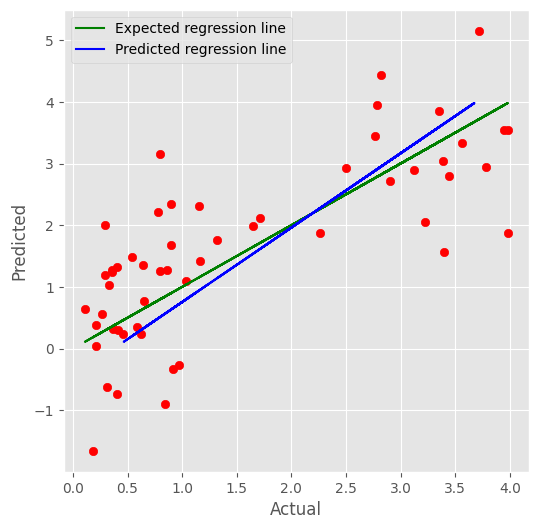

Phương trình chính quy: y = 1.532 -1.917 * X_102  + 1.523 * X_46 -0.655 * X_173  + 0.839 * X_31  + 1.987 * X_83 -1.146 * X_186 -1.06 * X_199  + 0.771 * X_159 -0.776 * X_51  + 0.281 * X_61  + 0.223 * X_66 -0.124 * X_161  + 1.104 * X_27 -0.768 * X_24 -0.837 * X_32  + 1.546 * X_91 -0.018 * X_174 -0.063 * X_193 -0.756 * X_25  + 1.515 * X_10 -1.333 * X_68  + 1.66 * X_16  + 0.179 * X_105  + 0.899 * X_188 -1.236 * X_113  + 0.015 * X_209  + 0.397 * X_182  + 1.366 * X_100 -0.594 * X_56 -2.156 * X_168 -1.941 * X_206 -0.635 * X_165  + 1.266 * X_134  + 0.463 * X_176 -0.22 * X_162 -1.202 * X_70  + 0.771 * X_72 -0.242 * X_65 -1.225 * X_38  + 0.081 * X_183  + 0.722 * X_189  + 1.043 * X_194 


In [28]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  24
Number Wavelengths remove:  166
MSE min:  0.9714224861319057

R2 calib: 0.993
R2 CV: 0.431
MSE calib: 0.012
MSE CV: 0.971


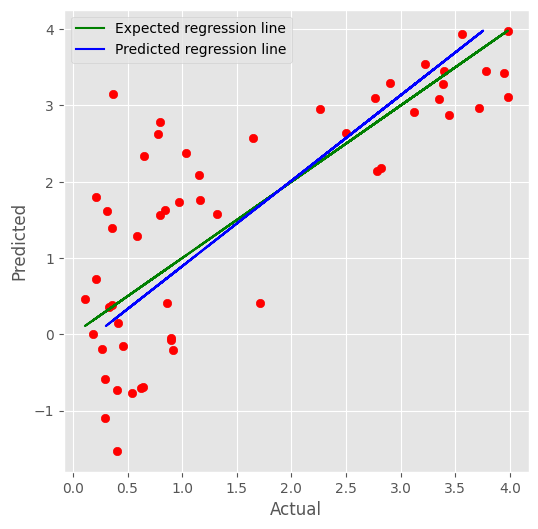

Phương trình chính quy: y = 1.527  + 0.471 * X_178 -0.594 * X_83 -0.483 * X_154  + 0.604 * X_205 -0.312 * X_168  + 0.494 * X_195  + 0.25 * X_21 -0.07 * X_208  + 0.091 * X_27 -0.372 * X_194  + 0.174 * X_199  + 0.106 * X_39 -0.093 * X_157  + 0.048 * X_49 -0.141 * X_96 -0.464 * X_17  + 0.514 * X_151  + 1.432 * X_9  + 0.673 * X_47 -0.378 * X_214 -1.047 * X_116 -1.281 * X_74 -0.391 * X_198 -0.027 * X_197  + 0.995 * X_53  + 0.179 * X_48 -0.688 * X_15  + 0.12 * X_217 -0.308 * X_43  + 0.419 * X_25  + 0.009 * X_81 -0.412 * X_82 -0.154 * X_190  + 0.661 * X_203 -0.3 * X_163 -0.26 * X_118  + 0.279 * X_187  + 0.573 * X_158 -0.374 * X_147 -0.232 * X_216  + 0.198 * X_52  + 1.087 * X_20 -0.21 * X_200 -0.477 * X_218  + 0.388 * X_12 -0.491 * X_31  + 0.251 * X_185 -0.776 * X_93  + 0.665 * X_29 -0.865 * X_146 -0.255 * X_94 -0.917 * X_215  + 0.341 * X_219 -0.615 * X_95  + 0.475 * X_80 -1.267 * X_90  + 0.223 * X_192 -0.211 * X_153  + 0.57 * X_28  + 0.483 * X_202  + 0.608 * X_156  + 0.851 * X_11 


In [29]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'e']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  8
Number Wavelengths remove:  167
MSE min:  0.6805505521850579

R2 calib: 0.857
R2 CV: 0.601
MSE calib: 0.244
MSE CV: 0.681


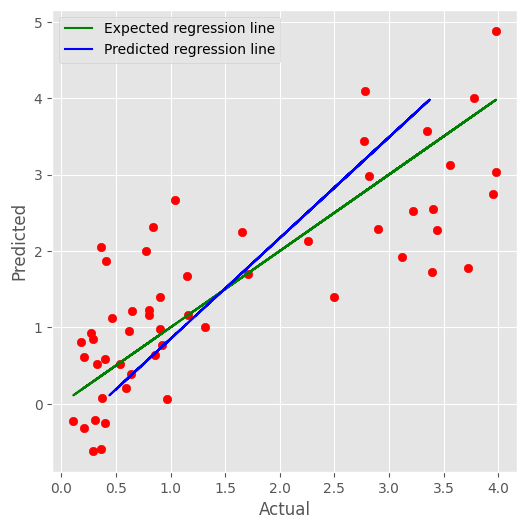

Phương trình chính quy: y = 1.531 -0.073 * X_66 -0.179 * X_102 -0.136 * X_144 -0.11 * X_171  + 0.132 * X_28 -0.088 * X_65  + 0.079 * X_86  + 0.038 * X_13 -0.102 * X_217  + 0.043 * X_49 -0.013 * X_188  + 0.038 * X_168  + 0.037 * X_211 -0.088 * X_218  + 0.113 * X_76 -0.186 * X_146  + 0.049 * X_173  + 0.079 * X_169 -0.118 * X_64 -0.193 * X_142 -0.125 * X_71 -0.108 * X_62  + 0.238 * X_164 -0.053 * X_186 -0.001 * X_175  + 0.092 * X_48  + 0.047 * X_14  + 0.089 * X_212 -0.157 * X_151  + 0.079 * X_12  + 0.071 * X_116 -0.191 * X_202 -0.153 * X_189  + 0.091 * X_209  + 0.076 * X_53  + 0.077 * X_52 -0.193 * X_143 -0.114 * X_184  + 0.091 * X_119 -0.056 * X_172 -0.194 * X_179  + 0.11 * X_50 -0.113 * X_205 -0.184 * X_63  + 0.151 * X_176  + 0.242 * X_77  + 0.141 * X_117  + 0.141 * X_199  + 0.149 * X_16  + 0.124 * X_15 -0.111 * X_185  + 0.143 * X_174 -0.185 * X_206  + 0.084 * X_51  + 0.177 * X_210  + 0.16 * X_17  + 0.14 * X_166  + 0.19 * X_10  + 0.192 * X_11  + 0.21 * X_118  + 0.299 * X_194 


In [30]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'f']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  28
Number Wavelengths remove:  150
MSE min:  0.6534565625727673

R2 calib: 1.000
R2 CV: 0.617
MSE calib: 0.001
MSE CV: 0.653


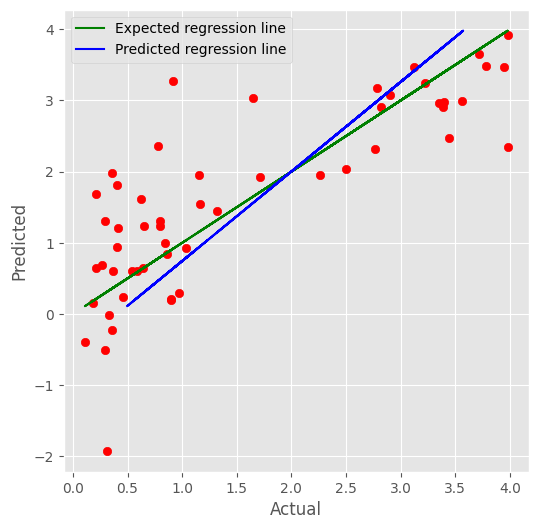

Phương trình chính quy: y = 1.532 -0.498 * X_46 -0.183 * X_190 -0.251 * X_38 -0.015 * X_76 -0.211 * X_58  + 0.109 * X_156  + 0.328 * X_100  + 0.178 * X_152 -0.182 * X_59 -0.31 * X_69 -0.038 * X_208  + 0.199 * X_89  + 0.12 * X_150  + 0.273 * X_220  + 0.047 * X_204  + 0.173 * X_157 -0.151 * X_171 -0.503 * X_96  + 0.324 * X_32  + 0.376 * X_88 -0.15 * X_149 -0.131 * X_22  + 0.074 * X_53 -0.434 * X_34 -0.429 * X_118  + 0.014 * X_24  + 0.334 * X_86 -0.064 * X_173 -0.359 * X_185 -0.254 * X_196 -0.054 * X_31  + 0.419 * X_50  + 0.097 * X_210 -0.286 * X_57 -0.176 * X_60  + 0.005 * X_61 -0.272 * X_161 -0.451 * X_176  + 0.166 * X_198 -0.286 * X_18  + 0.261 * X_193 -0.213 * X_27 -0.333 * X_71 -0.427 * X_85  + 0.286 * X_37 -0.107 * X_170  + 0.577 * X_13 -0.327 * X_70  + 0.265 * X_30 -0.11 * X_122  + 0.467 * X_165 -0.094 * X_199  + 0.068 * X_12  + 0.441 * X_77  + 0.357 * X_90  + 0.345 * X_29 -0.302 * X_217  + 0.08 * X_191 -0.499 * X_179  + 0.33 * X_174  + 0.55 * X_15  + 0.361 * X_177 -0.14 * X_213  +

In [31]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'g']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  4
Number Wavelengths remove:  173
MSE min:  1.0506479511998916

R2 calib: 0.699
R2 CV: 0.384
MSE calib: 0.513
MSE CV: 1.051


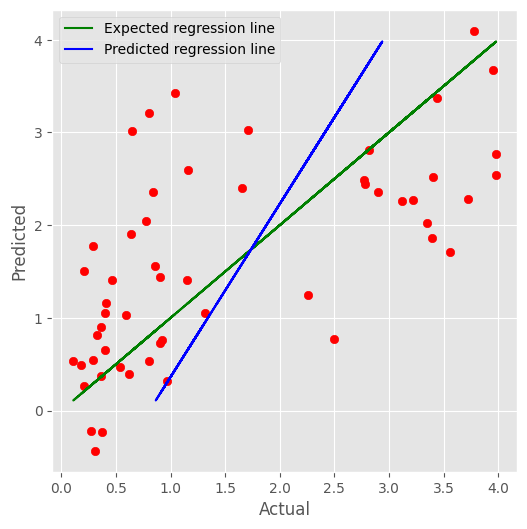

Phương trình chính quy: y = 1.533 -0.059 * X_58  + 0.146 * X_154  + 0.121 * X_166  + 0.037 * X_33  + 0.069 * X_32  + 0.09 * X_90  + 0.017 * X_111  + 0.04 * X_171 -0.056 * X_205 -0.066 * X_57 -0.082 * X_187  + 0.064 * X_64  + 0.013 * X_109  + 0.043 * X_150  + 0.054 * X_89 -0.018 * X_210 -0.065 * X_56 -0.051 * X_53 -0.029 * X_95  + 0.05 * X_191  + 0.057 * X_63 -0.064 * X_54 -0.061 * X_55  + 0.02 * X_87 -0.09 * X_43 -0.174 * X_121  + 0.034 * X_170  + 0.037 * X_108  + 0.024 * X_85 -0.145 * X_117  + 0.065 * X_107  + 0.013 * X_180  + 0.034 * X_62  + 0.136 * X_173  + 0.026 * X_110  + 0.068 * X_168 -0.158 * X_118  + 0.127 * X_15 -0.04 * X_218  + 0.22 * X_24 -0.192 * X_119  + 0.074 * X_102 -0.081 * X_219  + 0.079 * X_105  + 0.094 * X_104 -0.181 * X_120  + 0.073 * X_86  + 0.106 * X_83 -0.12 * X_40  + 0.08 * X_88 -0.103 * X_39 -0.113 * X_42 -0.128 * X_41  + 0.088 * X_106  + 0.083 * X_82 


In [32]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  16
Number Wavelengths remove:  190
MSE min:  0.3477860318937871

R2 calib: 0.914
R2 CV: 0.463
MSE calib: 0.056
MSE CV: 0.348


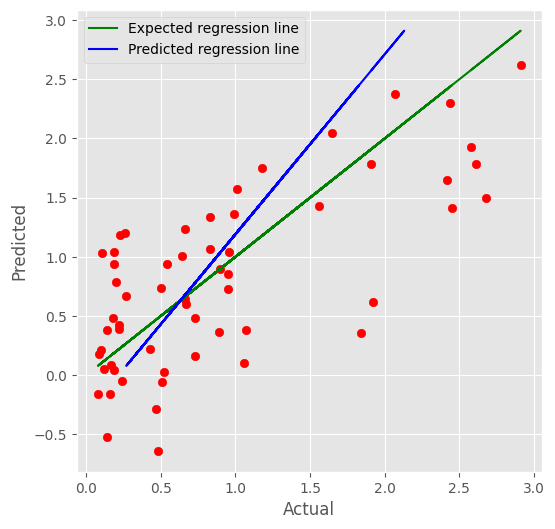

Phương trình chính quy: y = 0.892 -0.755 * X_40 -0.235 * X_83  + 0.466 * X_121 -0.103 * X_60  + 0.003 * X_30  + 0.133 * X_52  + 0.432 * X_216 -0.263 * X_84  + 0.033 * X_165  + 0.489 * X_61  + 0.357 * X_49 -0.176 * X_11 -0.187 * X_209 -0.406 * X_15  + 0.535 * X_164  + 0.301 * X_214  + 0.478 * X_36 -0.782 * X_206  + 0.229 * X_39 -0.142 * X_168  + 0.259 * X_182  + 0.399 * X_62 -0.229 * X_101  + 0.117 * X_51 -0.07 * X_12 -0.439 * X_176 -0.334 * X_184  + 0.392 * X_58  + 0.185 * X_189 -0.359 * X_119 -0.194 * X_208 -0.757 * X_212 -0.516 * X_118 -0.279 * X_167 -0.514 * X_50  + 0.348 * X_24 -0.775 * X_100 -0.799 * X_162 


In [33]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  26
Number Wavelengths remove:  171
MSE min:  0.19352991202159192

R2 calib: 0.994
R2 CV: 0.701
MSE calib: 0.004
MSE CV: 0.194


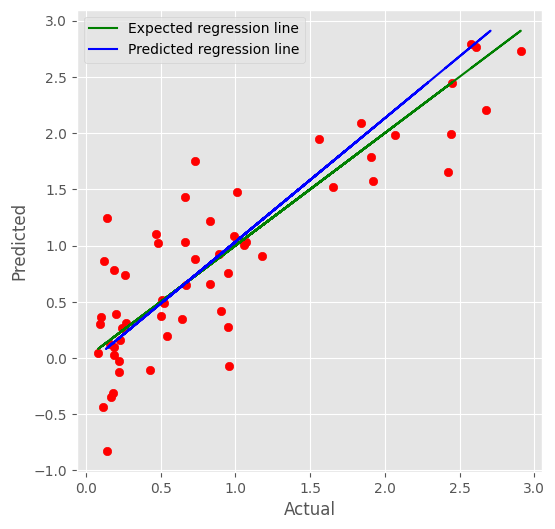

Phương trình chính quy: y = 0.891 -0.363 * X_16 -0.371 * X_197 -0.473 * X_79 -0.328 * X_108  + 0.048 * X_162 -0.261 * X_176  + 0.146 * X_214  + 0.365 * X_95  + 0.112 * X_38 -0.568 * X_140  + 0.332 * X_161 -0.701 * X_153 -0.202 * X_100 -0.037 * X_193  + 0.084 * X_174  + 0.09 * X_40 -0.012 * X_28  + 0.114 * X_32  + 0.139 * X_209 -0.492 * X_93 -0.28 * X_119 -0.223 * X_163 -0.31 * X_94  + 0.175 * X_90 -0.268 * X_18 -0.5 * X_191 -0.346 * X_85  + 0.472 * X_21  + 0.584 * X_60 -0.319 * X_101 -0.427 * X_25 -0.165 * X_48 -0.48 * X_11 -0.272 * X_180 -0.074 * X_199 -0.198 * X_200  + 0.318 * X_168  + 0.575 * X_61  + 0.433 * X_64  + 0.434 * X_39 -0.26 * X_62  + 0.023 * X_111  + 0.491 * X_183 -0.343 * X_99 -0.202 * X_75 -0.525 * X_167 -0.351 * X_97  + 0.128 * X_63 -0.088 * X_188 -0.28 * X_98 -0.383 * X_186  + 0.546 * X_86 -0.242 * X_194  + 0.014 * X_170  + 0.384 * X_212 -0.399 * X_204 -0.604 * X_9 


In [34]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'b']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  37
Number Wavelengths remove:  155
MSE min:  0.24482124329690594

R2 calib: 1.000
R2 CV: 0.622
MSE calib: 0.000
MSE CV: 0.245


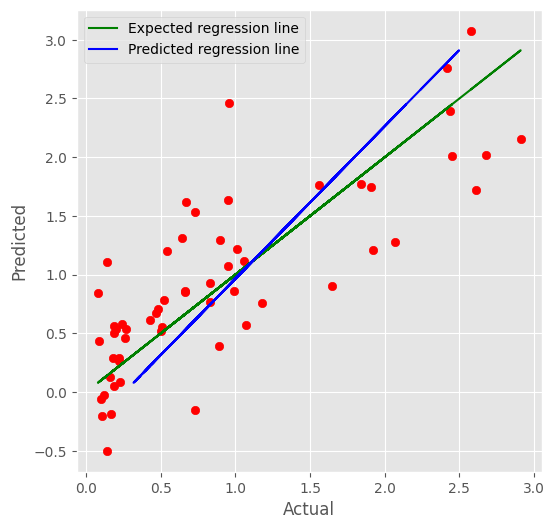

Phương trình chính quy: y = 0.891 -0.496 * X_66 -0.236 * X_71  + 0.464 * X_202  + 0.329 * X_170 -0.007 * X_150  + 0.176 * X_105 -0.087 * X_200  + 0.385 * X_49  + 0.069 * X_145 -0.307 * X_120 -0.479 * X_153 -0.082 * X_218  + 0.376 * X_209 -0.009 * X_206  + 0.168 * X_217 -0.332 * X_183 -0.047 * X_109  + 0.122 * X_147  + 0.013 * X_211 -0.373 * X_191  + 0.432 * X_108  + 0.734 * X_59  + 0.424 * X_180  + 0.14 * X_177  + 0.255 * X_216 -0.01 * X_58 -0.069 * X_87  + 0.066 * X_28  + 0.367 * X_198  + 0.06 * X_192  + 0.178 * X_45  + 0.057 * X_184 -0.389 * X_152 -0.397 * X_178 -0.497 * X_99  + 0.324 * X_18  + 0.427 * X_11  + 0.001 * X_94  + 0.332 * X_85  + 0.208 * X_23  + 0.222 * X_149 -0.617 * X_188  + 0.109 * X_148  + 0.163 * X_158  + 0.069 * X_20 -0.286 * X_185  + 0.183 * X_220  + 0.631 * X_115  + 0.182 * X_55  + 0.391 * X_169  + 0.52 * X_146  + 0.64 * X_182 -0.593 * X_195 -0.804 * X_181 -0.201 * X_189 -0.429 * X_100 -0.228 * X_197  + 0.41 * X_42  + 0.639 * X_117 -0.196 * X_163 -0.726 * X_93 -0.

In [35]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'c']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  12
Number Wavelengths remove:  185
MSE min:  0.21102041171993202

R2 calib: 0.882
R2 CV: 0.674
MSE calib: 0.077
MSE CV: 0.211


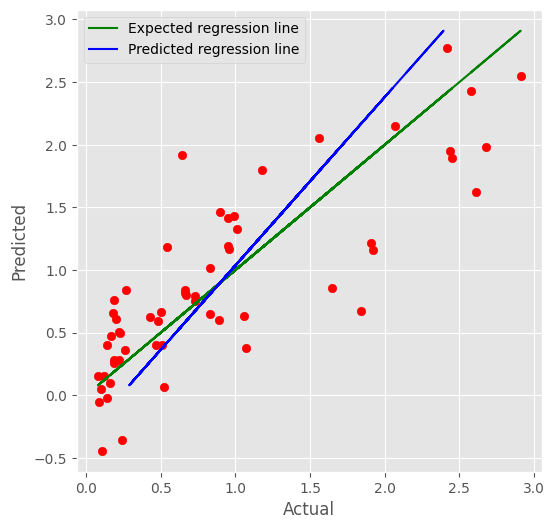

Phương trình chính quy: y = 0.892 -0.481 * X_169 -0.096 * X_210  + 0.057 * X_109  + 0.239 * X_58 -0.18 * X_93 -0.208 * X_121 -0.066 * X_42  + 0.111 * X_61  + 0.183 * X_67 -0.017 * X_205 -0.024 * X_209  + 0.047 * X_214  + 0.136 * X_37  + 0.139 * X_163  + 0.144 * X_60 -0.03 * X_21  + 0.148 * X_48  + 0.024 * X_54  + 0.117 * X_186  + 0.251 * X_72 -0.065 * X_94  + 0.086 * X_73  + 0.016 * X_111 -0.293 * X_12 -0.079 * X_174  + 0.049 * X_36  + 0.171 * X_212  + 0.086 * X_46 -0.254 * X_120  + 0.092 * X_112  + 0.036 * X_213 -0.024 * X_95 -0.224 * X_22  + 0.217 * X_43  + 0.336 * X_68 -0.154 * X_208  + 0.449 * X_24 -0.063 * X_18 -0.113 * X_19  + 0.218 * X_31 -0.281 * X_20  + 0.109 * X_47  + 0.315 * X_55 


In [36]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  4
Number Wavelengths remove:  223
MSE min:  0.5885713126611274

R2 calib: 0.365
R2 CV: 0.091
MSE calib: 0.411
MSE CV: 0.589


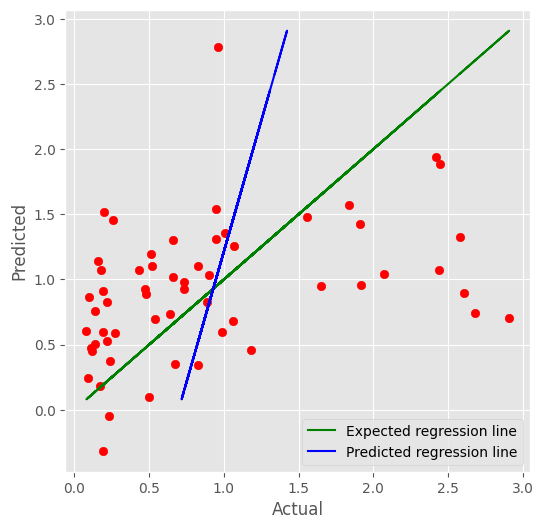

Phương trình chính quy: y = 0.892  + 0.788 * X_15  + 0.136 * X_213  + 0.458 * X_12  + 0.277 * X_13 -0.185 * X_14 


In [37]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'e']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  3
Number Wavelengths remove:  224
MSE min:  0.6677870187939076

R2 calib: 0.175
R2 CV: -0.031
MSE calib: 0.534
MSE CV: 0.668


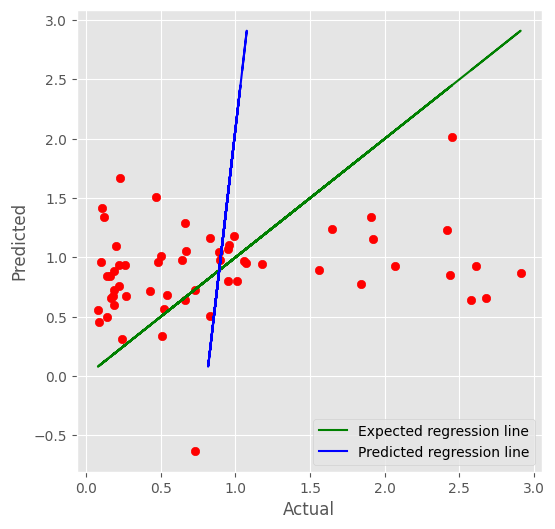

Phương trình chính quy: y = 0.891  + 0.161 * X_86  + 0.303 * X_89 -0.016 * X_87  + 0.185 * X_14 


In [38]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'f']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  7
Number Wavelengths remove:  168
MSE min:  0.3471675964231614

R2 calib: 0.788
R2 CV: 0.464
MSE calib: 0.137
MSE CV: 0.347


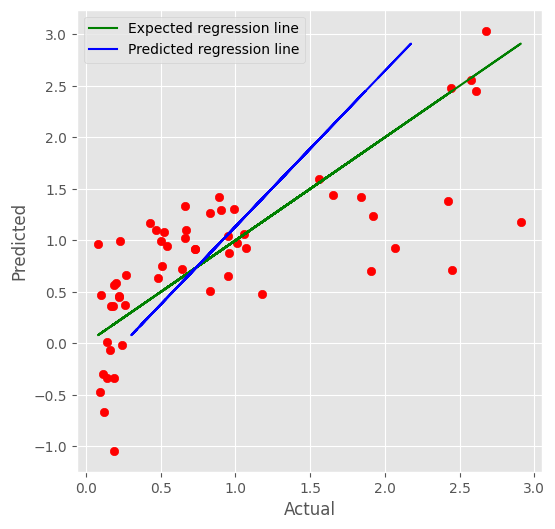

Phương trình chính quy: y = 0.891  + 0.018 * X_117 -0.012 * X_150 -0.022 * X_162  + 0.028 * X_118  + 0.127 * X_161  + 0.047 * X_19 -0.008 * X_190  + 0.108 * X_23  + 0.1 * X_220  + 0.096 * X_69  + 0.064 * X_21  + 0.032 * X_18 -0.008 * X_151  + 0.008 * X_209  + 0.069 * X_174  + 0.045 * X_110 -0.019 * X_199  + 0.039 * X_114  + 0.068 * X_203  + 0.088 * X_178  + 0.048 * X_111  + 0.026 * X_16 -0.042 * X_218 -0.025 * X_212  + 0.084 * X_147  + 0.035 * X_115 -0.048 * X_159  + 0.029 * X_206  + 0.037 * X_116  + 0.077 * X_112  + 0.07 * X_20  + 0.003 * X_191 -0.06 * X_153 -0.045 * X_73  + 0.075 * X_113 -0.061 * X_217  + 0.084 * X_176  + 0.021 * X_85 -0.016 * X_210 -0.116 * X_172 -0.056 * X_78  + 0.111 * X_177  + 0.031 * X_181  + 0.062 * X_17 -0.055 * X_79  + 0.093 * X_87  + 0.04 * X_83 -0.032 * X_160 -0.042 * X_192 -0.05 * X_211 -0.047 * X_77 -0.06 * X_76 -0.087 * X_75 -0.096 * X_74 -0.07 * X_205  + 0.05 * X_84  + 0.054 * X_187 -0.091 * X_193  + 0.096 * X_86  + 0.156 * X_175 


In [39]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'g']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  2
Number Wavelengths remove:  219
MSE min:  0.5142559035473122

R2 calib: 0.349
R2 CV: 0.206
MSE calib: 0.422
MSE CV: 0.514


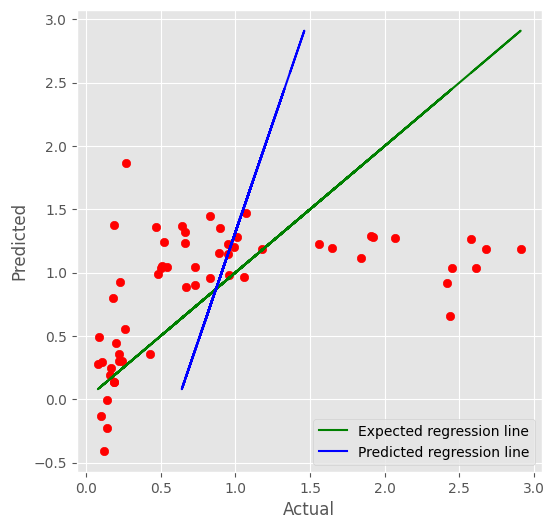

Phương trình chính quy: y = 0.892 -0.1 * X_48  + 0.116 * X_65  + 0.035 * X_170  + 0.046 * X_174  + 0.116 * X_64  + 0.051 * X_171  + 0.048 * X_173  + 0.1 * X_63  + 0.06 * X_172 


In [40]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  12
Number Wavelengths remove:  189
MSE min:  0.0022234159543290262

R2 calib: 0.988
R2 CV: 0.317
MSE calib: 0.000
MSE CV: 0.002


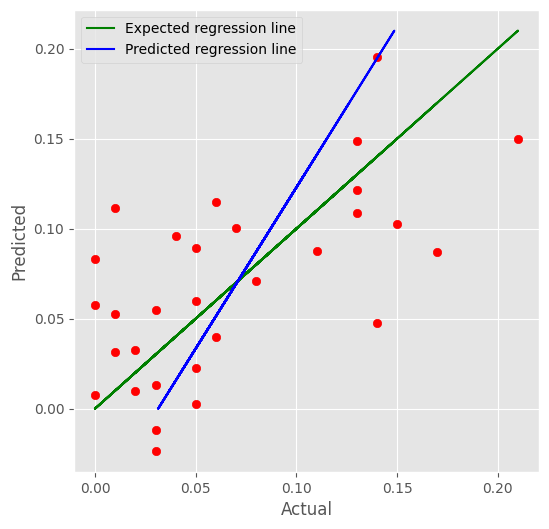

Phương trình chính quy: y = 0.067 -0.021 * X_78 -0.002 * X_193 -0.019 * X_185  + 0.021 * X_166 -0.024 * X_186 -0.014 * X_208  + 0.003 * X_16 -0.006 * X_116  + 0.001 * X_161  + 0.011 * X_93  + 0.023 * X_23  + 0.022 * X_174 -0.027 * X_164 -0.022 * X_33 -0.02 * X_210  + 0.0 * X_120  + 0.008 * X_86  + 0.002 * X_216  + 0.002 * X_50  + 0.017 * X_213  + 0.015 * X_162  + 0.023 * X_27 -0.011 * X_12 -0.006 * X_113 -0.021 * X_189  + 0.01 * X_182  + 0.01 * X_200  + 0.013 * X_63 -0.001 * X_114  + 0.009 * X_219 -0.014 * X_115  + 0.021 * X_119  + 0.017 * X_62 -0.015 * X_203 -0.012 * X_77 -0.018 * X_76  + 0.019 * X_192 -0.031 * X_47  + 0.014 * X_11 


In [41]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'a']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  11
Number Wavelengths remove:  207
MSE min:  0.0008776703377811229

R2 calib: 0.964
R2 CV: 0.730
MSE calib: 0.000
MSE CV: 0.001


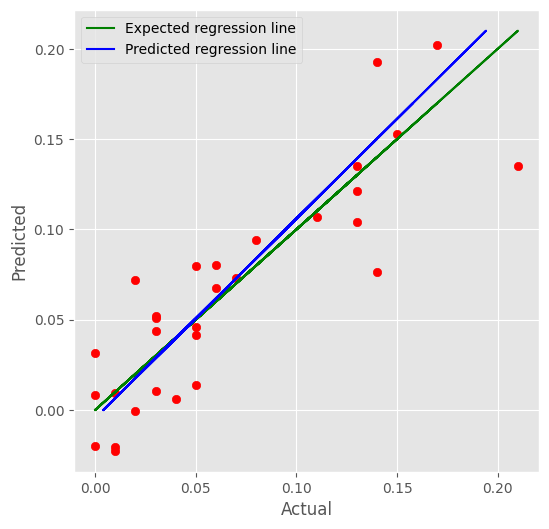

Phương trình chính quy: y = 0.067  + 0.043 * X_91  + 0.024 * X_81  + 0.012 * X_17  + 0.002 * X_181  + 0.014 * X_211  + 0.017 * X_215  + 0.032 * X_180 -0.022 * X_20  + 0.035 * X_54  + 0.0 * X_213  + 0.027 * X_214 -0.014 * X_53 -0.024 * X_34 -0.022 * X_212  + 0.024 * X_158  + 0.017 * X_157  + 0.033 * X_119 -0.013 * X_115 -0.006 * X_16  + 0.013 * X_120 -0.022 * X_114 


In [42]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'b']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  12
Number Wavelengths remove:  197
MSE min:  0.000534572919944165

R2 calib: 0.995
R2 CV: 0.836
MSE calib: 0.000
MSE CV: 0.001


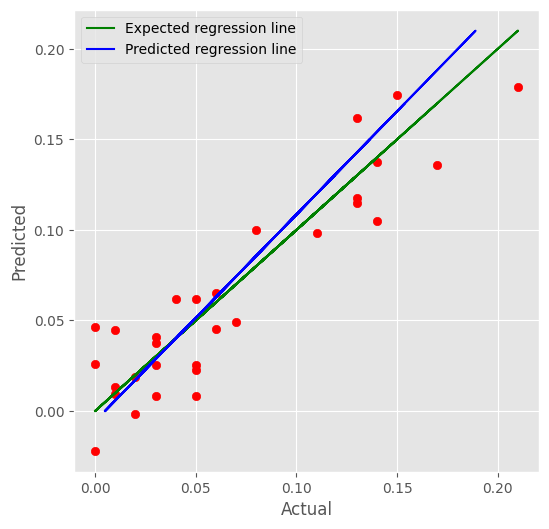

Phương trình chính quy: y = 0.067  + 0.014 * X_195 -0.017 * X_74 -0.005 * X_90 -0.004 * X_29  + 0.012 * X_72 -0.001 * X_9  + 0.011 * X_214  + 0.02 * X_118  + 0.005 * X_212 -0.017 * X_97 -0.031 * X_73  + 0.004 * X_165 -0.024 * X_189 -0.004 * X_49  + 0.007 * X_33  + 0.003 * X_13  + 0.014 * X_53  + 0.013 * X_162 -0.027 * X_180  + 0.001 * X_47 -0.009 * X_179 -0.024 * X_186  + 0.028 * X_89  + 0.006 * X_87  + 0.016 * X_98 -0.025 * X_45  + 0.025 * X_219 -0.008 * X_99 -0.0 * X_188 -0.001 * X_88  + 0.007 * X_196 


In [43]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'c']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  12
Number Wavelengths remove:  197
MSE min:  0.0010590080773423883

R2 calib: 0.987
R2 CV: 0.675
MSE calib: 0.000
MSE CV: 0.001


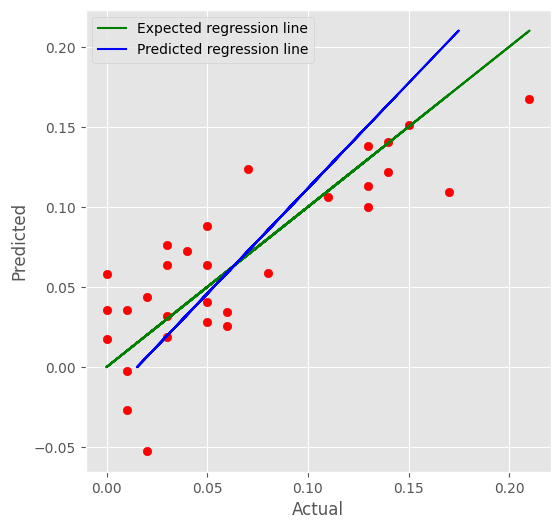

Phương trình chính quy: y = 0.067  + 0.035 * X_60  + 0.036 * X_111  + 0.035 * X_163 -0.013 * X_189  + 0.024 * X_117  + 0.024 * X_213 -0.026 * X_63 -0.021 * X_90 -0.004 * X_206  + 0.0 * X_99 -0.02 * X_73 -0.02 * X_45 -0.004 * X_52  + 0.02 * X_36  + 0.008 * X_200  + 0.022 * X_212 -0.04 * X_173  + 0.025 * X_211 -0.02 * X_171 -0.009 * X_47 -0.001 * X_199 -0.041 * X_10 -0.009 * X_100 -0.04 * X_23 -0.01 * X_46  + 0.021 * X_38  + 0.011 * X_75  + 0.011 * X_94  + 0.02 * X_43 -0.023 * X_101 -0.042 * X_102 


In [44]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  11
Number Wavelengths remove:  191
MSE min:  0.0006460102857972473

R2 calib: 0.992
R2 CV: 0.801
MSE calib: 0.000
MSE CV: 0.001


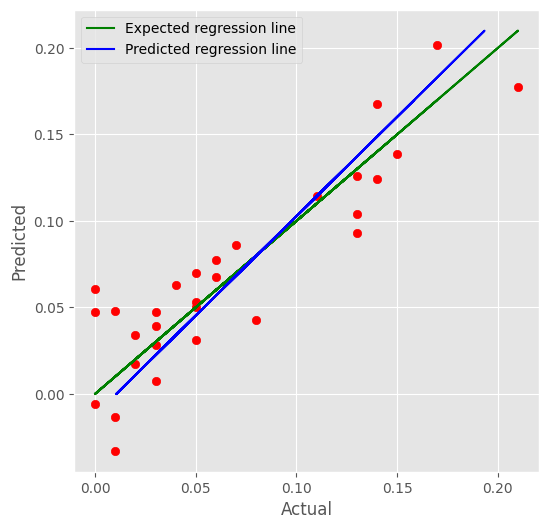

Phương trình chính quy: y = 0.067 -0.013 * X_44 -0.014 * X_33  + 0.011 * X_220 -0.005 * X_217 -0.008 * X_92 -0.021 * X_57  + 0.005 * X_159 -0.003 * X_117  + 0.007 * X_174  + 0.005 * X_28 -0.007 * X_162  + 0.0 * X_91  + 0.003 * X_171  + 0.008 * X_41  + 0.008 * X_29 -0.003 * X_203 -0.012 * X_160 -0.014 * X_181  + 0.01 * X_94 -0.01 * X_90 -0.01 * X_197  + 0.01 * X_215 -0.015 * X_166  + 0.01 * X_212  + 0.017 * X_179  + 0.012 * X_95 -0.009 * X_167  + 0.016 * X_145 -0.007 * X_210 -0.008 * X_202 -0.011 * X_186  + 0.018 * X_42 -0.01 * X_189  + 0.014 * X_214  + 0.016 * X_213  + 0.012 * X_170  + 0.018 * X_218 


In [45]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'e']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  17
Number Wavelengths remove:  197
MSE min:  0.0013953074540454045

R2 calib: 0.996
R2 CV: 0.571
MSE calib: 0.000
MSE CV: 0.001


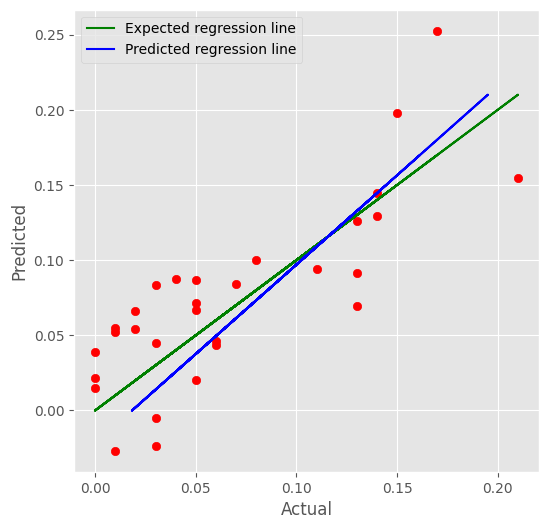

Phương trình chính quy: y = 0.067 -0.012 * X_45 -0.003 * X_194  + 0.06 * X_9  + 0.004 * X_183  + 0.002 * X_181  + 0.01 * X_215 -0.017 * X_150 -0.019 * X_50 -0.003 * X_51  + 0.023 * X_174 -0.017 * X_89 -0.004 * X_145 -0.017 * X_204  + 0.022 * X_119  + 0.025 * X_40 -0.012 * X_13  + 0.011 * X_114  + 0.017 * X_220 -0.017 * X_188 -0.001 * X_14 -0.01 * X_199 -0.011 * X_185 -0.018 * X_210  + 0.013 * X_214  + 0.015 * X_162  + 0.021 * X_74 -0.015 * X_187  + 0.026 * X_29 -0.025 * X_200 -0.007 * X_196 -0.025 * X_160 


In [46]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'f']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  12
Number Wavelengths remove:  202
MSE min:  0.0011830928531790658

R2 calib: 0.979
R2 CV: 0.636
MSE calib: 0.000
MSE CV: 0.001


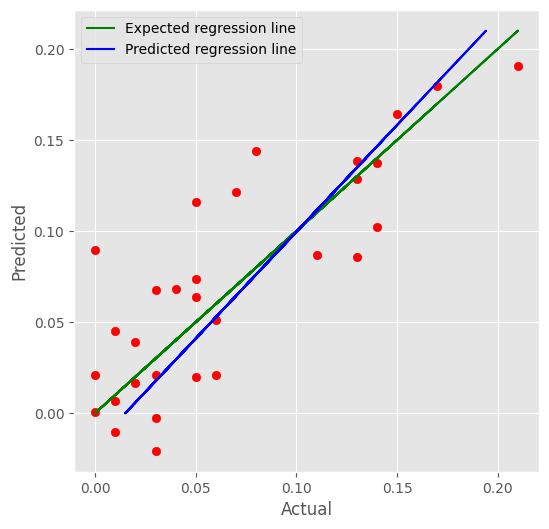

Phương trình chính quy: y = 0.067  + 0.015 * X_219 -0.027 * X_152  + 0.039 * X_203 -0.0 * X_148 -0.028 * X_29  + 0.032 * X_32  + 0.038 * X_182  + 0.003 * X_36 -0.001 * X_34 -0.011 * X_215 -0.014 * X_184 -0.002 * X_150 -0.008 * X_175  + 0.009 * X_154 -0.029 * X_204  + 0.033 * X_216 -0.018 * X_213  + 0.017 * X_87 -0.007 * X_147  + 0.002 * X_181 -0.015 * X_211 -0.009 * X_166 -0.018 * X_86 -0.005 * X_149  + 0.003 * X_35 -0.022 * X_88 


In [47]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'g']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  10
Number Wavelengths remove:  169
MSE min:  0.0015759905667770714

R2 calib: 0.984
R2 CV: 0.516
MSE calib: 0.000
MSE CV: 0.002


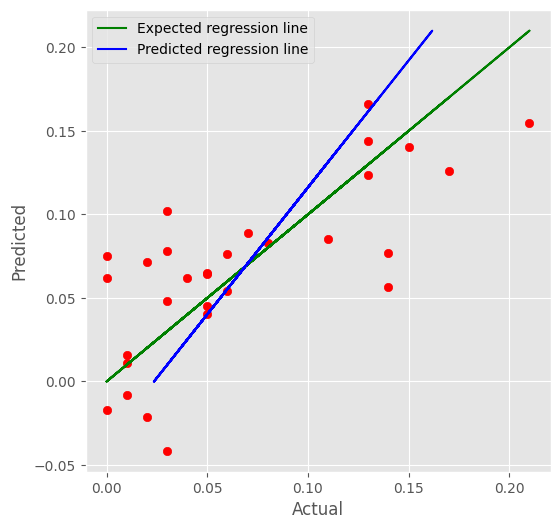

Phương trình chính quy: y = 0.067  + 0.016 * X_70  + 0.013 * X_71  + 0.009 * X_173  + 0.01 * X_113  + 0.005 * X_7  + 0.005 * X_3  + 0.005 * X_4  + 0.005 * X_5  + 0.005 * X_6  + 0.005 * X_2  + 0.005 * X_1  + 0.005 * X_8  + 0.007 * X_158 -0.002 * X_81 -0.009 * X_82  + 0.004 * X_152  + 0.008 * X_72  + 0.005 * X_73  + 0.007 * X_15 -0.011 * X_45 -0.012 * X_46  + 0.011 * X_157  + 0.007 * X_204  + 0.003 * X_162  + 0.008 * X_218  + 0.007 * X_160  + 0.017 * X_14  + 0.013 * X_176 -0.017 * X_9  + 0.0 * X_190  + 0.004 * X_87 -0.011 * X_213 -0.004 * X_197 -0.007 * X_11  + 0.006 * X_92 -0.019 * X_220 -0.01 * X_146  + 0.013 * X_155  + 0.012 * X_174  + 0.005 * X_194 -0.013 * X_199 -0.003 * X_184 -0.01 * X_186  + 0.01 * X_217  + 0.009 * X_187 -0.006 * X_182 -0.011 * X_85 -0.01 * X_185  + 0.014 * X_145  + 0.005 * X_90  + 0.01 * X_159  + 0.016 * X_188 -0.012 * X_167 -0.002 * X_216  + 0.01 * X_178 -0.013 * X_181  + 0.007 * X_219  + 0.014 * X_91  + 0.023 * X_177 


In [48]:
data1 = pd.read_csv("D:/NIR/do_tuoi_17_10_2022/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-6], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-4])
X = np.array(data2.values[:, 3:-6])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  33
Number Wavelengths remove:  161
MSE min:  0.3395823619482465

R2 calib: 0.997
R2 CV: 0.757
MSE calib: 0.005
MSE CV: 0.340


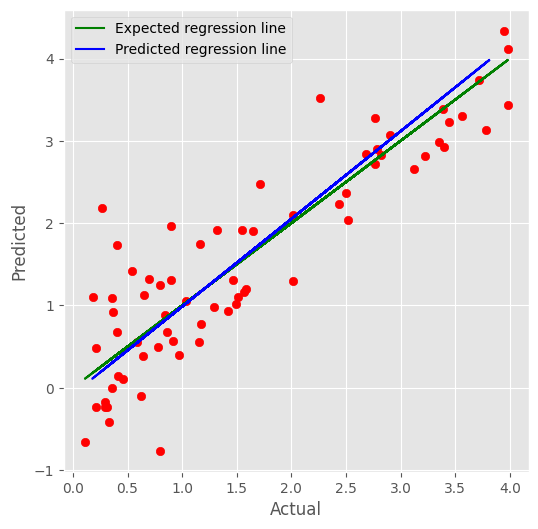

Phương trình chính quy: y = 1.58 -0.912 * X_33  + 0.691 * X_120 -0.824 * X_86 -0.57 * X_45 -0.039 * X_213  + 1.237 * X_181 -1.662 * X_142 -1.346 * X_147  + 0.393 * X_22 -0.592 * X_116  + 0.201 * X_27  + 0.54 * X_201 -0.891 * X_76 -0.093 * X_169 -1.079 * X_168 -0.038 * X_199  + 0.452 * X_36  + 0.087 * X_206  + 0.133 * X_9  + 0.028 * X_178 -1.15 * X_165  + 0.713 * X_12 -1.735 * X_99 -0.262 * X_88 -1.418 * X_115  + 0.466 * X_30  + 0.622 * X_29 -1.156 * X_192 -0.312 * X_104 -1.617 * X_220  + 1.108 * X_218 -0.951 * X_180 -0.627 * X_49 -0.209 * X_105  + 0.965 * X_109  + 0.221 * X_172  + 0.676 * X_190 -0.537 * X_170 -1.137 * X_102  + 1.521 * X_166  + 0.449 * X_193 -0.437 * X_188  + 1.133 * X_184  + 0.563 * X_31  + 1.533 * X_47  + 0.772 * X_39 -1.353 * X_25  + 0.856 * X_191 -0.917 * X_182 -0.834 * X_186 -1.598 * X_215 -0.803 * X_214 -1.344 * X_51 -1.212 * X_187 -1.135 * X_103  + 2.325 * X_50 -1.331 * X_28 -0.754 * X_101 -0.971 * X_35 -0.652 * X_176  + 1.051 * X_209  + 1.41 * X_189  + 1.684 * X

In [49]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/do_tuoi/TBA/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  34
Number Wavelengths remove:  157
MSE min:  0.22914855266442788

R2 calib: 0.999
R2 CV: 0.840
MSE calib: 0.002
MSE CV: 0.229


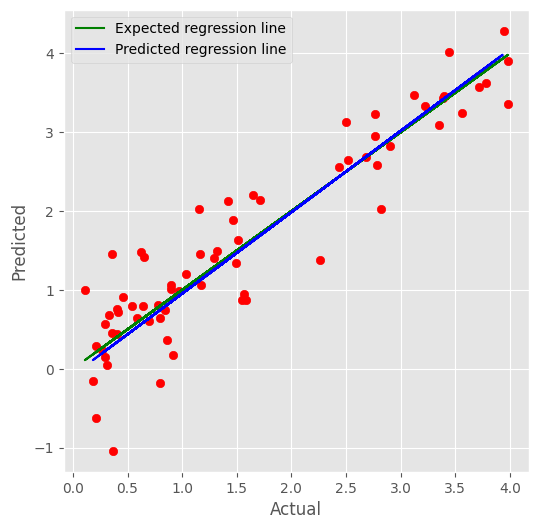

Phương trình chính quy: y = 1.569 -0.308 * X_145 -0.053 * X_117 -0.042 * X_163  + 0.833 * X_47  + 0.229 * X_193  + 0.066 * X_17  + 0.254 * X_160  + 0.066 * X_161  + 0.557 * X_101 -0.166 * X_20  + 0.65 * X_110  + 0.648 * X_21 -0.014 * X_166 -0.169 * X_205 -0.112 * X_50 -0.305 * X_201  + 0.179 * X_112  + 0.5 * X_150  + 0.284 * X_113  + 0.553 * X_33 -0.321 * X_146 -0.468 * X_56 -0.077 * X_71 -0.107 * X_57 -0.33 * X_73 -0.021 * X_183  + 0.381 * X_90  + 0.279 * X_151  + 0.128 * X_173  + 0.491 * X_218  + 0.429 * X_88 -0.191 * X_211 -0.426 * X_29 -0.252 * X_199  + 0.034 * X_32  + 0.576 * X_192 -0.527 * X_96 -0.073 * X_162  + 0.086 * X_26  + 0.37 * X_11 -0.515 * X_115 -0.457 * X_156  + 0.168 * X_207 -0.042 * X_197 -0.61 * X_195  + 0.393 * X_158  + 0.5 * X_198  + 0.461 * X_49 -0.852 * X_206 -0.73 * X_143 -0.012 * X_189 -0.224 * X_86  + 0.011 * X_80 -0.277 * X_212  + 0.51 * X_157 -0.418 * X_176  + 0.495 * X_154 -0.585 * X_217 -0.471 * X_70  + 0.819 * X_196  + 0.65 * X_19  + 0.719 * X_220 -0.694 

In [50]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/do_tuoi/TBA/ca_ngu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  17
Number Wavelengths remove:  199
MSE min:  0.37733195055613156

R2 calib: 0.795
R2 CV: 0.475
MSE calib: 0.147
MSE CV: 0.377


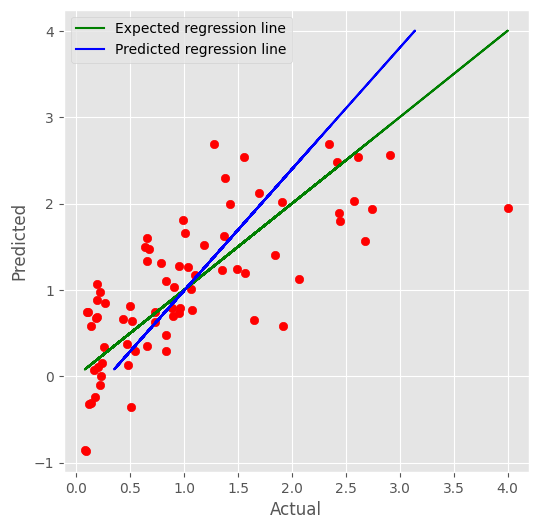

Phương trình chính quy: y = 1.035 -0.618 * X_161  + 0.812 * X_62 -0.003 * X_12 -0.879 * X_192 -0.505 * X_17 -0.194 * X_199  + 0.102 * X_37  + 0.497 * X_174 -0.528 * X_84 -0.53 * X_167  + 0.08 * X_18  + 0.342 * X_20 -0.806 * X_206 -0.284 * X_94  + 0.722 * X_180 -0.341 * X_11  + 0.119 * X_209  + 0.347 * X_190  + 0.317 * X_163 -0.832 * X_178  + 0.466 * X_87 -0.822 * X_46  + 0.103 * X_86  + 0.09 * X_22 -0.767 * X_115  + 0.716 * X_31 -0.527 * X_28 -0.713 * X_200 -0.332 * X_205 


In [51]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/do_tuoi/TBA/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  29
Number Wavelengths remove:  168
MSE min:  0.20276238962796791

R2 calib: 0.977
R2 CV: 0.718
MSE calib: 0.017
MSE CV: 0.203


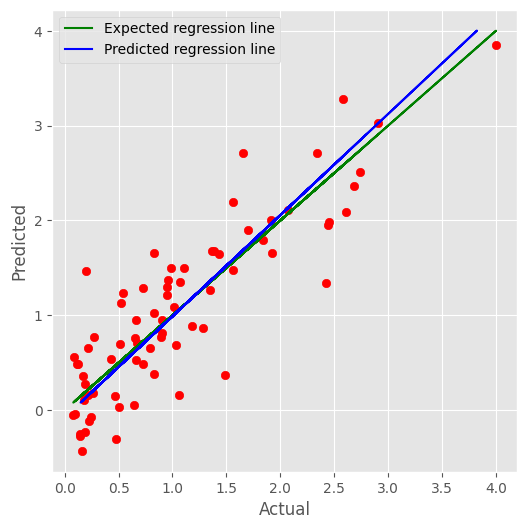

Phương trình chính quy: y = 1.029  + 0.595 * X_203 -0.27 * X_216 -0.485 * X_188 -0.279 * X_196  + 0.375 * X_130  + 0.108 * X_142  + 0.608 * X_126  + 0.026 * X_19  + 0.213 * X_9 -0.59 * X_209 -0.439 * X_81 -0.338 * X_138 -0.322 * X_84  + 0.476 * X_53  + 0.118 * X_25 -0.449 * X_212 -0.001 * X_200  + 0.56 * X_154 -0.105 * X_215 -0.758 * X_36 -0.305 * X_24  + 0.79 * X_128 -0.339 * X_52  + 0.237 * X_164  + 0.517 * X_96 -0.836 * X_72 -0.15 * X_159  + 0.319 * X_18 -0.472 * X_63 -1.124 * X_27 -0.13 * X_74  + 0.358 * X_87 -0.555 * X_185  + 0.51 * X_47 -0.521 * X_98 -0.531 * X_51  + 0.899 * X_129  + 0.475 * X_28 -0.512 * X_44 -0.337 * X_85 -0.747 * X_194 -0.309 * X_147  + 0.294 * X_160  + 0.608 * X_148  + 0.199 * X_158 -0.15 * X_198  + 0.815 * X_83 -0.0 * X_11  + 0.625 * X_167  + 0.622 * X_187 -1.105 * X_50 -1.052 * X_201  + 0.331 * X_213 -0.535 * X_199  + 0.26 * X_149  + 0.591 * X_30 -0.745 * X_204  + 0.695 * X_219  + 0.522 * X_197 -0.49 * X_157 


In [4]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/do_tuoi/TBA/ca_nuc.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  28
Number Wavelengths remove:  188
MSE min:  0.0007913432396426888

R2 calib: 1.000
R2 CV: 0.757
MSE calib: 0.000
MSE CV: 0.001


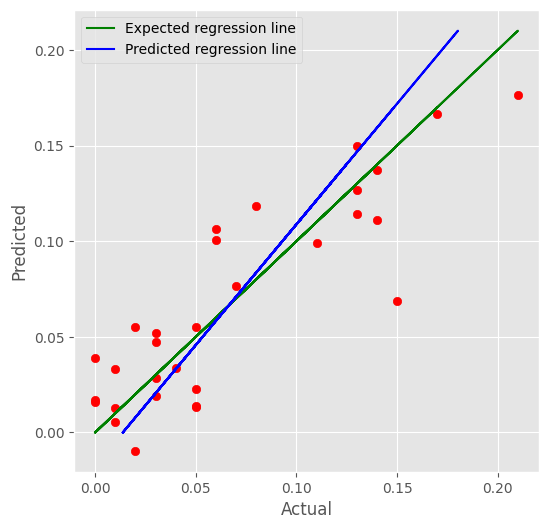

Phương trình chính quy: y = 0.067  + 0.012 * X_84  + 0.01 * X_39  + 0.007 * X_41  + 0.002 * X_87  + 0.02 * X_216 -0.006 * X_24  + 0.005 * X_18 -0.005 * X_33  + 0.016 * X_158 -0.005 * X_11 -0.004 * X_175 -0.004 * X_114 -0.019 * X_118  + 0.024 * X_54 -0.009 * X_31  + 0.001 * X_12  + 0.01 * X_219  + 0.02 * X_19  + 0.009 * X_194 -0.012 * X_210 -0.007 * X_25  + 0.026 * X_201  + 0.013 * X_192  + 0.01 * X_90 -0.012 * X_186  + 0.025 * X_163 -0.001 * X_171 -0.011 * X_116  + 0.003 * X_189 -0.006 * X_115  + 0.003 * X_204 -0.0 * X_17  + 0.017 * X_53 -0.021 * X_32 -0.02 * X_164 -0.012 * X_47  + 0.016 * X_197 -0.024 * X_29  + 0.024 * X_196  + 0.022 * X_162 


In [3]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/do_tuoi/TBA/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'd']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


PLS components:  12
Number Wavelengths remove:  167
MSE min:  0.0006987900585034631

R2 calib: 0.998
R2 CV: 0.785
MSE calib: 0.000
MSE CV: 0.001


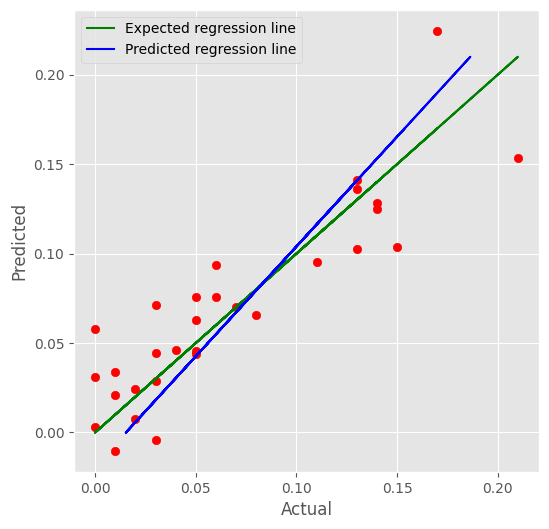

Phương trình chính quy: y = 0.067  + 0.004 * X_42  + 0.005 * X_34 -0.0 * X_151  + 0.008 * X_189  + 0.006 * X_50 -0.01 * X_102 -0.002 * X_10  + 0.006 * X_20  + 0.01 * X_35 -0.0 * X_160 -0.001 * X_24 -0.013 * X_100  + 0.001 * X_182  + 0.008 * X_21 -0.001 * X_76 -0.002 * X_184 -0.01 * X_186  + 0.001 * X_133 -0.01 * X_220 -0.003 * X_179  + 0.007 * X_48  + 0.012 * X_145  + 0.007 * X_43 -0.002 * X_32 -0.002 * X_23  + 0.009 * X_177 -0.006 * X_95 -0.009 * X_97 -0.0 * X_11  + 0.002 * X_161  + 0.002 * X_214  + 0.009 * X_206  + 0.009 * X_217  + 0.002 * X_193  + 0.002 * X_31 -0.008 * X_149  + 0.003 * X_178 -0.007 * X_210  + 0.005 * X_211 -0.009 * X_170  + 0.006 * X_164 -0.004 * X_146  + 0.01 * X_49  + 0.004 * X_216  + 0.003 * X_150 -0.005 * X_165  + 0.008 * X_173  + 0.005 * X_194 -0.008 * X_209 -0.012 * X_180  + 0.01 * X_207  + 0.007 * X_132  + 0.006 * X_13  + 0.001 * X_154  + 0.002 * X_175  + 0.012 * X_131 -0.009 * X_148 -0.016 * X_169 -0.013 * X_147  + 0.009 * X_12 -0.013 * X_166 


In [2]:
data1 = pd.read_csv("D:/NIR/phan-tich_buoc_song/bo_mang_mat/do_tuoi/TBA/ca_thu.csv")
#array = data['vi tri do'].unique()
data2 = data1.replace([np.inf, -np.inf], np.nan).dropna()
data2 = data2[data2['vi tri do'] == 'h']
wavelength = np.array(data2.columns[3:-3], dtype='float')


#data2 = data2.drop(data2[data2['Histamine(mg/kg)'] <50].index)
#data2 = data2.drop(data2[data2['Urea(mg/kg)'] > 10000].index)

y = np.array(data2.values[:,-3])
X = np.array(data2.values[:, 3:-3])
w1 = np.arange(838, 1750, 4) # wavelengths
x2 = savgol_filter(X, 15, polyorder=2, deriv=2)

df = pd.read_csv("D:/NIR/25_3_2024 chạy lại ptr hồi quy/ten_buoc_song.csv")
wavelength = df.columns[:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

def pls_variable_selection(x2, y, max_comp, n_cv):
    
# Khai bao mảng de luu gia tri MSE khi loại bỏ dần dữ liệu 
    mse = np.zeros((max_comp,x2.shape[1]))
        # Lap gia tri 
    for i in range(max_comp):
            
            # Chạy hồi quy PLS lần 1 với component = i + 1 vì i bắt đầu từ 0
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(x2, y)

            # Lấy thứ tự các bước sóng theo thứ tự từ thấp tới cao theo trị tuyệt đối của PLS coefficients
        sorted_wlt = np.argsort(np.abs(pls1.coef_[:,0]))
    
            # Sắp xếp lại quang phổ theo thứ tự các bước sóng quan trọng đã lấy ở trên
        Xc = x2[:,sorted_wlt]
    
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the MSE cross-validation

            # Loại bỏ dần từng bước sóng theo thứ tự đã sắp xếp
        for j in range(150, Xc.shape[1]-(i+1)):

                # Hồi quy lần 2 với input là ma trận các bước sóng còn lại và y 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
                # Tính giá trị xác thực chéo 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=n_cv)
    
            mse[i,j] = mean_squared_error(y, y_cv)
    
        # Tìm giá trị MSE min trong mảng 2 chiều (chiều x là số component tối ưu, chiều y là số bước sóng loại bỏ )
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    
    print("PLS components: ", mseminx[0]+1)
    print("Number Wavelengths remove: ",mseminy[0])
    print('MSE min: ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
        # Calculate PLS with optimal components and export values
        # Tính lại kết quả để return
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(x2, y)
        # Thứ tự bước sóng được sắp xếp
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
        # Ma trận bươc sóng đã được loại bỏ
    Xc = x2[:,sorted_ind][:,mseminy[0]:]
        
    
    pls_opt = PLSRegression(n_components=mseminx[0]+1)
 
    # Fir to the entire dataset
    pls_opt.fit(Xc, y)
    y_c = pls_opt.predict(Xc)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, Xc, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
         
    y = y.reshape(-1).astype(float)
    y_cv = y_cv.reshape(-1).astype(float)

  
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='red')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
        plt.show()

    Xsong1 =[]
    for k in range(mseminy[0], 228):
        Xsong = sorted_ind[k]
        #ctv3 = pd.join(Xsong)
        Xsong1.append(Xsong)
        df1 = pd.DataFrame(Xsong1)
        df1.to_csv("D:/NIR/phan-tich_buoc_song/buoc_song_120_228/test.csv", index = False, encoding='utf-8-sig') 
    #print("Các bước sóng giữ lại:", Xsong1)
    
    return(Xc,mseminx[0]+1,mseminy[0], sorted_ind, pls_opt)

plt.show()
a, b, c, d, pls_opt = pls_variable_selection(x2, y, 40, 10)

sorted_ind2 = wavelength[d][c:].astype('int')

pls_model = PLSRegression(n_components=b)
pls_model.fit(a, y)
coefficients = pls_model.coef_
#intercept = pls_model.intercept_

#coefficients = pls_model.coef_
intercept = np.mean(y) - np.dot(np.mean(a, axis=0), coefficients)


#intercept = pls_model.intercept_
equation = f"y = {round(intercept[0],3)} "

for i, coef in enumerate(coefficients):
    if coef[0] < 0:
        equation += f"{round(coef[0],3)} * X_{sorted_ind2[i]} "
    else:
        equation += f" + {round(coef[0],3)} * X_{sorted_ind2[i]} "

print("Phương trình chính quy:", equation)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter
import os, re
import seaborn as sns
from sys import stdout

from scipy.signal import savgol_filter
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score